**Authors**
- Dotti Andrea [[_Github profile_](https://github.com/AndreaD002)][[_Institutional_ _email_](mailto:andrea.dotti4@studio.unibo.it)]
    * Student ID: 0001180322
- Petrelli Tommaso [[_Github profile_](https://github.com/petrello)][[_Institutional_ _email_](mailto:tommaso.petrelli2@studio.unibo.it)]
    * Student ID: 0001179757

# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

## Setup and Reproducibility

We import the required libraries for data handling, model definition, training, and evaluation.
The computation device is selected automatically, and Automatic Mixed Precision (AMP) is enabled on CUDA to improve training efficiency and reduce memory consumption.

The default input size is set to $224\times 224$, and training is configured for 100 epochs.

Random seeds are fixed and deterministic CUDA settings are enforced to ensure reproducible results across runs.

In [ ]:
import math
import time
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from pathlib import Path
from collections import Counter
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Optional

import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from torchvision.transforms import v2, RandAugment
from torchvision.models import resnet18, ResNet18_Weights

try:
  from torchinfo import summary
except:
  # Install on Colab environment
  %pip install torchinfo
  from torchinfo import summary


# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Set Mixed Precision utilisation
USE_AMP = True if torch.cuda.is_available() else False
print(f"Using Automatic Mixed Precision: {USE_AMP}")

# Set default input size
INPUT_SIZE = (1, 3, 224, 224)

# Set default training configurations
EPOCHS = 100

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Data Loaders reproducibility
dl_generator = torch.Generator()
dl_generator = dl_generator.manual_seed(SEED)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

Using device: cuda
Using Automatic Mixed Precision: True


## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [2]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

Cloning into 'ipcv-assignment-2'...
remote: Enumerating objects: 7371, done.
remote: Total 7371 (delta 0), reused 0 (delta 0), pack-reused 7371 (from 1)
Receiving objects: 100% (7371/7371), 753.77 MiB | 38.96 MiB/s, done.
Updating files: 100% (7396/7396), done.


In [3]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

### Dataset overview

In [4]:
# Create datasets
train_dataset = OxfordPetDataset('train', transform=None)
val_dataset   = OxfordPetDataset('val',   transform=None)
test_dataset  = OxfordPetDataset('test',  transform=None)

# Get number of samples per set
train_samples = len(train_dataset)
val_samples   = len(val_dataset)
test_samples  = len(test_dataset)
total_samples = train_samples + val_samples + test_samples

# Get split percentage per set
train_percent = train_samples * 100 / total_samples
val_percent   = val_samples * 100 / total_samples
test_percent  = test_samples * 100 / total_samples

# Save number of classes
NUM_CLASSES = train_dataset.get_num_classes()

print("Dataset overview:")
print("="*50)
print(f"{'Number of classes:':<30} {NUM_CLASSES}\n")
print(f"{'Training samples:':<30} {train_samples} ({train_percent:.2f}%)")
print(f"{'Validation samples:':<30} {val_samples} ({val_percent:.2f}%)")
print(f"{'Test samples:':<30} {test_samples} ({test_percent:.2f}%)")
print("-"*50)
print(f"{'Total number of samples:':<30} {total_samples} (100%)")

Dataset overview:
Number of classes:             37

Training samples:              3669 (49.93%)
Validation samples:            1834 (24.96%)
Test samples:                  1846 (25.12%)
--------------------------------------------------
Total number of samples:       7349 (100%)


### Distributions summary

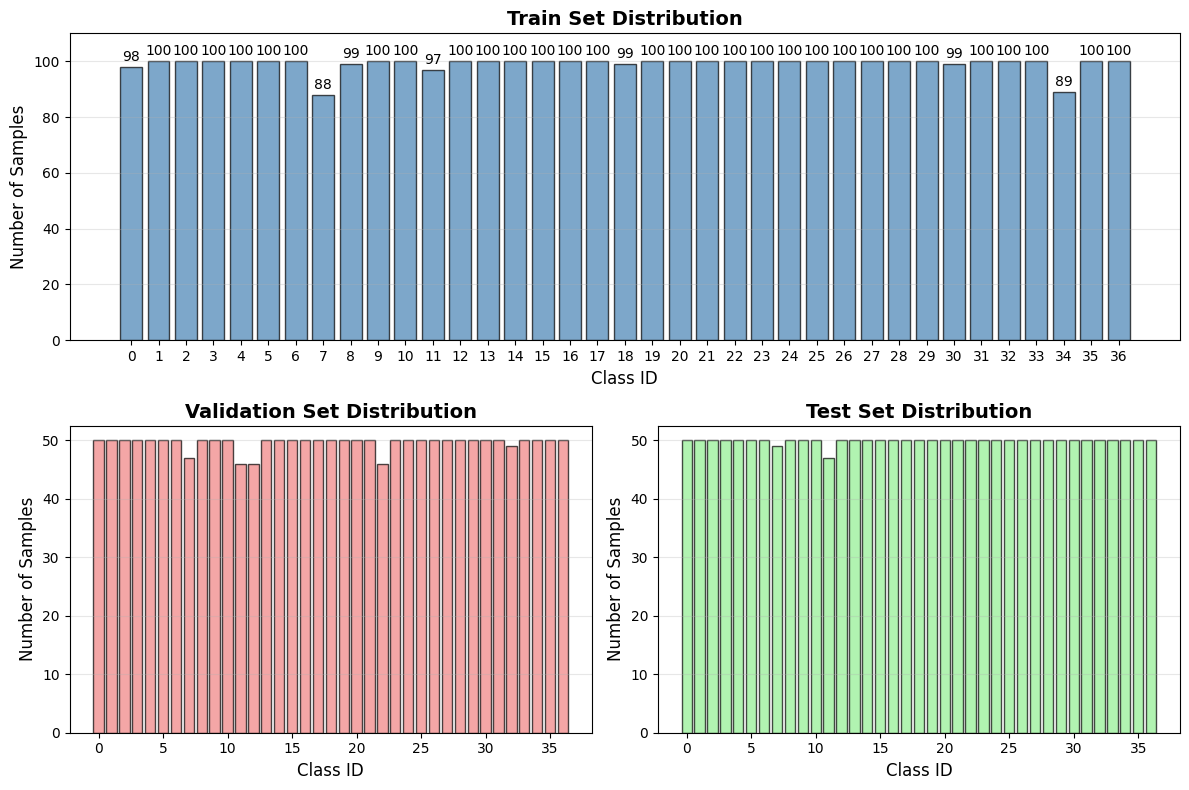

In [5]:
# Get class distribution per set
train_dist = Counter(train_dataset.labels)
val_dist   = Counter(val_dataset.labels)
test_dist  = Counter(test_dataset.labels)

# Plot class distributions
fig = plt.figure(figsize=(12, 8))

# Subplot for train set
ax0 = plt.subplot(2, 2, (1, 2))
train_classes = sorted(train_dist.keys())
train_counts = [train_dist[c] for c in train_classes]
bars = ax0.bar(train_classes, train_counts, alpha=0.7, color='steelblue', edgecolor='black')
ax0.set_xlabel('Class ID', fontsize=12)
ax0.set_xticks(train_classes)
ax0.set_ylabel('Number of Samples', fontsize=12)
ax0.set_ylim(0, max(train_counts)+10)
ax0.set_title('Train Set Distribution', fontsize=14, fontweight='bold')
ax0.grid(axis='y', alpha=0.3)
# Add sample counts above bars for the train set
for bar in bars:
    yval = bar.get_height()
    ax0.text(bar.get_x() + bar.get_width()/2, yval+1, int(yval), ha='center', va='bottom', fontsize=10)

# Subplot for validation set
ax1 = plt.subplot(2, 2, 3)
val_classes = sorted(val_dist.keys())
val_counts = [val_dist[c] for c in val_classes]
ax1.bar(val_classes, val_counts, alpha=0.7, color='lightcoral', edgecolor='black')
ax1.set_xlabel('Class ID', fontsize=12)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.set_title('Validation Set Distribution', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Subplot for test set
ax2 = plt.subplot(2, 2, 4)
test_classes = sorted(test_dist.keys())
test_counts = [test_dist[c] for c in test_classes]
ax2.bar(test_classes, test_counts, alpha=0.7, color='lightgreen', edgecolor='black')
ax2.set_xlabel('Class ID', fontsize=12)
ax2.set_ylabel('Number of Samples', fontsize=12)
ax2.set_title('Test Set Distribution', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Samples visualization

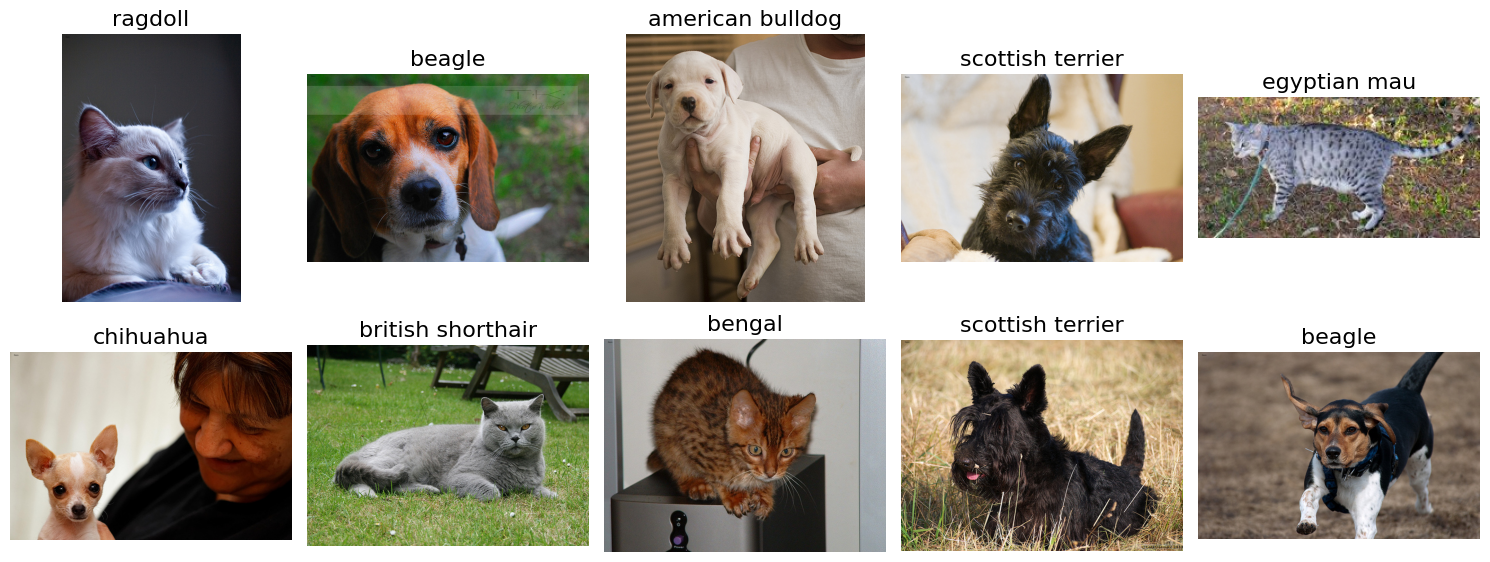

In [6]:
def visualize_random_samples(dataset, num_samples=10):
    """
    Visualize random samples from the dataset.
    """
    # Build label -> class name map from dataset
    names, labels = dataset._get_names_and_labels()
    class_names = {}
    for name, lbl in zip(names, labels):
        if lbl not in class_names:
            class_names[lbl] = " ".join(name.split("_")[:-1])  # extract class name prefix

    # Sample random indices
    indices = random.sample(range(len(dataset)), num_samples)

    cols = 5
    rows = (num_samples + cols - 1) // cols

    plt.figure(figsize=(cols * 3, rows * 3))

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        plt.subplot(rows, cols, i + 1)

        # convert tensor for display
        if isinstance(img, torch.Tensor):
            img_show = img.permute(1, 2, 0).numpy()
        else:
            img_show = img

        plt.imshow(img_show)
        plt.title(class_names[label].lower(), fontsize=16)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize 10 random samples
visualize_random_samples(train_dataset, num_samples=10)

### Dimensionality summary

In [7]:
def summarize_image_dimensions(dataset):
    widths, heights, aspect_ratios = [], [], []

    sample_size = len(dataset)

    # Sample without replacement
    indices = np.random.choice(len(dataset), sample_size, replace=False)

    for i in indices:
        img, _ = dataset[i]
        w, h = img.size
        widths.append(w)
        heights.append(h)
        aspect_ratios.append(round(w / h, 2))

    # Compute stats
    widths = np.array(widths)
    heights = np.array(heights)

    resolutions = list(zip(widths, heights))
    resolution_counts = Counter(resolutions)
    most_common_res, res_count = resolution_counts.most_common(1)[0]

    ar_counts = Counter(aspect_ratios)
    most_common_ar, ar_count = ar_counts.most_common(1)[0]

    # Orientation stats
    landscape = np.mean(widths > heights) * 100
    portrait  = np.mean(widths < heights) * 100
    square    = np.mean(widths == heights) * 100

    # Print concise summary
    print("\nImage Dimension Summary")
    print("="*60)
    print(f"Width:  mean={widths.mean():.0f}px  std={widths.std():.0f}px  range=({widths.min()}, {widths.max()})")
    print(f"Height: mean={heights.mean():.0f}px  std={heights.std():.0f}px  range=({heights.min()}, {heights.max()})")
    print(f"Most common resolution: {most_common_res[0]}x{most_common_res[1]}  ({res_count/sample_size*100:.1f}% of images)")
    print(f"Most common aspect ratio: {most_common_ar}  ({ar_count/sample_size*100:.1f}%)")
    print(f"Orientation: {landscape:.1f}% landscape, {portrait:.1f}% portrait, {square:.1f}% square\n")

summarize_image_dimensions(train_dataset)


Image Dimension Summary
Width:  mean=443px  std=104px  range=(137, 1646)
Height: mean=399px  std=101px  range=(103, 2160)
Most common resolution: 500x375  (17.8% of images)
Most common aspect ratio: 1.33  (21.3%)
Orientation: 64.8% landscape, 33.2% portrait, 2.0% square



## Data Augmentation

Due to the limited size of the Oxford-IIIT Pet Dataset and the high intra-class variability across breeds, data augmentation is used to reduce overfitting and improve generalization.

Training images are resized to $256\times 256$ and randomly cropped to $224\times 224$. Geometric augmentations (horizontal flip, rotation, affine transforms) increase robustness to pose, scale, and spatial variations. Photometric augmentations (color jitter, random grayscale, RandAugment) address changes in illumination and color distribution. Random erasing is applied to simulate partial occlusions. Images are finally normalized using ImageNet statistics.

A weaker augmentation pipeline, `weak_train_transform`, is also defined for ablation studies, retaining only basic geometric transformations and normalization.

No stochastic augmentation is applied to validation and test sets. Instead, images are just resized to $256\times 256$, center-cropped to $224\times 224$, and normalized to ensure consistent evaluation conditions.

In [8]:
# Normalization setp is very useful for EfficientNet-like architectures
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Transform train set
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3,
                           saturation=0.3, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    RandAugment(num_ops=2, magnitude=6),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    transforms.RandomErasing(p=0.15, scale=(0.02, 0.2))
])

# Weaker transform for train set (for ablation study)
weak_train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Transform validation/test set
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

### Augmented samples visualization

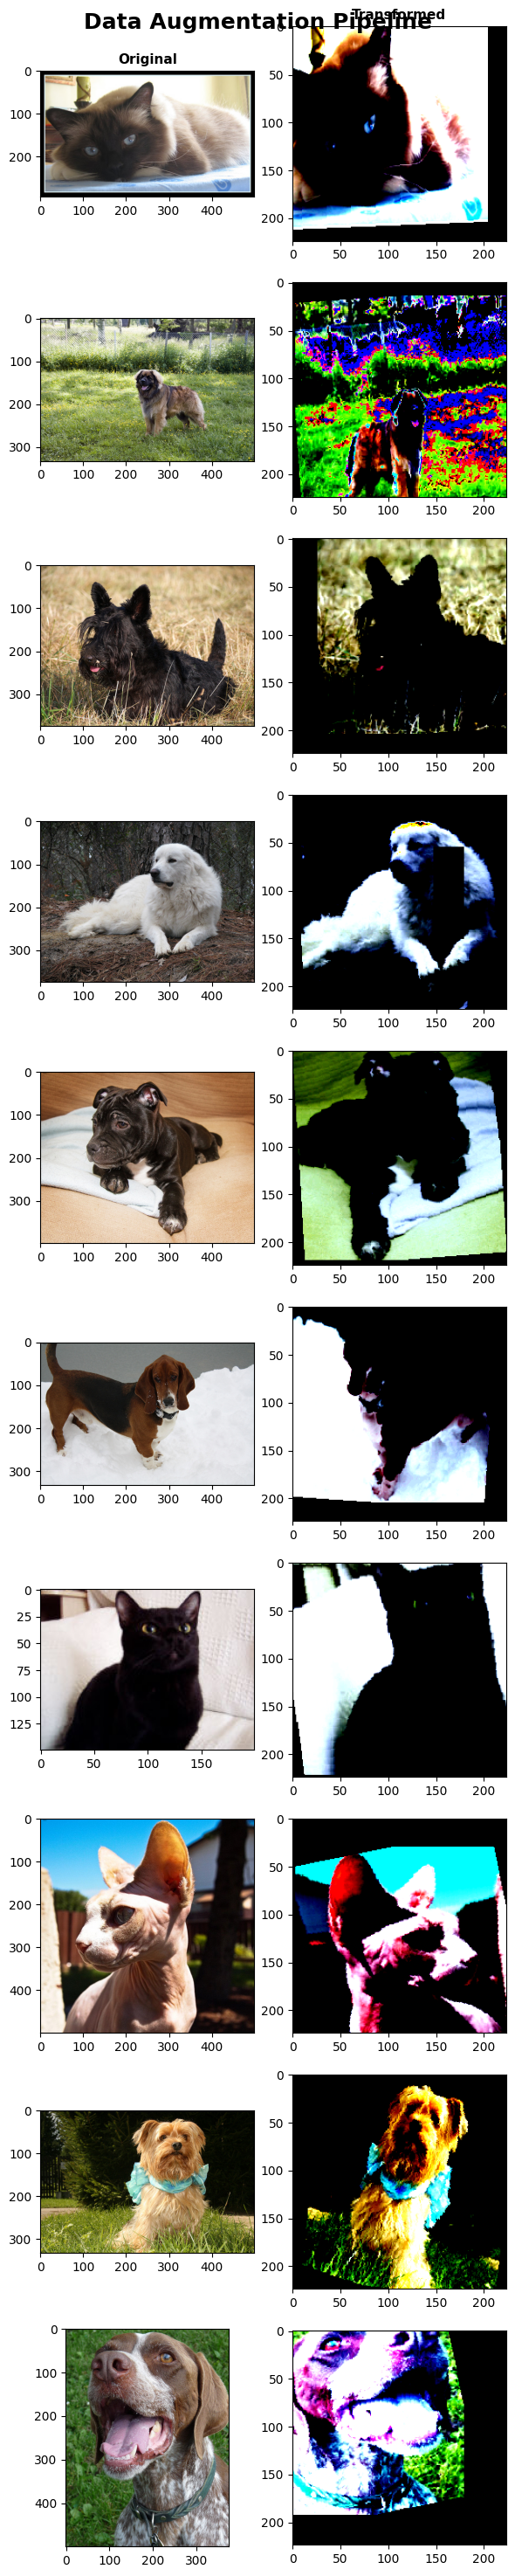

In [ ]:
def visualize_augmentation(dataset, transform, num_samples=3):
    """
    Visualize the augmentation pipeline effect on a few samples.
    """
    steps = [
        ("Original", None),
        ("Transformed", transform),
    ]

    n_steps = len(steps)
    fig, axes = plt.subplots(num_samples, n_steps, figsize=(3 * n_steps, 3 * num_samples))
    fig.suptitle("Data Augmentation Pipeline", fontsize=18, fontweight="bold")

    random_idxs = np.random.choice(len(dataset), num_samples, replace=False)

    # Ensure axes is always a 2D array even for num_samples = 1
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)

    for row, idx in enumerate(random_idxs):
        original, _ = dataset[idx]

        for col, (name, current_transform) in enumerate(steps):
            img_to_display = original if current_transform is None else current_transform(original.copy())

            # Convert tensor for display if it's a tensor
            if isinstance(img_to_display, torch.Tensor):
                # Permute from (C, H, W) to (H, W, C) and convert to numpy
                img_to_display = img_to_display.permute(1, 2, 0).numpy()
                # Clip values to [0, 1] if they are normalized, as imshow expects this range
                img_to_display = np.clip(img_to_display, 0, 1)

            axes[row, col].imshow(img_to_display)

            if row == 0:
                axes[row, col].set_title(name, fontsize=11, fontweight="bold")

    plt.tight_layout()
    plt.show()

# Visualize some examples of transformed images
visualize_augmentation(
    OxfordPetDataset("train", transform=None), train_transform, num_samples=10
)

### Create the data loaders

In [10]:
# Load datasets
train_dataset = OxfordPetDataset("train", transform=train_transform)
val_dataset   = OxfordPetDataset("val",   transform=val_transform)
test_dataset  = OxfordPetDataset("test",  transform=val_transform)

# Apply weaker transform (for ablation study)
weak_train_dataset = OxfordPetDataset("train", transform=weak_train_transform)

In [ ]:
# Create dataloaders
batch_size  = 64
num_workers = 2

train_loader = DataLoader(
    train_dataset, 
    batch_size, 
    shuffle=True,  
    num_workers=num_workers, 
    worker_init_fn=seed_worker,
    generator=dl_generator,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    worker_init_fn=seed_worker,
    generator=dl_generator, 
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size,
    shuffle=False, 
    num_workers=num_workers, 
    worker_init_fn=seed_worker,
    generator=dl_generator,
    pin_memory=True
)

# Create an additional dataloader with a weaker transform (for ablation study)
weak_train_loader = DataLoader(
    weak_train_dataset, 
    batch_size, 
    shuffle=True, 
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=dl_generator,
    pin_memory=True
)

print(f"Batch size: {batch_size}")
print(f"- Train batches: {len(train_loader)}")
print(f"- Val batches:   {len(val_loader)}")
print(f"- Test batches:  {len(test_loader)}")

Batch size: 64
- Train batches: 58
- Val batches:   29
- Test batches:  29


## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.

### Tracking experiments: `AblationTracker`
To systematically manage ablation studies, we define an `ExperimentConfig` dataclass to store all architectural, augmentation, and training hyperparameters.

The `AblationTracker` class collects experiment configurations and results, and automatically logs model complexity (parameters, FLOPs, size), training statistics, and final performance. Results can be easily compared, summarized, and exported for analysis.

In [12]:
@dataclass
class ExperimentConfig:
    """Store experiment configuration"""
    # Model architecture
    width_mult: float
    depth_mult: float
    dropout_rate: float
    drop_path_rate: float
    use_depthwise: bool
    use_residual: bool

    # Data augmentation
    cutmix_prob: float
    mixup_prob: float

    # Training hyperparameters
    label_smoothing: float
    lr: float
    weight_decay: float
    optimizer: str

    def to_dict(self) -> Dict[str, Any]:
        """Convert to dictionary"""
        return self.__dict__.copy()


class AblationTracker:
    """Ablation study tracker"""

    def __init__(self):
        self.experiments = []

    def add_experiment(self, model_name: str, config: ExperimentConfig,
                       model, history: Dict, test_acc: float, test_loss: float,
                       input_size: Tuple[int] = (1, 3, 224, 224), device: str ='cuda'):
        """
        Add experiment result

        Args:
            model_name: Name of the experiment
            config: ExperimentConfig object with hyperparameters
            model: Trained model
            history: Training history dict with 'train_time', 'train_acc', 'val_acc'
            test_acc: Test accuracy (%)
            test_loss: Test loss
        """
        # Calculate metrics
        total_time = sum(history['train_time']) / 60
        avg_epoch_time = sum(history['train_time']) / len(history['train_time'])
        best_val_acc = max(history['val_acc'])
        generalization_gap = history['train_acc'][-1] - history['val_acc'][-1]

        # Model complexity using torchinfo
        model_info = summary(model, input_size=input_size, verbose=0, device=device)
        total_params = model_info.total_params / 1e6
        model_size_mb = model_info.total_params * 4 / (1024**2)  # Assuming float32
        total_flops = model_info.total_mult_adds / 1e9

        # Store result
        result = {
            'Model Name': model_name,
            'Parameters (M)': round(total_params, 2),
            'Model Size (MB)': round(model_size_mb, 2),
            'FLOPs (G)': round(total_flops, 2),
            'Test Acc (%)': round(test_acc, 2),
            'Test Loss': round(test_loss, 4),
            'Best Val Acc (%)': round(best_val_acc, 2),
            'Generalization Gap (%)': round(generalization_gap, 2),
            'Total Training Time (min)': round(total_time, 1),
            'Avg Training Epoch Time (s)': round(avg_epoch_time, 1),
            # Config details
            'Width Mul': config.width_mult,
            'Depth Mul': config.depth_mult,
            'Dropout Rate': config.dropout_rate,
            'Drop Path Rate': config.drop_path_rate,
            'Depthwise Convolution': config.use_depthwise,
            'Residual Connections': config.use_residual,
            'CutMix Prob': config.cutmix_prob,
            'MixUp Prob': config.mixup_prob,
            'Label Smoothing': config.label_smoothing,
            'Learning Rate': config.lr,
            'Weight Decay': config.weight_decay,
            'Optimizer': config.optimizer
        }

        self.experiments.append(result)
        print(f"Added: {model_name} | Test Acc: {test_acc:.2f}% | Params: {total_params:.1f}M")

    def get_dataframe(self, columns=None):
        """
        Get results as DataFrame

        Args:
            columns: List of columns to show (None = show all)
        """
        df = pd.DataFrame(self.experiments)
        if columns:
            df = df[columns]
        if 'Test Acc (%)' in df.columns:
            return df.sort_values('Test Acc (%)', ascending=False)
        else:
            return df


    def show(self, columns=None):
        """Display results table"""
        if columns is None:
            # Default: show most important columns
            columns = ['Model Name', 'Test Acc (%)', 'Generalization Gap (%)',
                       'Test Loss', 'Best Val Acc (%)',
                       'Parameters (M)', 'Total Training Time (min)']
        return self.get_dataframe(columns)

    def show_config(self):
        """Show configuration comparison"""
        cols = ['Model Name', 'Width Mul', 'Depth Mul', 'Dropout Rate',
                'Drop Path Rate', 'Depthwise Convolution', 'Residual Connections',
                'CutMix Prob','MixUp Prob', 'Label Smoothing',
                'Learning Rate', 'Weight Decay', 'Optimizer']
        return self.get_dataframe(cols)

    def save(self, filename='ablation_results.csv'):
        """Save to CSV"""
        df = pd.DataFrame(self.experiments)
        df.to_csv(filename, index=False)
        print(f"Saved to {filename}")

    def summary(self):
        """Print summary statistics"""
        if not self.experiments:
            print("No experiments yet!")
            return

        df = pd.DataFrame(self.experiments)

        print("\n" + "="*80)
        print("ABLATION STUDY SUMMARY")
        print("="*80)

        # Best model
        best_idx = df['Test Acc (%)'].idxmax()
        best = df.loc[best_idx]
        print(f"\nBest Model: {best['Model Name']}")
        print(f"   Test Acc: {best['Test Acc (%)']}%")
        print(f"   Test Loss: {best['Test Loss']}")
        print(f"   Generalization Gap: {best['Generalization Gap (%)']}%")
        print(f"   Parameters: {best['Parameters (M)']} M")
        print(f"   Training Time: {best['Total Training Time (min)']} min")

        # Fastest model
        fastest_idx = df['Total Training Time (min)'].idxmin()
        fastest = df.loc[fastest_idx]
        print(f"\nFastest: {fastest['Model Name']}")
        print(f"   Training Time: {fastest['Total Training Time (min)']} min")
        print(f"   Avg Training Epoch Time: {fastest['Avg Training Epoch Time (s)']} s")
        print(f"   Giga FLOPs Operations: {fastest['FLOPs (G)']}")

        # Biggest model
        biggest_idx = df['Model Size (MB)'].idxmax()
        biggest = df.loc[biggest_idx]
        print(f"\nBiggest: {biggest['Model Name']}")
        print(f"   Size: {biggest['Model Size (MB)']} MB")
        print(f"   Parameters: {biggest['Parameters (M)']} M")

        print("="*80 + "\n")

### Training functions

In [13]:
def train_epoch(model, loader, criterion, optimizer,
                device, cutmix_or_mixup=None, scaler=None):
    """
    This function implements the training process during
    one single epoch.

    Args:
        model: The neural network model
        loader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimizer
        device: Device to train on
        cutmix_or_mixup: Transform that applies CutMix, MixUp, or Identity
        scaler: GradScaler for mixed precision training
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    start_time = time.time()

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        if cutmix_or_mixup is not None:
            # Apply CutMix/MixUp augmentation if provided
            inputs, labels = cutmix_or_mixup(inputs, labels)

        optimizer.zero_grad()

        if scaler is not None:
            # Mixed precision training
            with torch.amp.autocast(device_type=device.type):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard training
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Handle accuracy calculation for mixed labels
        _, predicted = outputs.max(1)
        total += labels.size(0)

        # For mixed labels, we need to handle the soft labels differently
        if len(labels.shape) > 1:  # One-hot or mixed labels
            # Get the class with highest probability in the mixed label
            _, target_class = labels.max(1)
            correct += predicted.eq(target_class).sum().item()
        else:  # Regular integer labels
            correct += predicted.eq(labels).sum().item()

    epoch_time = time.time() - start_time
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, epoch_time

In [14]:
def validate(model, loader, criterion, device):
    """Evaluate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_time = time.time() - start_time
    val_loss = running_loss / total
    val_acc = 100. * correct / total

    return val_loss, val_acc, val_time

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs, device, use_amp=False,
                num_classes=37, cutmix_prob=0.5, mixup_prob=0.5,
                scheduler=None
):
    """
    This functions implement the training loop.

    Args:
        model: Neural network model
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        num_epochs: Number of training epochs
        device: Device to train on
        use_amp: Whether to use automatic mixed precision
        num_classes: Number of classes for CutMix/MixUp
        cutmix_prob: Probability of applying CutMix
        mixup_prob: Probability of applying MixUp
        scheduler: Learning Rate scheduler
    """
    history = {
        'train_loss': [], 'train_acc': [], 'train_time': [],
        'val_loss': [], 'val_acc': [], 'val_time': []
    }

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    total_train_time = 0

    # Initialize scaler for mixed precision if enabled
    scaler = torch.amp.GradScaler(device) if use_amp else None

    # Setup CutMix/MixUp augmentation
    cutmix_or_mixup = None
    if cutmix_prob + mixup_prob > 0:
        cutmix = v2.CutMix(num_classes=num_classes)
        mixup = v2.MixUp(num_classes=num_classes)
        identity = v2.Identity()

        # Calculate probabilities
        total_prob = cutmix_prob + mixup_prob + (1.0 - cutmix_prob - mixup_prob)
        cutmix_weight = cutmix_prob / total_prob
        mixup_weight = mixup_prob / total_prob
        identity_weight = 1.0 - cutmix_weight - mixup_weight

        cutmix_or_mixup = v2.RandomChoice(
            [cutmix, mixup, identity],
            p=[cutmix_weight, mixup_weight, identity_weight]
        )

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 60)

        # Train
        train_loss, train_acc, train_time = train_epoch(
            model, train_loader, criterion, optimizer, device,
            cutmix_or_mixup, scaler
        )
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_time'].append(train_time)

        total_train_time += train_time

        # Validate
        val_loss, val_acc, val_time = validate(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_time'].append(val_time)

        if scheduler:
            # Learning rate scheduling
            scheduler.step(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Time: {train_time:.2f}s')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Time: {val_time:.2f}s')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    print('\n' + '=' * 60)
    print(f'\nBest Validation Accuracy: {best_val_acc:.2f}%')
    print(f'Total Training Time: {total_train_time/60:.2f} minutes')
    print(f'Average Training Time per Epoch: {total_train_time/num_epochs:.2f} seconds')

    return model, history

In [16]:
def plot_training_history(history, title="Training History"):
    """Plot training and validation metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title(f'{title} - Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### Experiment configuration and execution

The `run_experiment` function provides a unified pipeline to instantiate a model from a given configuration, perform training and evaluation, and track all relevant results for the ablation study.


**Model instantiation**: The `CustomEfficientNet` model is instantiated based on the parameters defined in the `ExperimentConfig` dataclass.

**Loss function**: `nn.CrossEntropyLoss` is used to compute the training loss for this multi-class classification task, with label smoothing applied to improve generalization.

**Optimizer**: The model is optimized using AdamW with learning rate and weight decay from the experiment configuration. Default momentum parameters (`betas=(0.9, 0.999)`) ensure stable convergence.

**Training**: Training is conducted for 100 epochs on the specified device, using Automatic Mixed Precision if any GPU is available. Data augmentation strategies, including CutMix and MixUp, are applied to further enhance generalization and reduce overfitting.

**Evaluation**: After training, the model is evaluated on the test set to report final loss, accuracy, and evaluation time.

**Visualization**: The training history is plotted to inspect convergence trends, overfitting, and the effects of regularization and augmentation.

**Tracking**: All experiment configurations, model statistics, and performance metrics are logged via AblationTracker, enabling systematic comparison across ablation studies and providing a reproducible framework for experimentation.

In [17]:
def run_experiment(
    model_name: str,
    config: ExperimentConfig,
    train_loader: DataLoader,
    val_loader: DataLoader,
    test_loader: DataLoader,
    device: str,
    tracker: AblationTracker,
    num_classes: int = NUM_CLASSES,
):
    """
    Run a complete training experiment from configuration

    Args:
        model_name: Identifier for this experiment
        config: ExperimentConfig with all hyperparameters
        train_loader: Training data loader
        val_loader: Validation data loader
        test_loader: Test data loader
        device: Device to train on
        tracker: AblationTracker to automatically log results
        num_classes: Number of output classes
    """

    print("\n" + "="*80)
    print(f"EXPERIMENT: {model_name}")
    print("="*80)

    # ========================================================================
    # 1. CREATE MODEL
    # ========================================================================
    model = CustomEfficientNet(
        num_classes=num_classes,
        width_mult=config.width_mult,
        depth_mult=config.depth_mult,
        dropout_rate=config.dropout_rate,
        drop_path_rate=config.drop_path_rate,
        use_depthwise=config.use_depthwise,
        use_residual=config.use_residual
    ).to(device)


    # ========================================================================
    # 2. CREATE CRITERION
    # ========================================================================
    criterion = nn.CrossEntropyLoss(label_smoothing=config.label_smoothing)


    # ========================================================================
    # 3. CREATE OPTIMIZER
    # ========================================================================
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config.lr,
        weight_decay=config.weight_decay,
        betas=(0.9, 0.999)
    )


    # ========================================================================
    # 4. TRAIN MODEL
    # ========================================================================
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=EPOCHS,
        device=device,
        use_amp=USE_AMP,
        num_classes=num_classes,
        cutmix_prob=config.cutmix_prob,
        mixup_prob=config.mixup_prob
    )


    # ========================================================================
    # 5. TEST EVALUATION
    # ========================================================================
    test_loss, test_acc, test_time = validate(model, test_loader, criterion, device)

    print(f'\n{"="*80}')
    print(f'FINAL TEST RESULTS:')
    print(f'  Accuracy: {test_acc:.2f}%')
    print(f'  Loss: {test_loss:.4f}')
    print(f'  Total Test Time: {test_time:.2f}s')
    print(f'{"="*80}\n')


    # ========================================================================
    # 7. PLOT RESULTS
    # ========================================================================
    plot_training_history(history, model_name)


    # ========================================================================
    # 8. ADD TO TRACKER
    # ========================================================================
    tracker.add_experiment(
        model_name=model_name,
        config=config,
        model=model,
        history=history,
        test_acc=test_acc,
        test_loss=test_loss
    )

### Custom EfficientNet-like architecture
EfficientNet [1] demonstrated that strong performance can be achieved by systematically balancing network depth, width, and input resolution through compound scaling, while relying on computationally efficient building blocks derived from MobileNetV2 [2]. However, the original EfficientNet models are explicitly designed for large-scale datasets such as ImageNet and include architectural components (e.g. Squeeze-and-Excitation, large expansion ratios, deep stacks of blocks) that substantially increase model capacity.

Given the limited size of the our dataset (around 7k images, 37 classes), directly adopting a full EfficientNet variant would likely result in overfitting and unnecessarily long convergence times. Our goal is therefore not to replicate EfficientNet, but to derive a lighter, task-specific architecture that preserves its core efficiency principles while reducing architectural complexity.

The resulting model can be interpreted as a pruned and regularized EfficientNet-like network, explicitly designed to support ablation studies on architectural components such as depthwise separable convolutions, residual connections and stochastic depth.

**Architectural overview**

The network follows the standard EfficientNet macro-structure:
1. a stem layer for early spatial downsampling;
2. a sequence of `MBConv` blocks organized into stages;
3. a lightweight convolutional head with global pooling;
4. a final fully connected classification layer.

Unlike the original EfficientNet, our implementation intentionally omits the Squeeze-and-Excitation (SE) block and simplifies the expansion logic, yielding a simpler architecture.

In [18]:
# Helper function
def _make_divisible(v: float, divisor: int, min_value: Optional[int] = None) -> int:
    """
    Ensure that all layers have a channel number divisible by 8
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

**Convolutional building block**

All convolutional operations are implemented using a reusable `Conv2dBatchNormActivation` block. Batch normalization stabilizes training, while the SiLU (Swish) activation is adopted following EfficientNet's empirical findings [1]. Bias terms are removed from convolutions, as batch normalization already provides affine parameters.

In [19]:
class Conv2dBatchNormActivation(nn.Sequential):
    """
    Configurable block with Conv2d + BatchNorm + Activation
    """
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
        groups: int = 1,
        activation_layer: Optional[nn.Module] = nn.SiLU,
    ) -> None:

        padding = (kernel_size - 1) // 2

        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels)
        ]

        if activation_layer is not None:
            layers.append(activation_layer(inplace=False))

        super().__init__(*layers)

**Stochastic Depth for regularization**

To further mitigate overfitting, we integrate Stochastic Depth [3] within residual blocks. During training, residual branches are randomly dropped with a probability that increases linearly with network depth.

In [20]:
class StochasticDepth(nn.Module):
    """
    Stochastic Depth block
    """
    def __init__(self, p: float = 0.5) -> None:
        super().__init__()
        self.p = p

    def forward(self, x: Tensor) -> Tensor:
        # If the model is in eval mode or the
        # probability of the input to be zeroed is none
        # we return the input tensor untouched.
        if not self.training or self.p == 0.0:
            return x

        survival_rate = 1.0 - self.p
        size = [x.shape[0]] + [1] * (x.ndim - 1)

        noise = torch.empty(size, dtype=x.dtype, device=x.device)
        noise = noise.bernoulli_(survival_rate)
        if survival_rate > 0.0:
            noise.div_(survival_rate)
        return x * noise

**MBConv block**

The core computational unit is a simplified Mobile Inverted Residual Bottleneck (MBConv) block [2].

In [21]:
class MBConvBlock(nn.Module):
    """
    Mobile Inverted Residual Bottleneck Block (MBConv)
    """
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        expand_ratio: float,
        kernel_size: int,
        stride: int,
        drop_path_rate: float,
        use_residual: bool,
        use_depthwise: bool
    ) -> None:
        super().__init__()

        self.use_residual = use_residual and (stride == 1 and in_channels == out_channels)
        self.drop_path_rate = drop_path_rate

        # Expansion phase
        expanded_channels = int(in_channels * expand_ratio)
        self.expand = None
        if expand_ratio != 1:
            self.expand = Conv2dBatchNormActivation(
                in_channels,
                expanded_channels,
                kernel_size=1
            )

        # For ablation test depthwise vs traditional convolution
        groups = expanded_channels if use_depthwise else 1

        # Depthwise convolution
        self.depthwise = Conv2dBatchNormActivation(
            expanded_channels,
            expanded_channels,
            kernel_size=kernel_size,
            stride=stride,
            groups=groups
        )

        # Projection phase
        self.project = Conv2dBatchNormActivation(
            expanded_channels,
            out_channels,
            kernel_size=1,
            activation_layer=None,
        )

        # Stochastic depth
        self.drop_path = StochasticDepth(p=drop_path_rate) if drop_path_rate > 0 else None

    def forward(self, x: Tensor) -> Tensor:
        residual = x

        # Expansion
        if self.expand is not None:
            x = self.expand(x)

        # Depthwise
        x = self.depthwise(x)

        # Projection
        x = self.project(x)

        # Residual connection with drop path
        if self.use_residual:
            if self.drop_path is not None:
                x = self.drop_path(x)
            x = x + residual

        return x

**Overall model**

We follow the stage configuration and default scaling rules of the [PyTorch EfficientNet implementation](https://github.com/pytorch/vision/blob/6b56de1cc83386025f2bad87abf608077d1853f7/torchvision/models/efficientnet.py), adopting width and depth multipliers to control model capacity. The overall size of our network is inspired by the lighter EfficientNet variant, i.e. the EfficientNet-Lite model, which is better suited to small datasets and memory limitations. A lightweight head with global average pooling and dropout is used for final classification.

In [22]:
class CustomEfficientNet(nn.Module):
    """
    Custom EfficientNet-like architecture for Oxford Pet Classification
    Optimized for 37 classes with 224x224 input size
    """
    def __init__(
        self,
        num_classes: int,
        width_mult: float,
        depth_mult: float,
        dropout_rate: float,
        drop_path_rate: float,
        use_depthwise: bool,
        use_residual: bool
    ) -> None:
        super().__init__()

        # Building blocks configuration
        blocks_config = [
          # [expand_ratio, channels, num_layers, stride, kernel_size]
            [1           , 32      , 1         , 1     , 3          ],
            [6           , 24      , 2         , 2     , 3          ],
            [6           , 40      , 2         , 2     , 5          ],
            [6           , 80      , 3         , 2     , 3          ],
            [6           , 112     , 3         , 1     , 5          ],
            [6           , 192     , 4         , 2     , 5          ],
            [6           , 320     , 1         , 1     , 3          ],
        ]

        # Adjust channels based on width multiplier
        def adjust_channels(channels: int) -> int:
            return _make_divisible(channels * width_mult, 8)

        # Adjust depth based on depth multiplier
        def adjust_depth(num_layers: int) -> int:
            return int(math.ceil(num_layers * depth_mult))

        # Initial convolution (Stem)
        out_channels = adjust_channels(32)
        self.stem = Conv2dBatchNormActivation(
            3,
            out_channels,
            kernel_size=3,
            stride=2
        )

        # Build MBConv blocks
        self.blocks = nn.ModuleList()
        total_blocks = sum(adjust_depth(cfg[2]) for cfg in blocks_config)
        block_id = 0

        in_channels = out_channels
        for expand_ratio, channels, num_layers, stride, kernel_size in blocks_config:
            out_channels = adjust_channels(channels)
            num_layers = adjust_depth(num_layers)

            for i in range(num_layers):
                # Calculate drop path rate (increases linearly with depth)
                drop_rate = drop_path_rate * block_id / total_blocks

                self.blocks.append(
                    MBConvBlock(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        expand_ratio=expand_ratio,
                        kernel_size=kernel_size,
                        stride=stride if i == 0 else 1,
                        drop_path_rate=drop_rate,
                        use_residual=use_residual,
                        use_depthwise=use_depthwise
                    )
                )

                in_channels = out_channels
                block_id += 1

        # Head
        final_channels = adjust_channels(blocks_config[-1][1]*4)
        self.head = nn.Sequential(
            Conv2dBatchNormActivation(
                in_channels,
                final_channels,
                kernel_size=1
            ),
            nn.AdaptiveAvgPool2d(1),
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate, inplace=False),
            nn.Linear(final_channels, num_classes)
        )

    def forward(self, x: Tensor) -> Tensor:
        # Stem
        x = self.stem(x)

        # MBConv blocks
        for block in self.blocks:
            x = block(x)

        # Head
        x = self.head(x)
        x = torch.flatten(x, 1)

        # Classifier
        x = self.classifier(x)

        return x

### Training the full model

The full model is trained using a carefully tuned baseline configuration, `config_main`, designed to achieve the highest accuracy. Key architectural settings include width and depth multipliers (`width_mult=0.75`, `depth_mult=0.8`), dropout (`dropout_rate=0.4`), stochastic depth (`drop_path_rate=0.2`), residual connections (`use_residual=True`), and depthwise convolutions (`use_depthwise=True`), following the EfficientNet-Lite style to limit overfitting.

Data augmentation and regularization strategies include CutMix and MixUp, configured as follows:
- CutMix: 15% probability (`cutmix_prob=0.15`)
- MixUp: 15% probability (`mixup_prob=0.15`)
- Remaining 70%: no augmentation, using the original transformed image from the dataloader

Additional training hyperparameters that contributed to effective training:
- `label_smoothing=0.2` to reduce overconfidence
- `lr=1e-3` to accelerate convergence
- `weight_decay=2e-4` for further regularization

In [23]:
# Initialize tracker to store the baseline
tracker = AblationTracker()

In [24]:
# Baseline Experiment Configuration
config_main = ExperimentConfig(
    width_mult=0.75,
    depth_mult=0.8,
    dropout_rate=0.4,
    drop_path_rate=0.2,
    use_depthwise=True,
    use_residual=True,
    cutmix_prob=0.15,
    mixup_prob=0.15,
    label_smoothing=0.2,
    lr=1e-3,
    weight_decay=2e-4,
    optimizer="AdamW"
)

In [25]:
# Create temp model to show its architecture and summary
summary(
    CustomEfficientNet(
        num_classes=NUM_CLASSES,
        width_mult=config_main.width_mult,
        depth_mult=config_main.depth_mult,
        dropout_rate=config_main.dropout_rate,
        drop_path_rate=config_main.drop_path_rate,
        use_depthwise=config_main.use_depthwise,
        use_residual=config_main.use_residual
), input_size=INPUT_SIZE)

Layer (type:depth-idx)                             Output Shape              Param #
CustomEfficientNet                                 [1, 37]                   --
├─Conv2dBatchNormActivation: 1-1                   [1, 24, 112, 112]         --
│    └─Conv2d: 2-1                                 [1, 24, 112, 112]         648
│    └─BatchNorm2d: 2-2                            [1, 24, 112, 112]         48
│    └─SiLU: 2-3                                   [1, 24, 112, 112]         --
├─ModuleList: 1-2                                  --                        --
│    └─MBConvBlock: 2-4                            [1, 24, 112, 112]         --
│    │    └─Conv2dBatchNormActivation: 3-1         [1, 24, 112, 112]         264
│    │    └─Conv2dBatchNormActivation: 3-2         [1, 24, 112, 112]         624
│    └─MBConvBlock: 2-5                            [1, 24, 56, 56]           --
│    │    └─Conv2dBatchNormActivation: 3-3         [1, 144, 112, 112]        3,744
│    │    └─Conv2dBatchNormAc


EXPERIMENT: EfficientCNN - Main Model

Epoch 1/100
------------------------------------------------------------


Train Loss: 3.6645 | Train Acc: 2.83% | Time: 43.04s
Val Loss: 3.5971 | Val Acc: 4.14% | Time: 5.40s

Epoch 2/100
------------------------------------------------------------


Train Loss: 3.5935 | Train Acc: 4.52% | Time: 26.46s
Val Loss: 3.5355 | Val Acc: 4.85% | Time: 5.39s

Epoch 3/100
------------------------------------------------------------


Train Loss: 3.5613 | Train Acc: 5.37% | Time: 26.90s
Val Loss: 3.5339 | Val Acc: 6.00% | Time: 5.43s

Epoch 4/100
------------------------------------------------------------


Train Loss: 3.5510 | Train Acc: 5.48% | Time: 26.48s
Val Loss: 3.4917 | Val Acc: 6.05% | Time: 5.38s

Epoch 5/100
------------------------------------------------------------


Train Loss: 3.5302 | Train Acc: 6.38% | Time: 26.09s
Val Loss: 3.4334 | Val Acc: 8.07% | Time: 5.42s

Epoch 6/100
------------------------------------------------------------


Train Loss: 3.4994 | Train Acc: 7.80% | Time: 27.40s
Val Loss: 3.4426 | Val Acc: 8.34% | Time: 5.67s

Epoch 7/100
------------------------------------------------------------


Train Loss: 3.4795 | Train Acc: 7.77% | Time: 26.55s
Val Loss: 3.4162 | Val Acc: 8.62% | Time: 5.32s

Epoch 8/100
------------------------------------------------------------


Train Loss: 3.4572 | Train Acc: 8.91% | Time: 26.50s
Val Loss: 3.4826 | Val Acc: 7.36% | Time: 5.54s

Epoch 9/100
------------------------------------------------------------


Train Loss: 3.4480 | Train Acc: 9.19% | Time: 26.17s
Val Loss: 3.3413 | Val Acc: 9.71% | Time: 5.38s

Epoch 10/100
------------------------------------------------------------


Train Loss: 3.4253 | Train Acc: 9.76% | Time: 26.70s
Val Loss: 3.3666 | Val Acc: 10.31% | Time: 5.60s

Epoch 11/100
------------------------------------------------------------


Train Loss: 3.3888 | Train Acc: 10.49% | Time: 26.06s
Val Loss: 3.3574 | Val Acc: 10.74% | Time: 5.43s

Epoch 12/100
------------------------------------------------------------


Train Loss: 3.3640 | Train Acc: 11.31% | Time: 26.24s
Val Loss: 3.3056 | Val Acc: 12.43% | Time: 5.40s

Epoch 13/100
------------------------------------------------------------


Train Loss: 3.3274 | Train Acc: 13.30% | Time: 26.11s
Val Loss: 3.3365 | Val Acc: 12.70% | Time: 5.61s

Epoch 14/100
------------------------------------------------------------


Train Loss: 3.3046 | Train Acc: 14.12% | Time: 26.48s
Val Loss: 3.2902 | Val Acc: 13.79% | Time: 5.30s

Epoch 15/100
------------------------------------------------------------


Train Loss: 3.2584 | Train Acc: 15.26% | Time: 26.50s
Val Loss: 3.1323 | Val Acc: 17.50% | Time: 5.57s

Epoch 16/100
------------------------------------------------------------


Train Loss: 3.2412 | Train Acc: 16.68% | Time: 26.72s
Val Loss: 3.2176 | Val Acc: 16.09% | Time: 5.39s

Epoch 17/100
------------------------------------------------------------


Train Loss: 3.1961 | Train Acc: 18.12% | Time: 26.90s
Val Loss: 3.1704 | Val Acc: 18.10% | Time: 5.31s

Epoch 18/100
------------------------------------------------------------


Train Loss: 3.1749 | Train Acc: 20.41% | Time: 25.44s
Val Loss: 3.1132 | Val Acc: 22.25% | Time: 5.29s

Epoch 19/100
------------------------------------------------------------


Train Loss: 3.1184 | Train Acc: 21.18% | Time: 25.62s
Val Loss: 3.0373 | Val Acc: 21.97% | Time: 5.47s

Epoch 20/100
------------------------------------------------------------


Train Loss: 3.1226 | Train Acc: 21.48% | Time: 26.37s
Val Loss: 2.9538 | Val Acc: 25.41% | Time: 5.32s

Epoch 21/100
------------------------------------------------------------


Train Loss: 3.0793 | Train Acc: 21.89% | Time: 25.20s
Val Loss: 2.9561 | Val Acc: 26.72% | Time: 5.62s

Epoch 22/100
------------------------------------------------------------


Train Loss: 3.0190 | Train Acc: 24.80% | Time: 25.94s
Val Loss: 2.9618 | Val Acc: 27.04% | Time: 5.42s

Epoch 23/100
------------------------------------------------------------


Train Loss: 3.0318 | Train Acc: 26.30% | Time: 25.37s
Val Loss: 2.8601 | Val Acc: 28.19% | Time: 5.51s

Epoch 24/100
------------------------------------------------------------


Train Loss: 2.9289 | Train Acc: 29.00% | Time: 26.12s
Val Loss: 2.7711 | Val Acc: 33.97% | Time: 5.34s

Epoch 25/100
------------------------------------------------------------


Train Loss: 2.8645 | Train Acc: 32.27% | Time: 25.66s
Val Loss: 2.7973 | Val Acc: 32.39% | Time: 5.60s

Epoch 26/100
------------------------------------------------------------


Train Loss: 2.8783 | Train Acc: 30.01% | Time: 25.25s
Val Loss: 2.7145 | Val Acc: 35.39% | Time: 5.33s

Epoch 27/100
------------------------------------------------------------


Train Loss: 2.8061 | Train Acc: 33.39% | Time: 25.44s
Val Loss: 2.6555 | Val Acc: 38.11% | Time: 5.30s

Epoch 28/100
------------------------------------------------------------


Train Loss: 2.7578 | Train Acc: 36.39% | Time: 26.05s
Val Loss: 2.6542 | Val Acc: 40.35% | Time: 5.37s

Epoch 29/100
------------------------------------------------------------


Train Loss: 2.7666 | Train Acc: 35.98% | Time: 25.85s
Val Loss: 2.6037 | Val Acc: 41.06% | Time: 5.46s

Epoch 30/100
------------------------------------------------------------


Train Loss: 2.7623 | Train Acc: 37.91% | Time: 25.90s
Val Loss: 2.5783 | Val Acc: 42.42% | Time: 5.59s

Epoch 31/100
------------------------------------------------------------


Train Loss: 2.6911 | Train Acc: 39.60% | Time: 25.52s
Val Loss: 2.5770 | Val Acc: 41.06% | Time: 5.36s

Epoch 32/100
------------------------------------------------------------


Train Loss: 2.6831 | Train Acc: 41.05% | Time: 25.87s
Val Loss: 2.6115 | Val Acc: 41.44% | Time: 5.57s

Epoch 33/100
------------------------------------------------------------


Train Loss: 2.6571 | Train Acc: 42.68% | Time: 25.93s
Val Loss: 2.5097 | Val Acc: 45.04% | Time: 5.23s

Epoch 34/100
------------------------------------------------------------


Train Loss: 2.7149 | Train Acc: 40.86% | Time: 25.36s
Val Loss: 2.4247 | Val Acc: 47.49% | Time: 5.44s

Epoch 35/100
------------------------------------------------------------


Train Loss: 2.6749 | Train Acc: 41.92% | Time: 26.08s
Val Loss: 2.4932 | Val Acc: 46.02% | Time: 5.35s

Epoch 36/100
------------------------------------------------------------


Train Loss: 2.5988 | Train Acc: 44.13% | Time: 25.51s
Val Loss: 2.5016 | Val Acc: 46.46% | Time: 5.55s

Epoch 37/100
------------------------------------------------------------


Train Loss: 2.6387 | Train Acc: 44.73% | Time: 26.18s
Val Loss: 2.3990 | Val Acc: 49.45% | Time: 5.42s

Epoch 38/100
------------------------------------------------------------


Train Loss: 2.4782 | Train Acc: 48.60% | Time: 25.85s
Val Loss: 2.4062 | Val Acc: 48.58% | Time: 5.39s

Epoch 39/100
------------------------------------------------------------


Train Loss: 2.5205 | Train Acc: 48.62% | Time: 25.66s
Val Loss: 2.4352 | Val Acc: 46.13% | Time: 5.48s

Epoch 40/100
------------------------------------------------------------


Train Loss: 2.4234 | Train Acc: 51.21% | Time: 25.58s
Val Loss: 2.3514 | Val Acc: 52.67% | Time: 5.35s

Epoch 41/100
------------------------------------------------------------


Train Loss: 2.5123 | Train Acc: 49.93% | Time: 26.14s
Val Loss: 2.3029 | Val Acc: 53.33% | Time: 5.30s

Epoch 42/100
------------------------------------------------------------


Train Loss: 2.4585 | Train Acc: 51.21% | Time: 25.54s
Val Loss: 2.3635 | Val Acc: 49.35% | Time: 5.47s

Epoch 43/100
------------------------------------------------------------


Train Loss: 2.4505 | Train Acc: 53.34% | Time: 25.78s
Val Loss: 2.3135 | Val Acc: 51.85% | Time: 5.31s

Epoch 44/100
------------------------------------------------------------


Train Loss: 2.4388 | Train Acc: 51.65% | Time: 25.82s
Val Loss: 2.2848 | Val Acc: 54.63% | Time: 5.39s

Epoch 45/100
------------------------------------------------------------


Train Loss: 2.4443 | Train Acc: 52.22% | Time: 25.55s
Val Loss: 2.3570 | Val Acc: 50.05% | Time: 5.39s

Epoch 46/100
------------------------------------------------------------


Train Loss: 2.4515 | Train Acc: 53.23% | Time: 25.85s
Val Loss: 2.2076 | Val Acc: 57.80% | Time: 5.25s

Epoch 47/100
------------------------------------------------------------


Train Loss: 2.3883 | Train Acc: 55.85% | Time: 26.04s
Val Loss: 2.2344 | Val Acc: 56.92% | Time: 5.32s

Epoch 48/100
------------------------------------------------------------


Train Loss: 2.3106 | Train Acc: 57.65% | Time: 25.73s
Val Loss: 2.2129 | Val Acc: 58.18% | Time: 5.35s

Epoch 49/100
------------------------------------------------------------


Train Loss: 2.3161 | Train Acc: 57.05% | Time: 25.71s
Val Loss: 2.2184 | Val Acc: 56.00% | Time: 5.28s

Epoch 50/100
------------------------------------------------------------


Train Loss: 2.3724 | Train Acc: 57.92% | Time: 25.77s
Val Loss: 2.2272 | Val Acc: 56.32% | Time: 5.36s

Epoch 51/100
------------------------------------------------------------


Train Loss: 2.4344 | Train Acc: 58.03% | Time: 25.42s
Val Loss: 2.1965 | Val Acc: 57.36% | Time: 5.29s

Epoch 52/100
------------------------------------------------------------


Train Loss: 2.3108 | Train Acc: 59.74% | Time: 25.52s
Val Loss: 2.2072 | Val Acc: 57.14% | Time: 5.41s

Epoch 53/100
------------------------------------------------------------


Train Loss: 2.3077 | Train Acc: 59.39% | Time: 25.54s
Val Loss: 2.1717 | Val Acc: 59.21% | Time: 5.30s

Epoch 54/100
------------------------------------------------------------


Train Loss: 2.2929 | Train Acc: 61.76% | Time: 25.90s
Val Loss: 2.1476 | Val Acc: 59.76% | Time: 5.50s

Epoch 55/100
------------------------------------------------------------


Train Loss: 2.1698 | Train Acc: 64.60% | Time: 25.30s
Val Loss: 2.2299 | Val Acc: 57.31% | Time: 5.37s

Epoch 56/100
------------------------------------------------------------


Train Loss: 2.1683 | Train Acc: 64.21% | Time: 26.18s
Val Loss: 2.1732 | Val Acc: 59.00% | Time: 5.42s

Epoch 57/100
------------------------------------------------------------


Train Loss: 2.2544 | Train Acc: 62.33% | Time: 25.63s
Val Loss: 2.1570 | Val Acc: 59.98% | Time: 5.43s

Epoch 58/100
------------------------------------------------------------


Train Loss: 2.1822 | Train Acc: 65.58% | Time: 25.81s
Val Loss: 2.1509 | Val Acc: 60.09% | Time: 5.33s

Epoch 59/100
------------------------------------------------------------


Train Loss: 2.1405 | Train Acc: 65.82% | Time: 25.89s
Val Loss: 2.1720 | Val Acc: 59.38% | Time: 5.35s

Epoch 60/100
------------------------------------------------------------


Train Loss: 2.2971 | Train Acc: 61.98% | Time: 25.58s
Val Loss: 2.1212 | Val Acc: 61.45% | Time: 5.36s

Epoch 61/100
------------------------------------------------------------


Train Loss: 2.1133 | Train Acc: 68.52% | Time: 25.43s
Val Loss: 2.1737 | Val Acc: 59.00% | Time: 5.24s

Epoch 62/100
------------------------------------------------------------


Train Loss: 2.0915 | Train Acc: 67.24% | Time: 26.29s
Val Loss: 2.0634 | Val Acc: 63.63% | Time: 5.34s

Epoch 63/100
------------------------------------------------------------


Train Loss: 2.1521 | Train Acc: 67.43% | Time: 25.62s
Val Loss: 2.1119 | Val Acc: 61.78% | Time: 5.40s

Epoch 64/100
------------------------------------------------------------


Train Loss: 2.1666 | Train Acc: 67.35% | Time: 26.24s
Val Loss: 2.1035 | Val Acc: 61.89% | Time: 5.40s

Epoch 65/100
------------------------------------------------------------


Train Loss: 2.1442 | Train Acc: 66.64% | Time: 25.82s
Val Loss: 2.1670 | Val Acc: 60.03% | Time: 5.39s

Epoch 66/100
------------------------------------------------------------


Train Loss: 2.2525 | Train Acc: 61.27% | Time: 25.57s
Val Loss: 2.1623 | Val Acc: 59.81% | Time: 5.32s

Epoch 67/100
------------------------------------------------------------


Train Loss: 2.0886 | Train Acc: 69.75% | Time: 25.67s
Val Loss: 2.0964 | Val Acc: 62.81% | Time: 5.31s

Epoch 68/100
------------------------------------------------------------


Train Loss: 2.1257 | Train Acc: 69.56% | Time: 25.59s
Val Loss: 2.1025 | Val Acc: 63.03% | Time: 5.55s

Epoch 69/100
------------------------------------------------------------


Train Loss: 2.0628 | Train Acc: 69.80% | Time: 25.85s
Val Loss: 2.0814 | Val Acc: 63.85% | Time: 5.23s

Epoch 70/100
------------------------------------------------------------


Train Loss: 2.0399 | Train Acc: 71.52% | Time: 25.85s
Val Loss: 2.0724 | Val Acc: 63.96% | Time: 5.45s

Epoch 71/100
------------------------------------------------------------


Train Loss: 1.9667 | Train Acc: 73.24% | Time: 25.56s
Val Loss: 2.0638 | Val Acc: 64.39% | Time: 5.26s

Epoch 72/100
------------------------------------------------------------


Train Loss: 2.2133 | Train Acc: 65.85% | Time: 25.93s
Val Loss: 2.0773 | Val Acc: 64.23% | Time: 5.35s

Epoch 73/100
------------------------------------------------------------


Train Loss: 2.0673 | Train Acc: 70.24% | Time: 25.48s
Val Loss: 2.1069 | Val Acc: 62.00% | Time: 5.49s

Epoch 74/100
------------------------------------------------------------


Train Loss: 2.1155 | Train Acc: 69.75% | Time: 25.49s
Val Loss: 2.0321 | Val Acc: 65.87% | Time: 5.21s

Epoch 75/100
------------------------------------------------------------


Train Loss: 2.0517 | Train Acc: 71.90% | Time: 25.78s
Val Loss: 2.0421 | Val Acc: 64.29% | Time: 5.39s

Epoch 76/100
------------------------------------------------------------


Train Loss: 1.9489 | Train Acc: 74.87% | Time: 26.26s
Val Loss: 2.0181 | Val Acc: 66.25% | Time: 5.33s

Epoch 77/100
------------------------------------------------------------


Train Loss: 2.0111 | Train Acc: 72.25% | Time: 25.78s
Val Loss: 2.0325 | Val Acc: 65.70% | Time: 5.50s

Epoch 78/100
------------------------------------------------------------


Train Loss: 2.0198 | Train Acc: 71.33% | Time: 25.59s
Val Loss: 2.0842 | Val Acc: 63.69% | Time: 5.24s

Epoch 79/100
------------------------------------------------------------


Train Loss: 2.0158 | Train Acc: 73.51% | Time: 26.26s
Val Loss: 2.0447 | Val Acc: 65.38% | Time: 5.46s

Epoch 80/100
------------------------------------------------------------


Train Loss: 2.1005 | Train Acc: 71.79% | Time: 25.55s
Val Loss: 2.0063 | Val Acc: 66.79% | Time: 5.28s

Epoch 81/100
------------------------------------------------------------


Train Loss: 2.0201 | Train Acc: 74.68% | Time: 25.27s
Val Loss: 2.0202 | Val Acc: 66.79% | Time: 5.24s

Epoch 82/100
------------------------------------------------------------


Train Loss: 1.9434 | Train Acc: 76.59% | Time: 25.47s
Val Loss: 2.0395 | Val Acc: 64.56% | Time: 5.36s

Epoch 83/100
------------------------------------------------------------


Train Loss: 1.9997 | Train Acc: 75.88% | Time: 25.91s
Val Loss: 2.0779 | Val Acc: 64.18% | Time: 5.55s

Epoch 84/100
------------------------------------------------------------


Train Loss: 2.0559 | Train Acc: 71.95% | Time: 25.28s
Val Loss: 2.0010 | Val Acc: 68.05% | Time: 5.47s

Epoch 85/100
------------------------------------------------------------


Train Loss: 1.9617 | Train Acc: 74.13% | Time: 25.24s
Val Loss: 2.0183 | Val Acc: 66.30% | Time: 5.46s

Epoch 86/100
------------------------------------------------------------


Train Loss: 2.0800 | Train Acc: 72.47% | Time: 25.75s
Val Loss: 2.0226 | Val Acc: 67.01% | Time: 5.35s

Epoch 87/100
------------------------------------------------------------


Train Loss: 1.9314 | Train Acc: 76.78% | Time: 25.15s
Val Loss: 2.0068 | Val Acc: 67.07% | Time: 5.26s

Epoch 88/100
------------------------------------------------------------


Train Loss: 2.1030 | Train Acc: 71.79% | Time: 25.31s
Val Loss: 2.0143 | Val Acc: 66.68% | Time: 5.37s

Epoch 89/100
------------------------------------------------------------


Train Loss: 1.8971 | Train Acc: 76.94% | Time: 25.55s
Val Loss: 1.9726 | Val Acc: 68.54% | Time: 5.43s

Epoch 90/100
------------------------------------------------------------


Train Loss: 1.9429 | Train Acc: 76.34% | Time: 26.02s
Val Loss: 2.0100 | Val Acc: 66.74% | Time: 5.31s

Epoch 91/100
------------------------------------------------------------


Train Loss: 2.0390 | Train Acc: 73.40% | Time: 25.08s
Val Loss: 2.0054 | Val Acc: 67.67% | Time: 5.29s

Epoch 92/100
------------------------------------------------------------


Train Loss: 2.0187 | Train Acc: 74.22% | Time: 25.70s
Val Loss: 1.9540 | Val Acc: 70.23% | Time: 5.40s

Epoch 93/100
------------------------------------------------------------


Train Loss: 1.8637 | Train Acc: 79.12% | Time: 25.10s
Val Loss: 2.0025 | Val Acc: 67.01% | Time: 5.29s

Epoch 94/100
------------------------------------------------------------


Train Loss: 2.0262 | Train Acc: 74.30% | Time: 25.63s
Val Loss: 1.9795 | Val Acc: 68.70% | Time: 5.24s

Epoch 95/100
------------------------------------------------------------


Train Loss: 1.9333 | Train Acc: 76.02% | Time: 25.94s
Val Loss: 1.9698 | Val Acc: 69.63% | Time: 5.40s

Epoch 96/100
------------------------------------------------------------


Train Loss: 1.8474 | Train Acc: 79.86% | Time: 25.67s
Val Loss: 2.0002 | Val Acc: 67.56% | Time: 5.48s

Epoch 97/100
------------------------------------------------------------


Train Loss: 1.8349 | Train Acc: 79.67% | Time: 24.94s
Val Loss: 1.9781 | Val Acc: 68.05% | Time: 5.37s

Epoch 98/100
------------------------------------------------------------


Train Loss: 1.8938 | Train Acc: 79.83% | Time: 25.29s
Val Loss: 1.9549 | Val Acc: 69.90% | Time: 5.35s

Epoch 99/100
------------------------------------------------------------


Train Loss: 1.9884 | Train Acc: 77.13% | Time: 25.35s
Val Loss: 1.9715 | Val Acc: 67.88% | Time: 5.44s

Epoch 100/100
------------------------------------------------------------


Train Loss: 1.7818 | Train Acc: 81.79% | Time: 26.14s
Val Loss: 1.9837 | Val Acc: 68.43% | Time: 5.30s


Best Validation Accuracy: 70.23%
Total Training Time: 43.32 minutes
Average Training Time per Epoch: 25.99 seconds



FINAL TEST RESULTS:
  Accuracy: 71.56%
  Loss: 1.8955
  Total Test Time: 5.42s



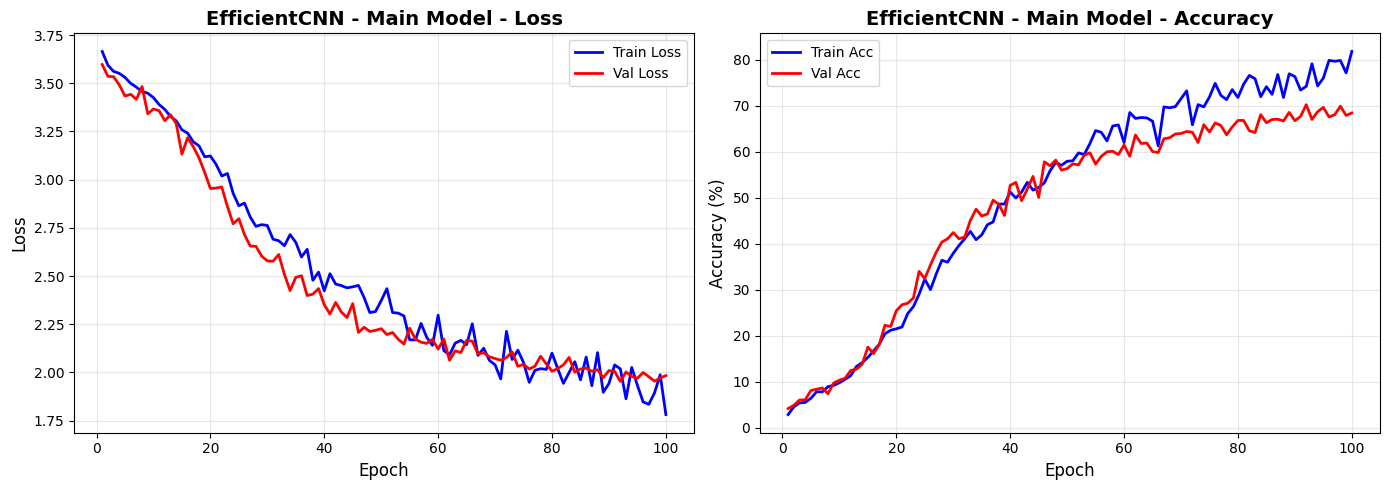

Added: EfficientCNN - Main Model | Test Acc: 71.56% | Params: 2.0M


In [26]:
# Run baseline experiment
run_experiment(
    config=config_main,
    model_name="EfficientCNN - Main Model",
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=DEVICE,
    num_classes=NUM_CLASSES,
    tracker=tracker
)

The full model achieves the highest test accuracy with stable convergence and a small train–validation gap indicating controlled overfitting. Therfore, the combined use of the implied techniques provides an effective balance between capacity and regularization, allowing to train effectivly our compact model in just 100 epochs.

### Ablation study
In this section, we conduct an ablation study to evaluate the contribution of each component in achieving the final performance of the full model.

In particular, we are going to conduct the following tests:
1. Remove residual connections.
2. Disable stochastic depth block.
3. Use weaker data augmentation strategy.
4. Use cross-entroy loss without label smoothing.
5. Replace depthwise separable convolutions with standard convolutions.

#### First test: removing residial connections


EXPERIMENT: EfficientCNN - No Residual Connections

Epoch 1/100
------------------------------------------------------------


Train Loss: 3.6697 | Train Acc: 2.62% | Time: 25.23s
Val Loss: 3.6214 | Val Acc: 4.74% | Time: 5.24s

Epoch 2/100
------------------------------------------------------------


Train Loss: 3.5922 | Train Acc: 3.98% | Time: 25.75s
Val Loss: 3.5878 | Val Acc: 4.85% | Time: 5.40s

Epoch 3/100
------------------------------------------------------------


Train Loss: 3.5626 | Train Acc: 4.72% | Time: 25.89s
Val Loss: 3.5133 | Val Acc: 6.05% | Time: 5.57s

Epoch 4/100
------------------------------------------------------------


Train Loss: 3.5401 | Train Acc: 5.23% | Time: 25.77s
Val Loss: 3.5457 | Val Acc: 5.29% | Time: 5.50s

Epoch 5/100
------------------------------------------------------------


Train Loss: 3.5180 | Train Acc: 6.32% | Time: 25.87s
Val Loss: 3.4643 | Val Acc: 8.02% | Time: 5.44s

Epoch 6/100
------------------------------------------------------------


Train Loss: 3.5064 | Train Acc: 6.54% | Time: 25.81s
Val Loss: 3.4761 | Val Acc: 7.14% | Time: 5.40s

Epoch 7/100
------------------------------------------------------------


Train Loss: 3.5015 | Train Acc: 8.12% | Time: 26.11s
Val Loss: 3.4709 | Val Acc: 7.91% | Time: 5.27s

Epoch 8/100
------------------------------------------------------------


Train Loss: 3.4921 | Train Acc: 7.28% | Time: 26.75s
Val Loss: 3.4097 | Val Acc: 9.81% | Time: 5.41s

Epoch 9/100
------------------------------------------------------------


Train Loss: 3.4628 | Train Acc: 7.90% | Time: 26.05s
Val Loss: 3.4405 | Val Acc: 9.38% | Time: 5.22s

Epoch 10/100
------------------------------------------------------------


Train Loss: 3.4396 | Train Acc: 9.70% | Time: 26.66s
Val Loss: 3.4627 | Val Acc: 7.91% | Time: 5.36s

Epoch 11/100
------------------------------------------------------------


Train Loss: 3.4342 | Train Acc: 9.21% | Time: 25.95s
Val Loss: 3.3775 | Val Acc: 10.80% | Time: 5.26s

Epoch 12/100
------------------------------------------------------------


Train Loss: 3.4327 | Train Acc: 10.38% | Time: 26.03s
Val Loss: 3.3558 | Val Acc: 11.23% | Time: 5.62s

Epoch 13/100
------------------------------------------------------------


Train Loss: 3.4232 | Train Acc: 10.28% | Time: 25.90s
Val Loss: 3.4129 | Val Acc: 10.09% | Time: 5.48s

Epoch 14/100
------------------------------------------------------------


Train Loss: 3.3857 | Train Acc: 10.77% | Time: 26.09s
Val Loss: 3.3003 | Val Acc: 11.67% | Time: 5.29s

Epoch 15/100
------------------------------------------------------------


Train Loss: 3.3716 | Train Acc: 10.96% | Time: 25.57s
Val Loss: 3.3213 | Val Acc: 12.27% | Time: 5.38s

Epoch 16/100
------------------------------------------------------------


Train Loss: 3.3471 | Train Acc: 11.94% | Time: 25.60s
Val Loss: 3.3791 | Val Acc: 10.47% | Time: 5.36s

Epoch 17/100
------------------------------------------------------------


Train Loss: 3.3587 | Train Acc: 11.72% | Time: 25.74s
Val Loss: 3.2329 | Val Acc: 14.72% | Time: 5.33s

Epoch 18/100
------------------------------------------------------------


Train Loss: 3.3616 | Train Acc: 12.67% | Time: 25.99s
Val Loss: 3.2987 | Val Acc: 12.98% | Time: 5.20s

Epoch 19/100
------------------------------------------------------------


Train Loss: 3.3223 | Train Acc: 13.25% | Time: 25.72s
Val Loss: 3.2878 | Val Acc: 13.41% | Time: 5.36s

Epoch 20/100
------------------------------------------------------------


Train Loss: 3.2983 | Train Acc: 13.79% | Time: 26.40s
Val Loss: 3.2612 | Val Acc: 14.67% | Time: 5.56s

Epoch 21/100
------------------------------------------------------------


Train Loss: 3.2922 | Train Acc: 13.90% | Time: 25.59s
Val Loss: 3.2127 | Val Acc: 15.16% | Time: 5.47s

Epoch 22/100
------------------------------------------------------------


Train Loss: 3.2634 | Train Acc: 16.79% | Time: 25.91s
Val Loss: 3.2322 | Val Acc: 16.47% | Time: 5.38s

Epoch 23/100
------------------------------------------------------------


Train Loss: 3.2620 | Train Acc: 15.02% | Time: 25.99s
Val Loss: 3.1541 | Val Acc: 18.10% | Time: 5.57s

Epoch 24/100
------------------------------------------------------------


Train Loss: 3.2071 | Train Acc: 16.49% | Time: 25.82s
Val Loss: 3.1851 | Val Acc: 16.74% | Time: 5.49s

Epoch 25/100
------------------------------------------------------------


Train Loss: 3.2307 | Train Acc: 16.63% | Time: 25.97s
Val Loss: 3.1179 | Val Acc: 18.59% | Time: 5.34s

Epoch 26/100
------------------------------------------------------------


Train Loss: 3.1730 | Train Acc: 19.98% | Time: 25.73s
Val Loss: 3.2234 | Val Acc: 15.21% | Time: 5.27s

Epoch 27/100
------------------------------------------------------------


Train Loss: 3.1833 | Train Acc: 18.34% | Time: 26.26s
Val Loss: 3.1626 | Val Acc: 17.45% | Time: 5.44s

Epoch 28/100
------------------------------------------------------------


Train Loss: 3.1913 | Train Acc: 18.42% | Time: 25.73s
Val Loss: 3.0882 | Val Acc: 18.97% | Time: 5.35s

Epoch 29/100
------------------------------------------------------------


Train Loss: 3.1226 | Train Acc: 20.33% | Time: 25.39s
Val Loss: 3.0903 | Val Acc: 19.90% | Time: 5.42s

Epoch 30/100
------------------------------------------------------------


Train Loss: 3.1103 | Train Acc: 19.90% | Time: 25.39s
Val Loss: 3.0282 | Val Acc: 23.94% | Time: 5.45s

Epoch 31/100
------------------------------------------------------------


Train Loss: 3.0964 | Train Acc: 21.59% | Time: 26.26s
Val Loss: 2.9982 | Val Acc: 24.37% | Time: 5.57s

Epoch 32/100
------------------------------------------------------------


Train Loss: 3.0754 | Train Acc: 24.01% | Time: 25.69s
Val Loss: 2.9548 | Val Acc: 24.86% | Time: 5.43s

Epoch 33/100
------------------------------------------------------------


Train Loss: 3.0307 | Train Acc: 25.10% | Time: 25.90s
Val Loss: 2.9522 | Val Acc: 26.94% | Time: 5.40s

Epoch 34/100
------------------------------------------------------------


Train Loss: 3.0383 | Train Acc: 24.28% | Time: 25.50s
Val Loss: 2.8268 | Val Acc: 31.84% | Time: 5.56s

Epoch 35/100
------------------------------------------------------------


Train Loss: 2.9590 | Train Acc: 26.98% | Time: 25.75s
Val Loss: 2.8787 | Val Acc: 26.99% | Time: 5.47s

Epoch 36/100
------------------------------------------------------------


Train Loss: 3.0371 | Train Acc: 25.87% | Time: 25.83s
Val Loss: 2.8256 | Val Acc: 30.10% | Time: 5.46s

Epoch 37/100
------------------------------------------------------------


Train Loss: 2.8898 | Train Acc: 29.84% | Time: 25.51s
Val Loss: 2.8902 | Val Acc: 28.35% | Time: 5.33s

Epoch 38/100
------------------------------------------------------------


Train Loss: 2.9494 | Train Acc: 29.71% | Time: 25.69s
Val Loss: 2.7754 | Val Acc: 31.03% | Time: 5.43s

Epoch 39/100
------------------------------------------------------------


Train Loss: 2.8909 | Train Acc: 30.17% | Time: 25.68s
Val Loss: 2.7937 | Val Acc: 31.13% | Time: 5.33s

Epoch 40/100
------------------------------------------------------------


Train Loss: 2.9111 | Train Acc: 30.91% | Time: 25.97s
Val Loss: 2.7246 | Val Acc: 34.35% | Time: 5.34s

Epoch 41/100
------------------------------------------------------------


Train Loss: 2.8417 | Train Acc: 32.82% | Time: 25.82s
Val Loss: 2.7187 | Val Acc: 32.33% | Time: 5.52s

Epoch 42/100
------------------------------------------------------------


Train Loss: 2.8465 | Train Acc: 32.49% | Time: 25.33s
Val Loss: 2.7715 | Val Acc: 32.06% | Time: 5.43s

Epoch 43/100
------------------------------------------------------------


Train Loss: 2.7839 | Train Acc: 34.45% | Time: 25.69s
Val Loss: 2.6607 | Val Acc: 35.77% | Time: 5.34s

Epoch 44/100
------------------------------------------------------------


Train Loss: 2.8368 | Train Acc: 35.05% | Time: 25.87s
Val Loss: 2.6826 | Val Acc: 36.31% | Time: 5.34s

Epoch 45/100
------------------------------------------------------------


Train Loss: 2.8226 | Train Acc: 34.94% | Time: 25.43s
Val Loss: 2.7224 | Val Acc: 35.17% | Time: 5.27s

Epoch 46/100
------------------------------------------------------------


Train Loss: 2.7549 | Train Acc: 37.39% | Time: 25.97s
Val Loss: 2.6272 | Val Acc: 38.55% | Time: 5.44s

Epoch 47/100
------------------------------------------------------------


Train Loss: 2.7275 | Train Acc: 37.69% | Time: 26.13s
Val Loss: 2.6392 | Val Acc: 36.31% | Time: 5.49s

Epoch 48/100
------------------------------------------------------------


Train Loss: 2.6285 | Train Acc: 40.53% | Time: 25.94s
Val Loss: 2.5785 | Val Acc: 40.29% | Time: 5.59s

Epoch 49/100
------------------------------------------------------------


Train Loss: 2.7193 | Train Acc: 38.43% | Time: 25.73s
Val Loss: 2.5782 | Val Acc: 40.08% | Time: 5.28s

Epoch 50/100
------------------------------------------------------------


Train Loss: 2.7256 | Train Acc: 38.68% | Time: 25.51s
Val Loss: 2.6004 | Val Acc: 39.48% | Time: 5.41s

Epoch 51/100
------------------------------------------------------------


Train Loss: 2.6973 | Train Acc: 40.67% | Time: 25.40s
Val Loss: 2.5078 | Val Acc: 42.64% | Time: 5.29s

Epoch 52/100
------------------------------------------------------------


Train Loss: 2.7004 | Train Acc: 39.77% | Time: 25.93s
Val Loss: 2.5000 | Val Acc: 43.08% | Time: 5.24s

Epoch 53/100
------------------------------------------------------------


Train Loss: 2.6688 | Train Acc: 42.60% | Time: 25.50s
Val Loss: 2.5685 | Val Acc: 40.73% | Time: 5.39s

Epoch 54/100
------------------------------------------------------------


Train Loss: 2.5964 | Train Acc: 43.64% | Time: 25.50s
Val Loss: 2.5370 | Val Acc: 42.20% | Time: 5.28s

Epoch 55/100
------------------------------------------------------------


Train Loss: 2.5524 | Train Acc: 45.08% | Time: 25.36s
Val Loss: 2.5233 | Val Acc: 42.69% | Time: 5.21s

Epoch 56/100
------------------------------------------------------------


Train Loss: 2.6115 | Train Acc: 43.25% | Time: 25.48s
Val Loss: 2.4718 | Val Acc: 44.66% | Time: 5.32s

Epoch 57/100
------------------------------------------------------------


Train Loss: 2.5792 | Train Acc: 44.84% | Time: 25.37s
Val Loss: 2.5125 | Val Acc: 42.86% | Time: 5.50s

Epoch 58/100
------------------------------------------------------------


Train Loss: 2.5901 | Train Acc: 45.33% | Time: 25.75s
Val Loss: 2.4756 | Val Acc: 43.73% | Time: 5.35s

Epoch 59/100
------------------------------------------------------------


Train Loss: 2.5409 | Train Acc: 45.16% | Time: 25.58s
Val Loss: 2.4511 | Val Acc: 45.20% | Time: 5.41s

Epoch 60/100
------------------------------------------------------------


Train Loss: 2.5253 | Train Acc: 46.17% | Time: 25.56s
Val Loss: 2.4779 | Val Acc: 45.20% | Time: 5.27s

Epoch 61/100
------------------------------------------------------------


Train Loss: 2.6214 | Train Acc: 45.33% | Time: 25.47s
Val Loss: 2.4315 | Val Acc: 46.07% | Time: 5.48s

Epoch 62/100
------------------------------------------------------------


Train Loss: 2.4866 | Train Acc: 48.11% | Time: 25.89s
Val Loss: 2.4034 | Val Acc: 47.55% | Time: 5.45s

Epoch 63/100
------------------------------------------------------------


Train Loss: 2.5735 | Train Acc: 45.63% | Time: 25.71s
Val Loss: 2.3487 | Val Acc: 50.55% | Time: 5.45s

Epoch 64/100
------------------------------------------------------------


Train Loss: 2.4779 | Train Acc: 49.36% | Time: 25.69s
Val Loss: 2.3703 | Val Acc: 48.26% | Time: 5.27s

Epoch 65/100
------------------------------------------------------------


Train Loss: 2.5267 | Train Acc: 48.02% | Time: 25.81s
Val Loss: 2.3305 | Val Acc: 50.98% | Time: 5.33s

Epoch 66/100
------------------------------------------------------------


Train Loss: 2.4858 | Train Acc: 49.82% | Time: 25.89s
Val Loss: 2.3701 | Val Acc: 48.80% | Time: 5.27s

Epoch 67/100
------------------------------------------------------------


Train Loss: 2.5908 | Train Acc: 48.11% | Time: 25.76s
Val Loss: 2.3948 | Val Acc: 48.15% | Time: 5.31s

Epoch 68/100
------------------------------------------------------------


Train Loss: 2.6437 | Train Acc: 46.63% | Time: 25.76s
Val Loss: 2.3742 | Val Acc: 48.58% | Time: 5.28s

Epoch 69/100
------------------------------------------------------------


Train Loss: 2.4135 | Train Acc: 52.79% | Time: 25.38s
Val Loss: 2.3378 | Val Acc: 50.27% | Time: 5.52s

Epoch 70/100
------------------------------------------------------------


Train Loss: 2.4036 | Train Acc: 52.79% | Time: 25.75s
Val Loss: 2.3527 | Val Acc: 49.89% | Time: 5.34s

Epoch 71/100
------------------------------------------------------------


Train Loss: 2.4822 | Train Acc: 49.90% | Time: 25.54s
Val Loss: 2.3543 | Val Acc: 49.45% | Time: 5.33s

Epoch 72/100
------------------------------------------------------------


Train Loss: 2.3759 | Train Acc: 54.05% | Time: 25.80s
Val Loss: 2.3669 | Val Acc: 49.95% | Time: 5.47s

Epoch 73/100
------------------------------------------------------------


Train Loss: 2.3901 | Train Acc: 53.75% | Time: 25.32s
Val Loss: 2.3163 | Val Acc: 51.31% | Time: 5.24s

Epoch 74/100
------------------------------------------------------------


Train Loss: 2.3865 | Train Acc: 52.88% | Time: 25.59s
Val Loss: 2.3817 | Val Acc: 50.65% | Time: 5.34s

Epoch 75/100
------------------------------------------------------------


Train Loss: 2.4578 | Train Acc: 53.09% | Time: 25.29s
Val Loss: 2.2802 | Val Acc: 54.47% | Time: 5.47s

Epoch 76/100
------------------------------------------------------------


Train Loss: 2.3405 | Train Acc: 55.27% | Time: 25.96s
Val Loss: 2.3318 | Val Acc: 50.60% | Time: 5.30s

Epoch 77/100
------------------------------------------------------------


Train Loss: 2.3536 | Train Acc: 56.12% | Time: 25.33s
Val Loss: 2.3988 | Val Acc: 48.04% | Time: 5.47s

Epoch 78/100
------------------------------------------------------------


Train Loss: 2.5371 | Train Acc: 51.59% | Time: 25.74s
Val Loss: 2.2644 | Val Acc: 55.45% | Time: 5.26s

Epoch 79/100
------------------------------------------------------------


Train Loss: 2.3558 | Train Acc: 54.76% | Time: 26.06s
Val Loss: 2.2355 | Val Acc: 54.53% | Time: 5.36s

Epoch 80/100
------------------------------------------------------------


Train Loss: 2.3784 | Train Acc: 55.27% | Time: 25.65s
Val Loss: 2.3043 | Val Acc: 52.56% | Time: 5.43s

Epoch 81/100
------------------------------------------------------------


Train Loss: 2.3057 | Train Acc: 56.69% | Time: 25.90s
Val Loss: 2.3481 | Val Acc: 50.55% | Time: 5.38s

Epoch 82/100
------------------------------------------------------------


Train Loss: 2.3363 | Train Acc: 56.42% | Time: 25.69s
Val Loss: 2.1973 | Val Acc: 56.76% | Time: 5.22s

Epoch 83/100
------------------------------------------------------------


Train Loss: 2.2817 | Train Acc: 58.16% | Time: 25.82s
Val Loss: 2.2299 | Val Acc: 56.27% | Time: 5.32s

Epoch 84/100
------------------------------------------------------------


Train Loss: 2.2391 | Train Acc: 58.84% | Time: 25.99s
Val Loss: 2.2773 | Val Acc: 55.13% | Time: 5.33s

Epoch 85/100
------------------------------------------------------------


Train Loss: 2.3554 | Train Acc: 57.15% | Time: 25.88s
Val Loss: 2.2553 | Val Acc: 54.85% | Time: 5.27s

Epoch 86/100
------------------------------------------------------------


Train Loss: 2.3539 | Train Acc: 56.39% | Time: 25.57s
Val Loss: 2.2695 | Val Acc: 54.63% | Time: 5.20s

Epoch 87/100
------------------------------------------------------------


Train Loss: 2.4078 | Train Acc: 54.67% | Time: 25.50s
Val Loss: 2.1931 | Val Acc: 58.02% | Time: 5.22s

Epoch 88/100
------------------------------------------------------------


Train Loss: 2.2894 | Train Acc: 59.50% | Time: 25.82s
Val Loss: 2.1712 | Val Acc: 58.07% | Time: 5.32s

Epoch 89/100
------------------------------------------------------------


Train Loss: 2.2137 | Train Acc: 62.66% | Time: 25.60s
Val Loss: 2.1987 | Val Acc: 58.34% | Time: 5.45s

Epoch 90/100
------------------------------------------------------------


Train Loss: 2.2329 | Train Acc: 59.74% | Time: 25.79s
Val Loss: 2.2200 | Val Acc: 56.65% | Time: 5.35s

Epoch 91/100
------------------------------------------------------------


Train Loss: 2.4113 | Train Acc: 55.38% | Time: 25.45s
Val Loss: 2.1872 | Val Acc: 57.80% | Time: 5.28s

Epoch 92/100
------------------------------------------------------------


Train Loss: 2.3129 | Train Acc: 59.61% | Time: 25.59s
Val Loss: 2.2659 | Val Acc: 52.56% | Time: 5.32s

Epoch 93/100
------------------------------------------------------------


Train Loss: 2.3429 | Train Acc: 57.54% | Time: 26.38s
Val Loss: 2.2987 | Val Acc: 53.76% | Time: 5.47s

Epoch 94/100
------------------------------------------------------------


Train Loss: 2.1816 | Train Acc: 64.10% | Time: 25.51s
Val Loss: 2.1896 | Val Acc: 56.82% | Time: 5.27s

Epoch 95/100
------------------------------------------------------------


Train Loss: 2.1744 | Train Acc: 63.86% | Time: 25.74s
Val Loss: 2.1909 | Val Acc: 58.56% | Time: 5.27s

Epoch 96/100
------------------------------------------------------------


Train Loss: 2.2268 | Train Acc: 60.48% | Time: 25.63s
Val Loss: 2.2305 | Val Acc: 57.14% | Time: 5.49s

Epoch 97/100
------------------------------------------------------------


Train Loss: 2.1897 | Train Acc: 63.23% | Time: 25.81s
Val Loss: 2.2030 | Val Acc: 56.82% | Time: 5.36s

Epoch 98/100
------------------------------------------------------------


Train Loss: 2.2022 | Train Acc: 60.56% | Time: 25.55s
Val Loss: 2.2124 | Val Acc: 56.60% | Time: 5.28s

Epoch 99/100
------------------------------------------------------------


Train Loss: 2.2932 | Train Acc: 61.38% | Time: 25.68s
Val Loss: 2.1882 | Val Acc: 56.82% | Time: 5.53s

Epoch 100/100
------------------------------------------------------------


Train Loss: 2.1582 | Train Acc: 64.16% | Time: 25.56s
Val Loss: 2.2548 | Val Acc: 54.74% | Time: 5.36s


Best Validation Accuracy: 58.56%
Total Training Time: 42.92 minutes
Average Training Time per Epoch: 25.75 seconds



FINAL TEST RESULTS:
  Accuracy: 61.54%
  Loss: 2.1072
  Total Test Time: 5.57s



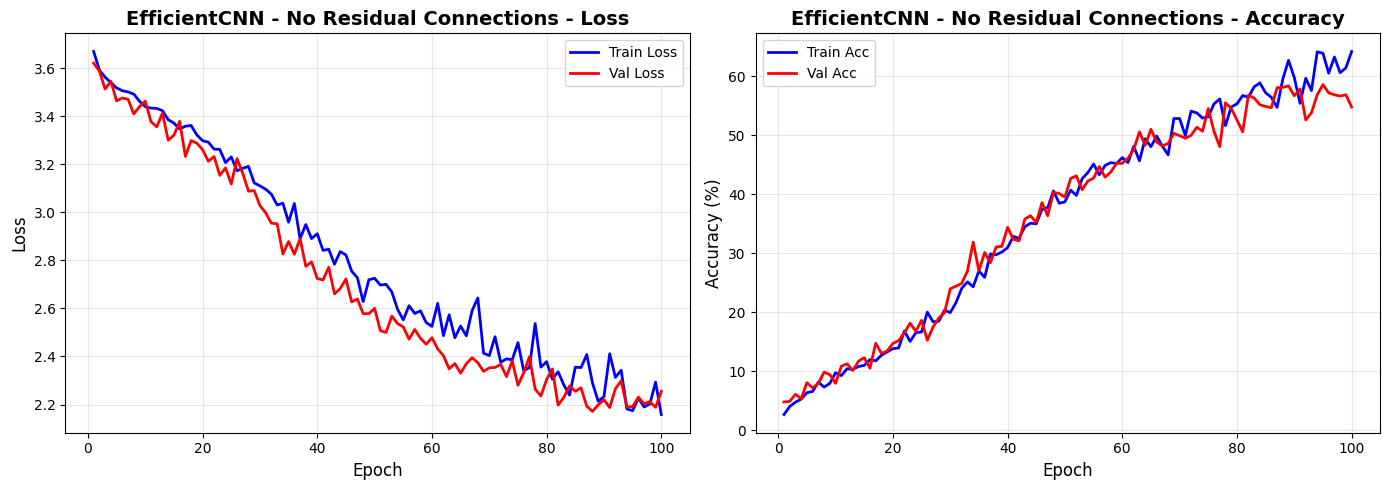

Added: EfficientCNN - No Residual Connections | Test Acc: 61.54% | Params: 2.0M


In [27]:
# No Residual Connections Experiment Configuration
config_no_res = ExperimentConfig(
    width_mult=0.75,
    depth_mult=0.8,
    dropout_rate=0.4,
    drop_path_rate=0.2,
    use_depthwise=True,
    use_residual=False,  # Disable residual connections
    cutmix_prob=0.15,
    mixup_prob=0.15,
    label_smoothing=0.2,
    lr=1e-3,
    weight_decay=2e-4,
    optimizer="AdamW"
)

# Run ablation test
run_experiment(
    config=config_no_res,
    model_name="EfficientCNN - No Residual Connections",
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=DEVICE,
    num_classes=NUM_CLASSES,
    tracker=tracker
)

Removing residual connections degrades feature reuse, leading to slower convergence and an accuracy drop to 61.54%, highlighting their critical role in stabilizing deep feature learning.

#### Second test: disabling stochastic depth block


EXPERIMENT: EfficientCNN - No Stochastic Depth

Epoch 1/100
------------------------------------------------------------


Train Loss: 3.6527 | Train Acc: 3.16% | Time: 26.29s
Val Loss: 3.6437 | Val Acc: 4.63% | Time: 5.31s

Epoch 2/100
------------------------------------------------------------


Train Loss: 3.5743 | Train Acc: 5.21% | Time: 25.59s
Val Loss: 3.5294 | Val Acc: 6.16% | Time: 5.28s

Epoch 3/100
------------------------------------------------------------


Train Loss: 3.5262 | Train Acc: 6.43% | Time: 25.80s
Val Loss: 3.5227 | Val Acc: 7.85% | Time: 5.29s

Epoch 4/100
------------------------------------------------------------


Train Loss: 3.4792 | Train Acc: 8.04% | Time: 25.85s
Val Loss: 3.6276 | Val Acc: 6.49% | Time: 5.19s

Epoch 5/100
------------------------------------------------------------


Train Loss: 3.4667 | Train Acc: 7.96% | Time: 25.93s
Val Loss: 3.5032 | Val Acc: 9.21% | Time: 5.28s

Epoch 6/100
------------------------------------------------------------


Train Loss: 3.4382 | Train Acc: 8.72% | Time: 25.80s
Val Loss: 3.3605 | Val Acc: 10.47% | Time: 5.56s

Epoch 7/100
------------------------------------------------------------


Train Loss: 3.3826 | Train Acc: 11.15% | Time: 25.92s
Val Loss: 3.4134 | Val Acc: 11.50% | Time: 5.53s

Epoch 8/100
------------------------------------------------------------


Train Loss: 3.3758 | Train Acc: 12.67% | Time: 25.71s
Val Loss: 3.3629 | Val Acc: 11.23% | Time: 5.31s

Epoch 9/100
------------------------------------------------------------


Train Loss: 3.3287 | Train Acc: 13.79% | Time: 25.72s
Val Loss: 3.3241 | Val Acc: 15.16% | Time: 5.27s

Epoch 10/100
------------------------------------------------------------


Train Loss: 3.3150 | Train Acc: 14.36% | Time: 26.25s
Val Loss: 3.2010 | Val Acc: 16.96% | Time: 5.32s

Epoch 11/100
------------------------------------------------------------


Train Loss: 3.2797 | Train Acc: 15.59% | Time: 25.51s
Val Loss: 3.2293 | Val Acc: 16.41% | Time: 5.28s

Epoch 12/100
------------------------------------------------------------


Train Loss: 3.2566 | Train Acc: 16.84% | Time: 25.77s
Val Loss: 3.1458 | Val Acc: 17.88% | Time: 5.38s

Epoch 13/100
------------------------------------------------------------


Train Loss: 3.2330 | Train Acc: 17.20% | Time: 26.00s
Val Loss: 3.1918 | Val Acc: 18.05% | Time: 5.42s

Epoch 14/100
------------------------------------------------------------


Train Loss: 3.1761 | Train Acc: 19.49% | Time: 25.85s
Val Loss: 3.2117 | Val Acc: 17.83% | Time: 5.43s

Epoch 15/100
------------------------------------------------------------


Train Loss: 3.1402 | Train Acc: 21.15% | Time: 25.95s
Val Loss: 3.0375 | Val Acc: 21.70% | Time: 5.40s

Epoch 16/100
------------------------------------------------------------


Train Loss: 3.1510 | Train Acc: 20.66% | Time: 25.57s
Val Loss: 3.0222 | Val Acc: 22.14% | Time: 5.28s

Epoch 17/100
------------------------------------------------------------


Train Loss: 3.0870 | Train Acc: 22.73% | Time: 25.26s
Val Loss: 2.9612 | Val Acc: 26.01% | Time: 5.36s

Epoch 18/100
------------------------------------------------------------


Train Loss: 2.9895 | Train Acc: 26.52% | Time: 25.50s
Val Loss: 2.8576 | Val Acc: 31.62% | Time: 5.54s

Epoch 19/100
------------------------------------------------------------


Train Loss: 2.9466 | Train Acc: 29.38% | Time: 25.67s
Val Loss: 2.8494 | Val Acc: 28.90% | Time: 5.26s

Epoch 20/100
------------------------------------------------------------


Train Loss: 2.9169 | Train Acc: 29.19% | Time: 25.66s
Val Loss: 2.7790 | Val Acc: 34.24% | Time: 5.37s

Epoch 21/100
------------------------------------------------------------


Train Loss: 2.8596 | Train Acc: 33.22% | Time: 25.73s
Val Loss: 2.8712 | Val Acc: 31.30% | Time: 5.33s

Epoch 22/100
------------------------------------------------------------


Train Loss: 2.9101 | Train Acc: 32.60% | Time: 25.64s
Val Loss: 2.7050 | Val Acc: 35.82% | Time: 5.37s

Epoch 23/100
------------------------------------------------------------


Train Loss: 2.8246 | Train Acc: 34.89% | Time: 25.41s
Val Loss: 2.7456 | Val Acc: 33.86% | Time: 5.21s

Epoch 24/100
------------------------------------------------------------


Train Loss: 2.8845 | Train Acc: 33.28% | Time: 25.37s
Val Loss: 2.7019 | Val Acc: 37.68% | Time: 5.32s

Epoch 25/100
------------------------------------------------------------


Train Loss: 2.8296 | Train Acc: 36.20% | Time: 25.91s
Val Loss: 2.6115 | Val Acc: 40.02% | Time: 5.32s

Epoch 26/100
------------------------------------------------------------


Train Loss: 2.7684 | Train Acc: 38.92% | Time: 26.78s
Val Loss: 2.6287 | Val Acc: 40.95% | Time: 5.66s

Epoch 27/100
------------------------------------------------------------


Train Loss: 2.7353 | Train Acc: 37.99% | Time: 26.24s
Val Loss: 2.5864 | Val Acc: 40.84% | Time: 5.57s

Epoch 28/100
------------------------------------------------------------


Train Loss: 2.6650 | Train Acc: 41.97% | Time: 26.12s
Val Loss: 2.5965 | Val Acc: 39.80% | Time: 5.34s

Epoch 29/100
------------------------------------------------------------


Train Loss: 2.6827 | Train Acc: 40.50% | Time: 26.14s
Val Loss: 2.5291 | Val Acc: 43.51% | Time: 5.36s

Epoch 30/100
------------------------------------------------------------


Train Loss: 2.5801 | Train Acc: 46.50% | Time: 26.00s
Val Loss: 2.5255 | Val Acc: 41.93% | Time: 5.27s

Epoch 31/100
------------------------------------------------------------


Train Loss: 2.6048 | Train Acc: 44.34% | Time: 25.50s
Val Loss: 2.4983 | Val Acc: 45.75% | Time: 5.36s

Epoch 32/100
------------------------------------------------------------


Train Loss: 2.5638 | Train Acc: 46.36% | Time: 25.75s
Val Loss: 2.5416 | Val Acc: 43.13% | Time: 5.48s

Epoch 33/100
------------------------------------------------------------


Train Loss: 2.6242 | Train Acc: 44.86% | Time: 25.47s
Val Loss: 2.5203 | Val Acc: 44.87% | Time: 5.38s

Epoch 34/100
------------------------------------------------------------


Train Loss: 2.5499 | Train Acc: 46.99% | Time: 26.14s
Val Loss: 2.4609 | Val Acc: 46.89% | Time: 5.43s

Epoch 35/100
------------------------------------------------------------


Train Loss: 2.5089 | Train Acc: 50.67% | Time: 25.84s
Val Loss: 2.4200 | Val Acc: 49.56% | Time: 5.42s

Epoch 36/100
------------------------------------------------------------


Train Loss: 2.5511 | Train Acc: 48.84% | Time: 25.38s
Val Loss: 2.4665 | Val Acc: 45.97% | Time: 5.38s

Epoch 37/100
------------------------------------------------------------


Train Loss: 2.5576 | Train Acc: 48.60% | Time: 25.57s
Val Loss: 2.3859 | Val Acc: 49.89% | Time: 5.27s

Epoch 38/100
------------------------------------------------------------


Train Loss: 2.4703 | Train Acc: 52.74% | Time: 25.47s
Val Loss: 2.3745 | Val Acc: 50.98% | Time: 5.32s

Epoch 39/100
------------------------------------------------------------


Train Loss: 2.5385 | Train Acc: 48.90% | Time: 25.32s
Val Loss: 2.3589 | Val Acc: 52.45% | Time: 5.25s

Epoch 40/100
------------------------------------------------------------


Train Loss: 2.4239 | Train Acc: 52.58% | Time: 25.37s
Val Loss: 2.3339 | Val Acc: 51.64% | Time: 5.30s

Epoch 41/100
------------------------------------------------------------


Train Loss: 2.3654 | Train Acc: 54.78% | Time: 25.95s
Val Loss: 2.3346 | Val Acc: 52.40% | Time: 5.38s

Epoch 42/100
------------------------------------------------------------


Train Loss: 2.3779 | Train Acc: 56.39% | Time: 25.64s
Val Loss: 2.3226 | Val Acc: 51.80% | Time: 5.36s

Epoch 43/100
------------------------------------------------------------


Train Loss: 2.3238 | Train Acc: 56.04% | Time: 25.80s
Val Loss: 2.3283 | Val Acc: 53.27% | Time: 5.30s

Epoch 44/100
------------------------------------------------------------


Train Loss: 2.3780 | Train Acc: 55.49% | Time: 25.43s
Val Loss: 2.3679 | Val Acc: 51.64% | Time: 5.29s

Epoch 45/100
------------------------------------------------------------


Train Loss: 2.3188 | Train Acc: 57.37% | Time: 26.05s
Val Loss: 2.3523 | Val Acc: 51.31% | Time: 5.39s

Epoch 46/100
------------------------------------------------------------


Train Loss: 2.2903 | Train Acc: 57.59% | Time: 25.62s
Val Loss: 2.2545 | Val Acc: 55.78% | Time: 5.41s

Epoch 47/100
------------------------------------------------------------


Train Loss: 2.3360 | Train Acc: 58.76% | Time: 26.04s
Val Loss: 2.3060 | Val Acc: 53.82% | Time: 5.33s

Epoch 48/100
------------------------------------------------------------


Train Loss: 2.3071 | Train Acc: 60.94% | Time: 25.52s
Val Loss: 2.2628 | Val Acc: 55.89% | Time: 5.38s

Epoch 49/100
------------------------------------------------------------


Train Loss: 2.2859 | Train Acc: 60.34% | Time: 25.56s
Val Loss: 2.2489 | Val Acc: 56.00% | Time: 5.30s

Epoch 50/100
------------------------------------------------------------


Train Loss: 2.2452 | Train Acc: 61.68% | Time: 25.66s
Val Loss: 2.2782 | Val Acc: 55.94% | Time: 5.41s

Epoch 51/100
------------------------------------------------------------


Train Loss: 2.3107 | Train Acc: 60.48% | Time: 25.58s
Val Loss: 2.2195 | Val Acc: 57.96% | Time: 5.29s

Epoch 52/100
------------------------------------------------------------


Train Loss: 2.1504 | Train Acc: 64.84% | Time: 25.45s
Val Loss: 2.2037 | Val Acc: 58.18% | Time: 5.42s

Epoch 53/100
------------------------------------------------------------


Train Loss: 2.1600 | Train Acc: 65.22% | Time: 25.74s
Val Loss: 2.2168 | Val Acc: 57.52% | Time: 5.33s

Epoch 54/100
------------------------------------------------------------


Train Loss: 2.3419 | Train Acc: 58.46% | Time: 26.27s
Val Loss: 2.2454 | Val Acc: 56.98% | Time: 5.49s

Epoch 55/100
------------------------------------------------------------


Train Loss: 2.2561 | Train Acc: 63.01% | Time: 26.03s
Val Loss: 2.2151 | Val Acc: 58.62% | Time: 5.31s

Epoch 56/100
------------------------------------------------------------


Train Loss: 2.1816 | Train Acc: 64.70% | Time: 26.10s
Val Loss: 2.2050 | Val Acc: 59.54% | Time: 5.35s

Epoch 57/100
------------------------------------------------------------


Train Loss: 2.2579 | Train Acc: 63.86% | Time: 25.94s
Val Loss: 2.1750 | Val Acc: 60.20% | Time: 5.35s

Epoch 58/100
------------------------------------------------------------


Train Loss: 2.2050 | Train Acc: 65.82% | Time: 25.32s
Val Loss: 2.1636 | Val Acc: 59.65% | Time: 5.38s

Epoch 59/100
------------------------------------------------------------


Train Loss: 2.1873 | Train Acc: 64.87% | Time: 25.45s
Val Loss: 2.1820 | Val Acc: 58.56% | Time: 5.27s

Epoch 60/100
------------------------------------------------------------


Train Loss: 2.1796 | Train Acc: 65.49% | Time: 25.76s
Val Loss: 2.1141 | Val Acc: 62.16% | Time: 5.40s

Epoch 61/100
------------------------------------------------------------


Train Loss: 2.0366 | Train Acc: 69.91% | Time: 25.85s
Val Loss: 2.1575 | Val Acc: 60.20% | Time: 5.41s

Epoch 62/100
------------------------------------------------------------


Train Loss: 2.0043 | Train Acc: 71.98% | Time: 26.15s
Val Loss: 2.1640 | Val Acc: 61.23% | Time: 5.48s

Epoch 63/100
------------------------------------------------------------


Train Loss: 2.1723 | Train Acc: 67.02% | Time: 25.41s
Val Loss: 2.1251 | Val Acc: 61.94% | Time: 5.50s

Epoch 64/100
------------------------------------------------------------


Train Loss: 2.0777 | Train Acc: 69.17% | Time: 25.56s
Val Loss: 2.1162 | Val Acc: 62.10% | Time: 5.35s

Epoch 65/100
------------------------------------------------------------


Train Loss: 2.0394 | Train Acc: 70.51% | Time: 25.81s
Val Loss: 2.1178 | Val Acc: 62.00% | Time: 5.31s

Epoch 66/100
------------------------------------------------------------


Train Loss: 2.0513 | Train Acc: 72.25% | Time: 25.96s
Val Loss: 2.2045 | Val Acc: 58.34% | Time: 5.47s

Epoch 67/100
------------------------------------------------------------


Train Loss: 2.0686 | Train Acc: 71.16% | Time: 25.86s
Val Loss: 2.1187 | Val Acc: 62.60% | Time: 5.41s

Epoch 68/100
------------------------------------------------------------


Train Loss: 2.0954 | Train Acc: 68.68% | Time: 25.72s
Val Loss: 2.1095 | Val Acc: 62.87% | Time: 5.35s

Epoch 69/100
------------------------------------------------------------


Train Loss: 1.9912 | Train Acc: 71.90% | Time: 25.70s
Val Loss: 2.1161 | Val Acc: 60.80% | Time: 5.39s

Epoch 70/100
------------------------------------------------------------


Train Loss: 2.0578 | Train Acc: 69.86% | Time: 26.22s
Val Loss: 2.1444 | Val Acc: 61.18% | Time: 5.39s

Epoch 71/100
------------------------------------------------------------


Train Loss: 2.0234 | Train Acc: 72.25% | Time: 26.09s
Val Loss: 2.1083 | Val Acc: 62.49% | Time: 5.33s

Epoch 72/100
------------------------------------------------------------


Train Loss: 2.1066 | Train Acc: 69.36% | Time: 26.07s
Val Loss: 2.1502 | Val Acc: 61.34% | Time: 5.33s

Epoch 73/100
------------------------------------------------------------


Train Loss: 1.9368 | Train Acc: 76.26% | Time: 25.51s
Val Loss: 2.0833 | Val Acc: 64.12% | Time: 5.25s

Epoch 74/100
------------------------------------------------------------


Train Loss: 2.0706 | Train Acc: 71.57% | Time: 26.23s
Val Loss: 2.1237 | Val Acc: 63.25% | Time: 5.42s

Epoch 75/100
------------------------------------------------------------


Train Loss: 2.0137 | Train Acc: 74.35% | Time: 25.76s
Val Loss: 2.1509 | Val Acc: 60.41% | Time: 5.37s

Epoch 76/100
------------------------------------------------------------


Train Loss: 1.9749 | Train Acc: 74.19% | Time: 25.89s
Val Loss: 2.1290 | Val Acc: 62.54% | Time: 5.45s

Epoch 77/100
------------------------------------------------------------


Train Loss: 2.0295 | Train Acc: 73.26% | Time: 26.23s
Val Loss: 2.1236 | Val Acc: 62.27% | Time: 5.47s

Epoch 78/100
------------------------------------------------------------


Train Loss: 1.9892 | Train Acc: 74.79% | Time: 25.85s
Val Loss: 2.1334 | Val Acc: 63.25% | Time: 5.57s

Epoch 79/100
------------------------------------------------------------


Train Loss: 2.0294 | Train Acc: 71.98% | Time: 26.18s
Val Loss: 2.0810 | Val Acc: 65.05% | Time: 5.40s

Epoch 80/100
------------------------------------------------------------


Train Loss: 1.9425 | Train Acc: 74.43% | Time: 25.94s
Val Loss: 2.0423 | Val Acc: 66.09% | Time: 5.45s

Epoch 81/100
------------------------------------------------------------


Train Loss: 2.0637 | Train Acc: 71.52% | Time: 25.93s
Val Loss: 2.0573 | Val Acc: 64.89% | Time: 5.36s

Epoch 82/100
------------------------------------------------------------


Train Loss: 1.9479 | Train Acc: 74.54% | Time: 25.83s
Val Loss: 2.0646 | Val Acc: 64.56% | Time: 5.32s

Epoch 83/100
------------------------------------------------------------


Train Loss: 1.9074 | Train Acc: 77.32% | Time: 26.15s
Val Loss: 2.0277 | Val Acc: 67.07% | Time: 5.32s

Epoch 84/100
------------------------------------------------------------


Train Loss: 1.8626 | Train Acc: 78.99% | Time: 25.96s
Val Loss: 2.0791 | Val Acc: 64.50% | Time: 5.32s

Epoch 85/100
------------------------------------------------------------


Train Loss: 1.9733 | Train Acc: 76.56% | Time: 25.57s
Val Loss: 2.0511 | Val Acc: 65.32% | Time: 5.39s

Epoch 86/100
------------------------------------------------------------


Train Loss: 2.0507 | Train Acc: 72.06% | Time: 25.42s
Val Loss: 2.1103 | Val Acc: 63.96% | Time: 5.38s

Epoch 87/100
------------------------------------------------------------


Train Loss: 1.9312 | Train Acc: 77.95% | Time: 26.22s
Val Loss: 2.0421 | Val Acc: 66.19% | Time: 5.50s

Epoch 88/100
------------------------------------------------------------


Train Loss: 2.0192 | Train Acc: 74.33% | Time: 25.65s
Val Loss: 2.0370 | Val Acc: 66.58% | Time: 5.35s

Epoch 89/100
------------------------------------------------------------


Train Loss: 2.1089 | Train Acc: 73.24% | Time: 25.94s
Val Loss: 2.0928 | Val Acc: 64.78% | Time: 5.34s

Epoch 90/100
------------------------------------------------------------


Train Loss: 1.9553 | Train Acc: 76.89% | Time: 25.58s
Val Loss: 2.0390 | Val Acc: 66.90% | Time: 5.29s

Epoch 91/100
------------------------------------------------------------


Train Loss: 1.8574 | Train Acc: 79.45% | Time: 26.03s
Val Loss: 2.0482 | Val Acc: 66.03% | Time: 5.37s

Epoch 92/100
------------------------------------------------------------


Train Loss: 1.8862 | Train Acc: 76.12% | Time: 25.77s
Val Loss: 2.0671 | Val Acc: 65.81% | Time: 5.31s

Epoch 93/100
------------------------------------------------------------


Train Loss: 1.9295 | Train Acc: 76.42% | Time: 26.54s
Val Loss: 2.0641 | Val Acc: 64.83% | Time: 5.38s

Epoch 94/100
------------------------------------------------------------


Train Loss: 1.9897 | Train Acc: 73.75% | Time: 26.40s
Val Loss: 2.0701 | Val Acc: 64.56% | Time: 5.54s

Epoch 95/100
------------------------------------------------------------


Train Loss: 1.8094 | Train Acc: 80.43% | Time: 26.34s
Val Loss: 2.0362 | Val Acc: 66.68% | Time: 5.38s

Epoch 96/100
------------------------------------------------------------


Train Loss: 1.8406 | Train Acc: 80.78% | Time: 26.56s
Val Loss: 2.0396 | Val Acc: 64.72% | Time: 5.46s

Epoch 97/100
------------------------------------------------------------


Train Loss: 1.8151 | Train Acc: 83.07% | Time: 26.67s
Val Loss: 2.0563 | Val Acc: 66.85% | Time: 5.51s

Epoch 98/100
------------------------------------------------------------


Train Loss: 1.9342 | Train Acc: 77.62% | Time: 25.82s
Val Loss: 2.0772 | Val Acc: 65.43% | Time: 5.45s

Epoch 99/100
------------------------------------------------------------


Train Loss: 1.9300 | Train Acc: 80.35% | Time: 26.40s
Val Loss: 2.0680 | Val Acc: 65.10% | Time: 5.38s

Epoch 100/100
------------------------------------------------------------


Train Loss: 1.8491 | Train Acc: 80.16% | Time: 26.39s
Val Loss: 2.0669 | Val Acc: 64.99% | Time: 5.28s


Best Validation Accuracy: 67.07%
Total Training Time: 43.08 minutes
Average Training Time per Epoch: 25.85 seconds



FINAL TEST RESULTS:
  Accuracy: 67.33%
  Loss: 1.9898
  Total Test Time: 5.46s



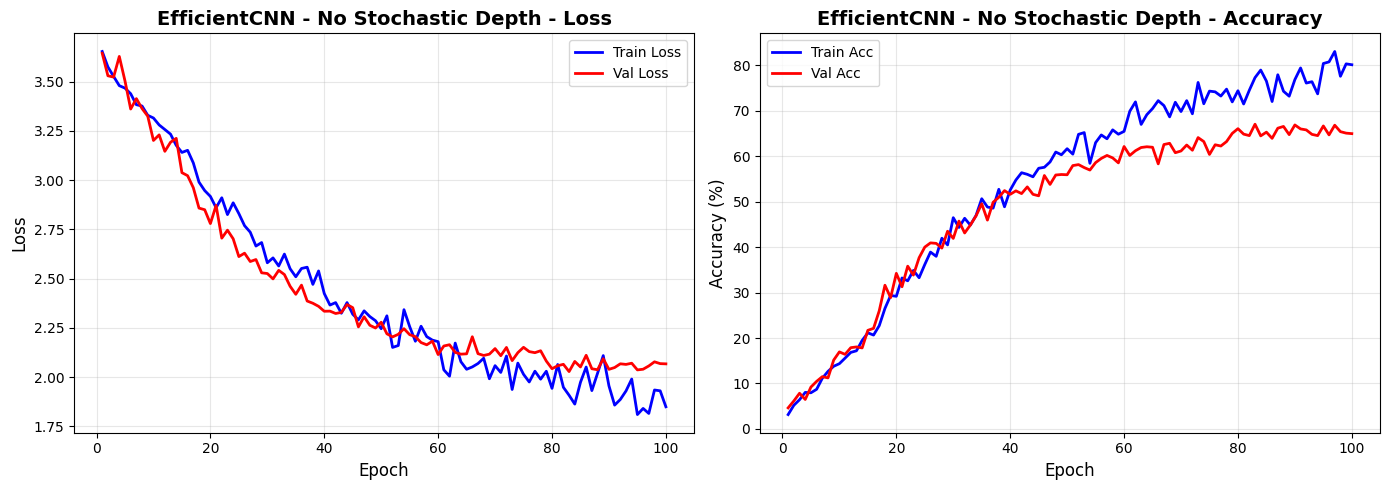

Added: EfficientCNN - No Stochastic Depth | Test Acc: 67.33% | Params: 2.0M


In [28]:
# No Stochastic Depth Experiment Configuration
config_no_sd = ExperimentConfig(
    width_mult=0.75,
    depth_mult=0.8,
    dropout_rate=0.4,
    drop_path_rate=0.0,  # Disable Stochastic Depth regularization
    use_depthwise=True,
    use_residual=True,
    cutmix_prob=0.15,
    mixup_prob=0.15,
    label_smoothing=0.2,
    lr=1e-3,
    weight_decay=2e-4,
    optimizer="AdamW"
)

# Run ablation test
run_experiment(
    config=config_no_sd,
    model_name="EfficientCNN - No Stochastic Depth",
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=DEVICE,
    num_classes=NUM_CLASSES,
    tracker=tracker
)

Disabling stochastic depth slightly reduces generalization resulting in a higher train-validation gap. This suggests that stochastic depth acts as a mild regularizer that improves robustness considering our quite small dataset.

#### Third test: applying weaker data augmentation


EXPERIMENT: EfficientCNN - Weak Data Augmentation

Epoch 1/100
------------------------------------------------------------


Train Loss: 3.6244 | Train Acc: 4.03% | Time: 14.40s
Val Loss: 3.8164 | Val Acc: 4.31% | Time: 5.31s

Epoch 2/100
------------------------------------------------------------


Train Loss: 3.5112 | Train Acc: 5.86% | Time: 14.33s
Val Loss: 3.5185 | Val Acc: 6.22% | Time: 5.43s

Epoch 3/100
------------------------------------------------------------


Train Loss: 3.4459 | Train Acc: 7.47% | Time: 14.64s
Val Loss: 3.4471 | Val Acc: 7.80% | Time: 5.40s

Epoch 4/100
------------------------------------------------------------


Train Loss: 3.3777 | Train Acc: 10.17% | Time: 14.48s
Val Loss: 3.3825 | Val Acc: 10.31% | Time: 5.45s

Epoch 5/100
------------------------------------------------------------


Train Loss: 3.3103 | Train Acc: 11.69% | Time: 14.27s
Val Loss: 3.3821 | Val Acc: 10.96% | Time: 5.33s

Epoch 6/100
------------------------------------------------------------


Train Loss: 3.2311 | Train Acc: 14.72% | Time: 14.48s
Val Loss: 3.2914 | Val Acc: 14.12% | Time: 5.47s

Epoch 7/100
------------------------------------------------------------


Train Loss: 3.1536 | Train Acc: 19.05% | Time: 14.47s
Val Loss: 3.2093 | Val Acc: 17.61% | Time: 5.40s

Epoch 8/100
------------------------------------------------------------


Train Loss: 3.0740 | Train Acc: 21.20% | Time: 14.65s
Val Loss: 3.2177 | Val Acc: 17.34% | Time: 5.39s

Epoch 9/100
------------------------------------------------------------


Train Loss: 2.9941 | Train Acc: 23.55% | Time: 14.51s
Val Loss: 3.1371 | Val Acc: 19.90% | Time: 5.35s

Epoch 10/100
------------------------------------------------------------


Train Loss: 2.9264 | Train Acc: 27.45% | Time: 14.76s
Val Loss: 3.1894 | Val Acc: 18.10% | Time: 5.58s

Epoch 11/100
------------------------------------------------------------


Train Loss: 2.8275 | Train Acc: 30.36% | Time: 14.28s
Val Loss: 3.0196 | Val Acc: 24.86% | Time: 5.39s

Epoch 12/100
------------------------------------------------------------


Train Loss: 2.7665 | Train Acc: 32.54% | Time: 14.37s
Val Loss: 3.1965 | Val Acc: 20.88% | Time: 5.43s

Epoch 13/100
------------------------------------------------------------


Train Loss: 2.7009 | Train Acc: 35.76% | Time: 14.39s
Val Loss: 3.0181 | Val Acc: 25.03% | Time: 5.42s

Epoch 14/100
------------------------------------------------------------


Train Loss: 2.6212 | Train Acc: 38.65% | Time: 14.28s
Val Loss: 2.9297 | Val Acc: 30.26% | Time: 5.36s

Epoch 15/100
------------------------------------------------------------


Train Loss: 2.5808 | Train Acc: 41.43% | Time: 14.44s
Val Loss: 2.8429 | Val Acc: 31.68% | Time: 5.44s

Epoch 16/100
------------------------------------------------------------


Train Loss: 2.5141 | Train Acc: 43.74% | Time: 14.58s
Val Loss: 2.8535 | Val Acc: 33.59% | Time: 5.37s

Epoch 17/100
------------------------------------------------------------


Train Loss: 2.4480 | Train Acc: 47.07% | Time: 14.12s
Val Loss: 2.7834 | Val Acc: 36.37% | Time: 5.45s

Epoch 18/100
------------------------------------------------------------


Train Loss: 2.3823 | Train Acc: 50.37% | Time: 14.73s
Val Loss: 2.7728 | Val Acc: 37.62% | Time: 5.34s

Epoch 19/100
------------------------------------------------------------


Train Loss: 2.3383 | Train Acc: 51.57% | Time: 14.27s
Val Loss: 2.6449 | Val Acc: 40.73% | Time: 5.27s

Epoch 20/100
------------------------------------------------------------


Train Loss: 2.2909 | Train Acc: 54.07% | Time: 14.53s
Val Loss: 2.6826 | Val Acc: 40.57% | Time: 5.46s

Epoch 21/100
------------------------------------------------------------


Train Loss: 2.2086 | Train Acc: 57.02% | Time: 14.33s
Val Loss: 2.6086 | Val Acc: 43.18% | Time: 5.48s

Epoch 22/100
------------------------------------------------------------


Train Loss: 2.1626 | Train Acc: 61.11% | Time: 14.65s
Val Loss: 2.5689 | Val Acc: 44.66% | Time: 5.41s

Epoch 23/100
------------------------------------------------------------


Train Loss: 2.1445 | Train Acc: 59.91% | Time: 14.38s
Val Loss: 2.6873 | Val Acc: 40.51% | Time: 5.33s

Epoch 24/100
------------------------------------------------------------


Train Loss: 2.0894 | Train Acc: 64.13% | Time: 14.17s
Val Loss: 2.5308 | Val Acc: 47.27% | Time: 5.36s

Epoch 25/100
------------------------------------------------------------


Train Loss: 2.0558 | Train Acc: 65.25% | Time: 14.39s
Val Loss: 2.5632 | Val Acc: 46.40% | Time: 5.42s

Epoch 26/100
------------------------------------------------------------


Train Loss: 1.9918 | Train Acc: 68.27% | Time: 14.37s
Val Loss: 2.5380 | Val Acc: 47.22% | Time: 5.40s

Epoch 27/100
------------------------------------------------------------


Train Loss: 1.9734 | Train Acc: 69.01% | Time: 14.33s
Val Loss: 2.5086 | Val Acc: 48.04% | Time: 5.57s

Epoch 28/100
------------------------------------------------------------


Train Loss: 1.9298 | Train Acc: 71.52% | Time: 14.50s
Val Loss: 2.5805 | Val Acc: 44.33% | Time: 5.35s

Epoch 29/100
------------------------------------------------------------


Train Loss: 1.9189 | Train Acc: 72.44% | Time: 14.58s
Val Loss: 2.4772 | Val Acc: 48.04% | Time: 5.31s

Epoch 30/100
------------------------------------------------------------


Train Loss: 1.8832 | Train Acc: 74.49% | Time: 14.54s
Val Loss: 2.5296 | Val Acc: 47.06% | Time: 5.53s

Epoch 31/100
------------------------------------------------------------


Train Loss: 1.8295 | Train Acc: 76.10% | Time: 14.48s
Val Loss: 2.4169 | Val Acc: 52.24% | Time: 5.28s

Epoch 32/100
------------------------------------------------------------


Train Loss: 1.8156 | Train Acc: 77.21% | Time: 14.31s
Val Loss: 2.4346 | Val Acc: 52.56% | Time: 5.27s

Epoch 33/100
------------------------------------------------------------


Train Loss: 1.7836 | Train Acc: 78.41% | Time: 14.57s
Val Loss: 2.4313 | Val Acc: 52.45% | Time: 5.33s

Epoch 34/100
------------------------------------------------------------


Train Loss: 1.7620 | Train Acc: 79.89% | Time: 14.33s
Val Loss: 2.4156 | Val Acc: 53.00% | Time: 5.29s

Epoch 35/100
------------------------------------------------------------


Train Loss: 1.7384 | Train Acc: 80.78% | Time: 14.27s
Val Loss: 2.3957 | Val Acc: 52.13% | Time: 5.28s

Epoch 36/100
------------------------------------------------------------


Train Loss: 1.7055 | Train Acc: 82.53% | Time: 14.18s
Val Loss: 2.4284 | Val Acc: 52.56% | Time: 5.19s

Epoch 37/100
------------------------------------------------------------


Train Loss: 1.6982 | Train Acc: 82.58% | Time: 14.26s
Val Loss: 2.3539 | Val Acc: 56.32% | Time: 5.40s

Epoch 38/100
------------------------------------------------------------


Train Loss: 1.6619 | Train Acc: 84.63% | Time: 14.23s
Val Loss: 2.3706 | Val Acc: 53.60% | Time: 5.37s

Epoch 39/100
------------------------------------------------------------


Train Loss: 1.6297 | Train Acc: 86.62% | Time: 14.77s
Val Loss: 2.3634 | Val Acc: 54.80% | Time: 5.17s

Epoch 40/100
------------------------------------------------------------


Train Loss: 1.6068 | Train Acc: 87.11% | Time: 14.36s
Val Loss: 2.4127 | Val Acc: 52.56% | Time: 5.32s

Epoch 41/100
------------------------------------------------------------


Train Loss: 1.6156 | Train Acc: 87.00% | Time: 14.19s
Val Loss: 2.4658 | Val Acc: 51.69% | Time: 5.41s

Epoch 42/100
------------------------------------------------------------


Train Loss: 1.6029 | Train Acc: 87.65% | Time: 14.34s
Val Loss: 2.3686 | Val Acc: 54.63% | Time: 5.33s

Epoch 43/100
------------------------------------------------------------


Train Loss: 1.5672 | Train Acc: 89.13% | Time: 14.02s
Val Loss: 2.3442 | Val Acc: 54.85% | Time: 5.30s

Epoch 44/100
------------------------------------------------------------


Train Loss: 1.5640 | Train Acc: 89.26% | Time: 14.18s
Val Loss: 2.3966 | Val Acc: 54.53% | Time: 5.40s

Epoch 45/100
------------------------------------------------------------


Train Loss: 1.5496 | Train Acc: 90.32% | Time: 14.32s
Val Loss: 2.3403 | Val Acc: 56.76% | Time: 5.32s

Epoch 46/100
------------------------------------------------------------


Train Loss: 1.5323 | Train Acc: 91.14% | Time: 14.31s
Val Loss: 2.3689 | Val Acc: 54.03% | Time: 5.27s

Epoch 47/100
------------------------------------------------------------


Train Loss: 1.5369 | Train Acc: 91.36% | Time: 14.10s
Val Loss: 2.3674 | Val Acc: 54.14% | Time: 5.25s

Epoch 48/100
------------------------------------------------------------


Train Loss: 1.4966 | Train Acc: 92.70% | Time: 14.29s
Val Loss: 2.3539 | Val Acc: 56.27% | Time: 5.35s

Epoch 49/100
------------------------------------------------------------


Train Loss: 1.5075 | Train Acc: 92.26% | Time: 14.27s
Val Loss: 2.3712 | Val Acc: 56.05% | Time: 5.31s

Epoch 50/100
------------------------------------------------------------


Train Loss: 1.4956 | Train Acc: 92.45% | Time: 14.34s
Val Loss: 2.3554 | Val Acc: 56.22% | Time: 5.30s

Epoch 51/100
------------------------------------------------------------


Train Loss: 1.4607 | Train Acc: 94.11% | Time: 14.31s
Val Loss: 2.3063 | Val Acc: 58.40% | Time: 5.38s

Epoch 52/100
------------------------------------------------------------


Train Loss: 1.4581 | Train Acc: 94.22% | Time: 14.32s
Val Loss: 2.3125 | Val Acc: 56.43% | Time: 5.41s

Epoch 53/100
------------------------------------------------------------


Train Loss: 1.4452 | Train Acc: 94.77% | Time: 14.11s
Val Loss: 2.3504 | Val Acc: 56.16% | Time: 5.29s

Epoch 54/100
------------------------------------------------------------


Train Loss: 1.4453 | Train Acc: 94.66% | Time: 14.35s
Val Loss: 2.3204 | Val Acc: 56.60% | Time: 5.25s

Epoch 55/100
------------------------------------------------------------


Train Loss: 1.4351 | Train Acc: 95.48% | Time: 14.34s
Val Loss: 2.3249 | Val Acc: 57.42% | Time: 5.24s

Epoch 56/100
------------------------------------------------------------


Train Loss: 1.4354 | Train Acc: 95.67% | Time: 14.56s
Val Loss: 2.3059 | Val Acc: 57.14% | Time: 5.48s

Epoch 57/100
------------------------------------------------------------


Train Loss: 1.4179 | Train Acc: 96.05% | Time: 14.54s
Val Loss: 2.2753 | Val Acc: 58.78% | Time: 5.29s

Epoch 58/100
------------------------------------------------------------


Train Loss: 1.4097 | Train Acc: 96.38% | Time: 14.37s
Val Loss: 2.2750 | Val Acc: 57.91% | Time: 5.45s

Epoch 59/100
------------------------------------------------------------


Train Loss: 1.4075 | Train Acc: 96.40% | Time: 14.19s
Val Loss: 2.3397 | Val Acc: 57.25% | Time: 5.26s

Epoch 60/100
------------------------------------------------------------


Train Loss: 1.4114 | Train Acc: 96.43% | Time: 14.21s
Val Loss: 2.2987 | Val Acc: 58.62% | Time: 5.37s

Epoch 61/100
------------------------------------------------------------


Train Loss: 1.4020 | Train Acc: 96.46% | Time: 14.37s
Val Loss: 2.2610 | Val Acc: 59.76% | Time: 5.24s

Epoch 62/100
------------------------------------------------------------


Train Loss: 1.3988 | Train Acc: 96.67% | Time: 14.53s
Val Loss: 2.2661 | Val Acc: 58.56% | Time: 5.29s

Epoch 63/100
------------------------------------------------------------


Train Loss: 1.3955 | Train Acc: 96.54% | Time: 14.34s
Val Loss: 2.2602 | Val Acc: 58.18% | Time: 5.34s

Epoch 64/100
------------------------------------------------------------


Train Loss: 1.3929 | Train Acc: 97.11% | Time: 14.37s
Val Loss: 2.2725 | Val Acc: 59.54% | Time: 5.43s

Epoch 65/100
------------------------------------------------------------


Train Loss: 1.3886 | Train Acc: 97.19% | Time: 14.62s
Val Loss: 2.2948 | Val Acc: 58.56% | Time: 5.36s

Epoch 66/100
------------------------------------------------------------


Train Loss: 1.3848 | Train Acc: 96.81% | Time: 14.37s
Val Loss: 2.2388 | Val Acc: 58.07% | Time: 5.51s

Epoch 67/100
------------------------------------------------------------


Train Loss: 1.3854 | Train Acc: 97.03% | Time: 14.78s
Val Loss: 2.2672 | Val Acc: 58.83% | Time: 5.31s

Epoch 68/100
------------------------------------------------------------


Train Loss: 1.3788 | Train Acc: 97.30% | Time: 14.34s
Val Loss: 2.2375 | Val Acc: 60.20% | Time: 5.44s

Epoch 69/100
------------------------------------------------------------


Train Loss: 1.3705 | Train Acc: 97.60% | Time: 14.35s
Val Loss: 2.2441 | Val Acc: 59.32% | Time: 5.27s

Epoch 70/100
------------------------------------------------------------


Train Loss: 1.3635 | Train Acc: 97.90% | Time: 14.37s
Val Loss: 2.2516 | Val Acc: 59.81% | Time: 5.32s

Epoch 71/100
------------------------------------------------------------


Train Loss: 1.3586 | Train Acc: 97.55% | Time: 14.60s
Val Loss: 2.2686 | Val Acc: 59.27% | Time: 5.26s

Epoch 72/100
------------------------------------------------------------


Train Loss: 1.3681 | Train Acc: 97.44% | Time: 14.32s
Val Loss: 2.2526 | Val Acc: 59.11% | Time: 5.41s

Epoch 73/100
------------------------------------------------------------


Train Loss: 1.3483 | Train Acc: 98.15% | Time: 14.52s
Val Loss: 2.2237 | Val Acc: 61.56% | Time: 5.45s

Epoch 74/100
------------------------------------------------------------


Train Loss: 1.3501 | Train Acc: 98.47% | Time: 14.32s
Val Loss: 2.2115 | Val Acc: 61.01% | Time: 5.33s

Epoch 75/100
------------------------------------------------------------


Train Loss: 1.3626 | Train Acc: 97.55% | Time: 14.46s
Val Loss: 2.2680 | Val Acc: 58.40% | Time: 5.45s

Epoch 76/100
------------------------------------------------------------


Train Loss: 1.3553 | Train Acc: 97.90% | Time: 14.46s
Val Loss: 2.2001 | Val Acc: 59.81% | Time: 5.41s

Epoch 77/100
------------------------------------------------------------


Train Loss: 1.3512 | Train Acc: 98.09% | Time: 14.39s
Val Loss: 2.2401 | Val Acc: 58.89% | Time: 5.30s

Epoch 78/100
------------------------------------------------------------


Train Loss: 1.3511 | Train Acc: 98.28% | Time: 14.34s
Val Loss: 2.2160 | Val Acc: 60.47% | Time: 5.33s

Epoch 79/100
------------------------------------------------------------


Train Loss: 1.3505 | Train Acc: 98.20% | Time: 14.43s
Val Loss: 2.2343 | Val Acc: 59.81% | Time: 5.60s

Epoch 80/100
------------------------------------------------------------


Train Loss: 1.3505 | Train Acc: 98.23% | Time: 14.37s
Val Loss: 2.2653 | Val Acc: 60.20% | Time: 5.32s

Epoch 81/100
------------------------------------------------------------


Train Loss: 1.3337 | Train Acc: 98.72% | Time: 14.27s
Val Loss: 2.2254 | Val Acc: 59.43% | Time: 5.31s

Epoch 82/100
------------------------------------------------------------


Train Loss: 1.3286 | Train Acc: 98.94% | Time: 14.31s
Val Loss: 2.2628 | Val Acc: 59.27% | Time: 5.41s

Epoch 83/100
------------------------------------------------------------


Train Loss: 1.3306 | Train Acc: 98.72% | Time: 14.55s
Val Loss: 2.2196 | Val Acc: 59.43% | Time: 5.39s

Epoch 84/100
------------------------------------------------------------


Train Loss: 1.3464 | Train Acc: 98.01% | Time: 14.24s
Val Loss: 2.2110 | Val Acc: 58.56% | Time: 5.49s

Epoch 85/100
------------------------------------------------------------


Train Loss: 1.3355 | Train Acc: 98.45% | Time: 14.57s
Val Loss: 2.2034 | Val Acc: 60.20% | Time: 5.39s

Epoch 86/100
------------------------------------------------------------


Train Loss: 1.3273 | Train Acc: 98.77% | Time: 14.45s
Val Loss: 2.2370 | Val Acc: 60.47% | Time: 5.38s

Epoch 87/100
------------------------------------------------------------


Train Loss: 1.3279 | Train Acc: 98.45% | Time: 14.65s
Val Loss: 2.2181 | Val Acc: 61.29% | Time: 5.36s

Epoch 88/100
------------------------------------------------------------


Train Loss: 1.3252 | Train Acc: 98.69% | Time: 14.14s
Val Loss: 2.2163 | Val Acc: 60.14% | Time: 5.42s

Epoch 89/100
------------------------------------------------------------


Train Loss: 1.3253 | Train Acc: 98.64% | Time: 14.66s
Val Loss: 2.1787 | Val Acc: 61.78% | Time: 5.49s

Epoch 90/100
------------------------------------------------------------


Train Loss: 1.3224 | Train Acc: 98.80% | Time: 14.73s
Val Loss: 2.2036 | Val Acc: 61.72% | Time: 5.34s

Epoch 91/100
------------------------------------------------------------


Train Loss: 1.3309 | Train Acc: 98.26% | Time: 14.27s
Val Loss: 2.2244 | Val Acc: 59.38% | Time: 5.47s

Epoch 92/100
------------------------------------------------------------


Train Loss: 1.3112 | Train Acc: 98.86% | Time: 14.78s
Val Loss: 2.1725 | Val Acc: 62.00% | Time: 5.39s

Epoch 93/100
------------------------------------------------------------


Train Loss: 1.3192 | Train Acc: 98.83% | Time: 14.12s
Val Loss: 2.2041 | Val Acc: 61.12% | Time: 5.26s

Epoch 94/100
------------------------------------------------------------


Train Loss: 1.3203 | Train Acc: 98.61% | Time: 14.36s
Val Loss: 2.2223 | Val Acc: 61.07% | Time: 5.38s

Epoch 95/100
------------------------------------------------------------


Train Loss: 1.3238 | Train Acc: 98.66% | Time: 14.48s
Val Loss: 2.1998 | Val Acc: 62.49% | Time: 5.34s

Epoch 96/100
------------------------------------------------------------


Train Loss: 1.3299 | Train Acc: 98.72% | Time: 14.19s
Val Loss: 2.2010 | Val Acc: 60.91% | Time: 5.48s

Epoch 97/100
------------------------------------------------------------


Train Loss: 1.3215 | Train Acc: 98.39% | Time: 14.74s
Val Loss: 2.1859 | Val Acc: 61.72% | Time: 5.39s

Epoch 98/100
------------------------------------------------------------


Train Loss: 1.3179 | Train Acc: 99.16% | Time: 14.84s
Val Loss: 2.2374 | Val Acc: 60.09% | Time: 5.36s

Epoch 99/100
------------------------------------------------------------


Train Loss: 1.3160 | Train Acc: 98.83% | Time: 14.43s
Val Loss: 2.1776 | Val Acc: 61.83% | Time: 5.50s

Epoch 100/100
------------------------------------------------------------


Train Loss: 1.3164 | Train Acc: 98.75% | Time: 14.58s
Val Loss: 2.2024 | Val Acc: 60.63% | Time: 5.47s


Best Validation Accuracy: 62.49%
Total Training Time: 24.01 minutes
Average Training Time per Epoch: 14.41 seconds



FINAL TEST RESULTS:
  Accuracy: 66.74%
  Loss: 2.0492
  Total Test Time: 5.43s



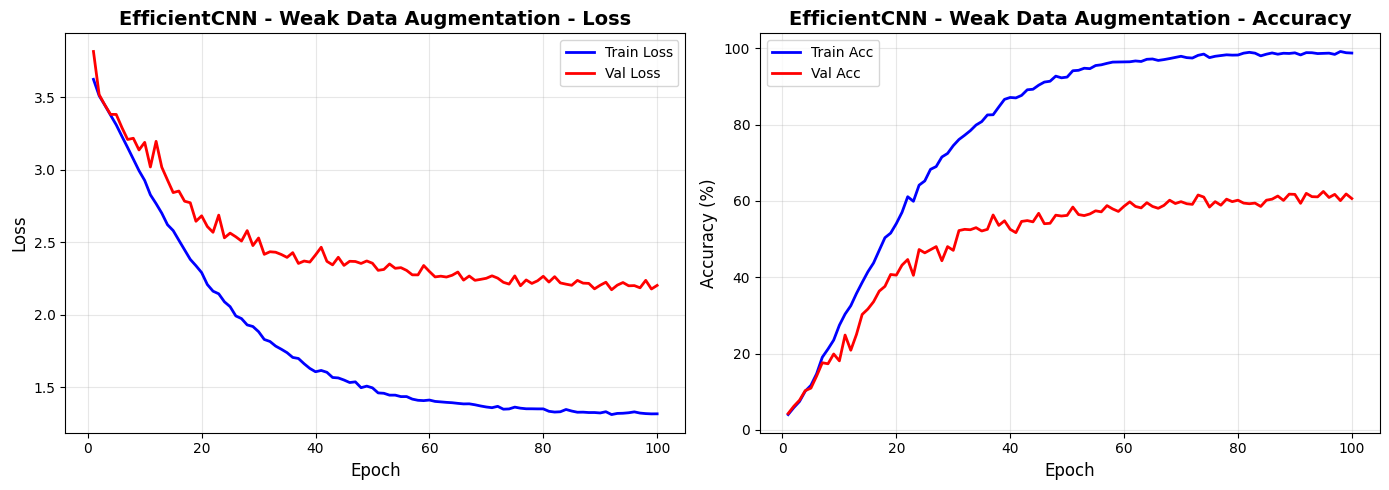

Added: EfficientCNN - Weak Data Augmentation | Test Acc: 66.74% | Params: 2.0M


In [29]:
# Weak Data Augmentation Experiment Configuration
config_weak = ExperimentConfig(
    width_mult=0.75,
    depth_mult=0.8,
    dropout_rate=0.4,
    drop_path_rate=0.2,
    use_depthwise=True,
    use_residual=True,
    cutmix_prob=0.0,  # Set 0% probability for CutMix augmentation
    mixup_prob=0.0,   # Set 0% probability for MixUp augmentation
    label_smoothing=0.2,
    lr=1e-3,
    weight_decay=2e-4,
    optimizer="AdamW"
)

# Run ablation test
run_experiment(
    config=config_weak,
    model_name="EfficientCNN - Weak Data Augmentation",
    train_loader=weak_train_loader,  # Use train DataLoader with weak transform
    val_loader=val_loader,
    test_loader=test_loader,
    device=DEVICE,
    num_classes=NUM_CLASSES,
    tracker=tracker
)

Weakening data augmentation induces strong overfitting, as shown by saturated training accuracy and a large train–validation gap, resulting in a reduced test accuracy and confirming augmentation as a key source of regularization.

#### Fourth test: cross-entropy loss without label smoothing


EXPERIMENT: EfficientCNN - No Label Smoothing

Epoch 1/100
------------------------------------------------------------


Train Loss: 3.6715 | Train Acc: 2.92% | Time: 26.45s
Val Loss: 3.6973 | Val Acc: 3.82% | Time: 5.32s

Epoch 2/100
------------------------------------------------------------


Train Loss: 3.5826 | Train Acc: 3.49% | Time: 25.52s
Val Loss: 3.4958 | Val Acc: 5.40% | Time: 5.26s

Epoch 3/100
------------------------------------------------------------


Train Loss: 3.5394 | Train Acc: 4.82% | Time: 25.71s
Val Loss: 3.4723 | Val Acc: 5.56% | Time: 5.36s

Epoch 4/100
------------------------------------------------------------


Train Loss: 3.5142 | Train Acc: 4.82% | Time: 26.16s
Val Loss: 3.4135 | Val Acc: 7.58% | Time: 5.34s

Epoch 5/100
------------------------------------------------------------


Train Loss: 3.4781 | Train Acc: 5.97% | Time: 25.31s
Val Loss: 3.3231 | Val Acc: 8.56% | Time: 5.40s

Epoch 6/100
------------------------------------------------------------


Train Loss: 3.4302 | Train Acc: 6.87% | Time: 25.59s
Val Loss: 3.3407 | Val Acc: 9.76% | Time: 5.35s

Epoch 7/100
------------------------------------------------------------


Train Loss: 3.4088 | Train Acc: 7.33% | Time: 25.40s
Val Loss: 3.2999 | Val Acc: 9.49% | Time: 5.36s

Epoch 8/100
------------------------------------------------------------


Train Loss: 3.3634 | Train Acc: 9.29% | Time: 25.23s
Val Loss: 3.2306 | Val Acc: 10.25% | Time: 5.19s

Epoch 9/100
------------------------------------------------------------


Train Loss: 3.3347 | Train Acc: 9.89% | Time: 25.79s
Val Loss: 3.2507 | Val Acc: 10.25% | Time: 5.39s

Epoch 10/100
------------------------------------------------------------


Train Loss: 3.2616 | Train Acc: 10.90% | Time: 25.55s
Val Loss: 3.3290 | Val Acc: 10.96% | Time: 5.48s

Epoch 11/100
------------------------------------------------------------


Train Loss: 3.2709 | Train Acc: 11.15% | Time: 26.02s
Val Loss: 3.1106 | Val Acc: 12.60% | Time: 5.32s

Epoch 12/100
------------------------------------------------------------


Train Loss: 3.1994 | Train Acc: 12.35% | Time: 25.51s
Val Loss: 3.0989 | Val Acc: 13.63% | Time: 5.43s

Epoch 13/100
------------------------------------------------------------


Train Loss: 3.1528 | Train Acc: 13.74% | Time: 26.07s
Val Loss: 2.9541 | Val Acc: 15.87% | Time: 5.45s

Epoch 14/100
------------------------------------------------------------


Train Loss: 3.1309 | Train Acc: 13.87% | Time: 25.94s
Val Loss: 2.8318 | Val Acc: 18.43% | Time: 5.36s

Epoch 15/100
------------------------------------------------------------


Train Loss: 3.0749 | Train Acc: 15.02% | Time: 25.61s
Val Loss: 2.9114 | Val Acc: 18.16% | Time: 5.36s

Epoch 16/100
------------------------------------------------------------


Train Loss: 3.0448 | Train Acc: 16.68% | Time: 26.11s
Val Loss: 2.8942 | Val Acc: 19.85% | Time: 5.47s

Epoch 17/100
------------------------------------------------------------


Train Loss: 2.9105 | Train Acc: 19.68% | Time: 25.55s
Val Loss: 2.7840 | Val Acc: 21.10% | Time: 5.18s

Epoch 18/100
------------------------------------------------------------


Train Loss: 2.8984 | Train Acc: 19.76% | Time: 25.75s
Val Loss: 2.5953 | Val Acc: 25.52% | Time: 5.32s

Epoch 19/100
------------------------------------------------------------


Train Loss: 2.8038 | Train Acc: 23.25% | Time: 25.72s
Val Loss: 2.4933 | Val Acc: 26.66% | Time: 5.36s

Epoch 20/100
------------------------------------------------------------


Train Loss: 2.6555 | Train Acc: 26.46% | Time: 26.17s
Val Loss: 2.4145 | Val Acc: 28.57% | Time: 5.28s

Epoch 21/100
------------------------------------------------------------


Train Loss: 2.6947 | Train Acc: 26.06% | Time: 25.30s
Val Loss: 2.4928 | Val Acc: 27.10% | Time: 5.48s

Epoch 22/100
------------------------------------------------------------


Train Loss: 2.6375 | Train Acc: 27.56% | Time: 26.06s
Val Loss: 2.3490 | Val Acc: 30.53% | Time: 5.43s

Epoch 23/100
------------------------------------------------------------


Train Loss: 2.4514 | Train Acc: 30.09% | Time: 25.85s
Val Loss: 2.2461 | Val Acc: 32.66% | Time: 5.30s

Epoch 24/100
------------------------------------------------------------


Train Loss: 2.4386 | Train Acc: 32.65% | Time: 25.61s
Val Loss: 2.1644 | Val Acc: 34.41% | Time: 5.28s

Epoch 25/100
------------------------------------------------------------


Train Loss: 2.5073 | Train Acc: 30.39% | Time: 25.58s
Val Loss: 2.0763 | Val Acc: 38.28% | Time: 5.37s

Epoch 26/100
------------------------------------------------------------


Train Loss: 2.3187 | Train Acc: 35.65% | Time: 25.60s
Val Loss: 2.0816 | Val Acc: 37.84% | Time: 5.40s

Epoch 27/100
------------------------------------------------------------


Train Loss: 2.3312 | Train Acc: 35.51% | Time: 25.99s
Val Loss: 1.9237 | Val Acc: 43.62% | Time: 5.29s

Epoch 28/100
------------------------------------------------------------


Train Loss: 2.2511 | Train Acc: 38.10% | Time: 25.77s
Val Loss: 1.9905 | Val Acc: 40.24% | Time: 5.40s

Epoch 29/100
------------------------------------------------------------


Train Loss: 2.2970 | Train Acc: 39.14% | Time: 25.83s
Val Loss: 1.8763 | Val Acc: 44.49% | Time: 5.16s

Epoch 30/100
------------------------------------------------------------


Train Loss: 2.1996 | Train Acc: 40.96% | Time: 26.11s
Val Loss: 1.7761 | Val Acc: 45.75% | Time: 5.38s

Epoch 31/100
------------------------------------------------------------


Train Loss: 2.1572 | Train Acc: 41.84% | Time: 25.69s
Val Loss: 1.8043 | Val Acc: 45.69% | Time: 5.36s

Epoch 32/100
------------------------------------------------------------


Train Loss: 2.2151 | Train Acc: 39.93% | Time: 26.16s
Val Loss: 1.7521 | Val Acc: 46.78% | Time: 5.32s

Epoch 33/100
------------------------------------------------------------


Train Loss: 2.0425 | Train Acc: 44.40% | Time: 26.90s
Val Loss: 1.7383 | Val Acc: 46.89% | Time: 5.44s

Epoch 34/100
------------------------------------------------------------


Train Loss: 2.0773 | Train Acc: 44.07% | Time: 26.54s
Val Loss: 1.7028 | Val Acc: 46.95% | Time: 5.40s

Epoch 35/100
------------------------------------------------------------


Train Loss: 2.0401 | Train Acc: 46.14% | Time: 26.93s
Val Loss: 1.7418 | Val Acc: 46.24% | Time: 5.29s

Epoch 36/100
------------------------------------------------------------


Train Loss: 1.9031 | Train Acc: 47.81% | Time: 26.89s
Val Loss: 1.6753 | Val Acc: 47.11% | Time: 5.58s

Epoch 37/100
------------------------------------------------------------


Train Loss: 1.8871 | Train Acc: 49.01% | Time: 25.91s
Val Loss: 1.6025 | Val Acc: 51.53% | Time: 5.32s

Epoch 38/100
------------------------------------------------------------


Train Loss: 1.8338 | Train Acc: 50.34% | Time: 25.43s
Val Loss: 1.5855 | Val Acc: 52.13% | Time: 5.44s

Epoch 39/100
------------------------------------------------------------


Train Loss: 1.8401 | Train Acc: 49.74% | Time: 25.85s
Val Loss: 1.6501 | Val Acc: 49.35% | Time: 5.48s

Epoch 40/100
------------------------------------------------------------


Train Loss: 1.6682 | Train Acc: 54.13% | Time: 25.74s
Val Loss: 1.6094 | Val Acc: 50.05% | Time: 5.44s

Epoch 41/100
------------------------------------------------------------


Train Loss: 1.9603 | Train Acc: 49.22% | Time: 25.64s
Val Loss: 1.5141 | Val Acc: 54.03% | Time: 5.45s

Epoch 42/100
------------------------------------------------------------


Train Loss: 1.7284 | Train Acc: 53.88% | Time: 25.64s
Val Loss: 1.5113 | Val Acc: 54.58% | Time: 5.26s

Epoch 43/100
------------------------------------------------------------


Train Loss: 1.6427 | Train Acc: 55.11% | Time: 25.94s
Val Loss: 1.4917 | Val Acc: 52.84% | Time: 5.29s

Epoch 44/100
------------------------------------------------------------


Train Loss: 1.8463 | Train Acc: 52.03% | Time: 25.65s
Val Loss: 1.4558 | Val Acc: 55.62% | Time: 5.29s

Epoch 45/100
------------------------------------------------------------


Train Loss: 1.7767 | Train Acc: 53.45% | Time: 25.63s
Val Loss: 1.4965 | Val Acc: 54.36% | Time: 5.43s

Epoch 46/100
------------------------------------------------------------


Train Loss: 1.5738 | Train Acc: 58.54% | Time: 25.78s
Val Loss: 1.4279 | Val Acc: 57.14% | Time: 5.56s

Epoch 47/100
------------------------------------------------------------


Train Loss: 1.7366 | Train Acc: 56.94% | Time: 25.36s
Val Loss: 1.5192 | Val Acc: 54.36% | Time: 5.37s

Epoch 48/100
------------------------------------------------------------


Train Loss: 1.6311 | Train Acc: 57.73% | Time: 25.67s
Val Loss: 1.3816 | Val Acc: 57.63% | Time: 5.28s

Epoch 49/100
------------------------------------------------------------


Train Loss: 1.5054 | Train Acc: 58.79% | Time: 25.83s
Val Loss: 1.3886 | Val Acc: 57.03% | Time: 5.44s

Epoch 50/100
------------------------------------------------------------


Train Loss: 1.7203 | Train Acc: 56.50% | Time: 25.75s
Val Loss: 1.3725 | Val Acc: 57.69% | Time: 5.26s

Epoch 51/100
------------------------------------------------------------


Train Loss: 1.5475 | Train Acc: 61.46% | Time: 25.63s
Val Loss: 1.3738 | Val Acc: 58.07% | Time: 5.32s

Epoch 52/100
------------------------------------------------------------


Train Loss: 1.4486 | Train Acc: 62.14% | Time: 26.07s
Val Loss: 1.4201 | Val Acc: 58.45% | Time: 5.47s

Epoch 53/100
------------------------------------------------------------


Train Loss: 1.3773 | Train Acc: 64.10% | Time: 25.81s
Val Loss: 1.3220 | Val Acc: 58.89% | Time: 5.32s

Epoch 54/100
------------------------------------------------------------


Train Loss: 1.4359 | Train Acc: 62.93% | Time: 26.09s
Val Loss: 1.3522 | Val Acc: 59.16% | Time: 5.35s

Epoch 55/100
------------------------------------------------------------


Train Loss: 1.5284 | Train Acc: 62.25% | Time: 26.08s
Val Loss: 1.3199 | Val Acc: 60.41% | Time: 5.54s

Epoch 56/100
------------------------------------------------------------


Train Loss: 1.5707 | Train Acc: 62.09% | Time: 25.77s
Val Loss: 1.2487 | Val Acc: 61.89% | Time: 5.42s

Epoch 57/100
------------------------------------------------------------


Train Loss: 1.4045 | Train Acc: 65.00% | Time: 25.73s
Val Loss: 1.2966 | Val Acc: 60.96% | Time: 5.38s

Epoch 58/100
------------------------------------------------------------


Train Loss: 1.5177 | Train Acc: 62.52% | Time: 25.96s
Val Loss: 1.2484 | Val Acc: 60.91% | Time: 5.26s

Epoch 59/100
------------------------------------------------------------


Train Loss: 1.4495 | Train Acc: 65.03% | Time: 25.59s
Val Loss: 1.1816 | Val Acc: 64.50% | Time: 5.44s

Epoch 60/100
------------------------------------------------------------


Train Loss: 1.3448 | Train Acc: 66.31% | Time: 26.68s
Val Loss: 1.2461 | Val Acc: 62.76% | Time: 5.45s

Epoch 61/100
------------------------------------------------------------


Train Loss: 1.3108 | Train Acc: 68.77% | Time: 25.78s
Val Loss: 1.3763 | Val Acc: 58.56% | Time: 5.35s

Epoch 62/100
------------------------------------------------------------


Train Loss: 1.7079 | Train Acc: 62.63% | Time: 25.92s
Val Loss: 1.2449 | Val Acc: 62.00% | Time: 5.47s

Epoch 63/100
------------------------------------------------------------


Train Loss: 1.5090 | Train Acc: 65.33% | Time: 26.11s
Val Loss: 1.2439 | Val Acc: 63.30% | Time: 5.48s

Epoch 64/100
------------------------------------------------------------


Train Loss: 1.2757 | Train Acc: 68.68% | Time: 25.81s
Val Loss: 1.2326 | Val Acc: 62.10% | Time: 5.25s

Epoch 65/100
------------------------------------------------------------


Train Loss: 1.3746 | Train Acc: 66.42% | Time: 25.65s
Val Loss: 1.2850 | Val Acc: 61.67% | Time: 5.40s

Epoch 66/100
------------------------------------------------------------


Train Loss: 1.1728 | Train Acc: 72.17% | Time: 25.69s
Val Loss: 1.1940 | Val Acc: 65.32% | Time: 5.44s

Epoch 67/100
------------------------------------------------------------


Train Loss: 1.5056 | Train Acc: 67.24% | Time: 25.71s
Val Loss: 1.2581 | Val Acc: 62.32% | Time: 5.35s

Epoch 68/100
------------------------------------------------------------


Train Loss: 1.2512 | Train Acc: 68.77% | Time: 26.37s
Val Loss: 1.1527 | Val Acc: 64.83% | Time: 5.28s

Epoch 69/100
------------------------------------------------------------


Train Loss: 1.2035 | Train Acc: 70.65% | Time: 26.12s
Val Loss: 1.2086 | Val Acc: 63.41% | Time: 5.41s

Epoch 70/100
------------------------------------------------------------


Train Loss: 1.1165 | Train Acc: 72.42% | Time: 26.05s
Val Loss: 1.2730 | Val Acc: 61.01% | Time: 5.34s

Epoch 71/100
------------------------------------------------------------


Train Loss: 1.1767 | Train Acc: 70.92% | Time: 26.17s
Val Loss: 1.1773 | Val Acc: 64.12% | Time: 5.24s

Epoch 72/100
------------------------------------------------------------


Train Loss: 1.2960 | Train Acc: 70.10% | Time: 26.15s
Val Loss: 1.2645 | Val Acc: 64.23% | Time: 5.56s

Epoch 73/100
------------------------------------------------------------


Train Loss: 1.3220 | Train Acc: 69.53% | Time: 25.97s
Val Loss: 1.1964 | Val Acc: 64.01% | Time: 5.35s

Epoch 74/100
------------------------------------------------------------


Train Loss: 1.5256 | Train Acc: 65.96% | Time: 26.35s
Val Loss: 1.2433 | Val Acc: 63.09% | Time: 5.25s

Epoch 75/100
------------------------------------------------------------


Train Loss: 1.4018 | Train Acc: 67.43% | Time: 25.85s
Val Loss: 1.2284 | Val Acc: 62.54% | Time: 5.29s

Epoch 76/100
------------------------------------------------------------


Train Loss: 1.0339 | Train Acc: 75.25% | Time: 25.58s
Val Loss: 1.1598 | Val Acc: 65.10% | Time: 5.47s

Epoch 77/100
------------------------------------------------------------


Train Loss: 1.3359 | Train Acc: 69.36% | Time: 25.63s
Val Loss: 1.1473 | Val Acc: 65.38% | Time: 5.43s

Epoch 78/100
------------------------------------------------------------


Train Loss: 1.3632 | Train Acc: 70.43% | Time: 26.10s
Val Loss: 1.1414 | Val Acc: 66.25% | Time: 5.32s

Epoch 79/100
------------------------------------------------------------


Train Loss: 1.4384 | Train Acc: 69.09% | Time: 26.06s
Val Loss: 1.1823 | Val Acc: 63.74% | Time: 5.29s

Epoch 80/100
------------------------------------------------------------


Train Loss: 1.3354 | Train Acc: 70.02% | Time: 25.71s
Val Loss: 1.1801 | Val Acc: 66.19% | Time: 5.45s

Epoch 81/100
------------------------------------------------------------


Train Loss: 1.1523 | Train Acc: 74.30% | Time: 26.28s
Val Loss: 1.2006 | Val Acc: 64.34% | Time: 5.45s

Epoch 82/100
------------------------------------------------------------


Train Loss: 0.9973 | Train Acc: 77.51% | Time: 25.91s
Val Loss: 1.1344 | Val Acc: 66.79% | Time: 5.38s

Epoch 83/100
------------------------------------------------------------


Train Loss: 1.1011 | Train Acc: 74.57% | Time: 25.99s
Val Loss: 1.1133 | Val Acc: 66.41% | Time: 5.42s

Epoch 84/100
------------------------------------------------------------


Train Loss: 1.2489 | Train Acc: 71.38% | Time: 25.98s
Val Loss: 1.2876 | Val Acc: 60.58% | Time: 5.33s

Epoch 85/100
------------------------------------------------------------


Train Loss: 0.9918 | Train Acc: 77.71% | Time: 25.46s
Val Loss: 1.1227 | Val Acc: 66.47% | Time: 5.38s

Epoch 86/100
------------------------------------------------------------


Train Loss: 1.2877 | Train Acc: 72.72% | Time: 25.76s
Val Loss: 1.1791 | Val Acc: 66.14% | Time: 5.30s

Epoch 87/100
------------------------------------------------------------


Train Loss: 1.0491 | Train Acc: 74.90% | Time: 26.11s
Val Loss: 1.0667 | Val Acc: 68.10% | Time: 5.23s

Epoch 88/100
------------------------------------------------------------


Train Loss: 1.0059 | Train Acc: 75.93% | Time: 25.97s
Val Loss: 1.1388 | Val Acc: 66.79% | Time: 5.32s

Epoch 89/100
------------------------------------------------------------


Train Loss: 1.1345 | Train Acc: 75.22% | Time: 25.93s
Val Loss: 1.1248 | Val Acc: 67.01% | Time: 5.38s

Epoch 90/100
------------------------------------------------------------


Train Loss: 1.2413 | Train Acc: 71.44% | Time: 25.51s
Val Loss: 1.1456 | Val Acc: 66.68% | Time: 5.35s

Epoch 91/100
------------------------------------------------------------


Train Loss: 1.2060 | Train Acc: 72.83% | Time: 25.72s
Val Loss: 1.1714 | Val Acc: 65.10% | Time: 5.48s

Epoch 92/100
------------------------------------------------------------


Train Loss: 1.3473 | Train Acc: 71.41% | Time: 26.30s
Val Loss: 1.0539 | Val Acc: 69.57% | Time: 5.41s

Epoch 93/100
------------------------------------------------------------


Train Loss: 1.0361 | Train Acc: 74.73% | Time: 25.97s
Val Loss: 1.1420 | Val Acc: 66.74% | Time: 5.31s

Epoch 94/100
------------------------------------------------------------


Train Loss: 1.0965 | Train Acc: 74.49% | Time: 26.08s
Val Loss: 1.1345 | Val Acc: 67.28% | Time: 5.40s

Epoch 95/100
------------------------------------------------------------


Train Loss: 1.0588 | Train Acc: 78.52% | Time: 26.18s
Val Loss: 1.1345 | Val Acc: 66.14% | Time: 5.32s

Epoch 96/100
------------------------------------------------------------


Train Loss: 1.2600 | Train Acc: 72.69% | Time: 25.68s
Val Loss: 1.1883 | Val Acc: 64.94% | Time: 5.40s

Epoch 97/100
------------------------------------------------------------


Train Loss: 1.0366 | Train Acc: 78.96% | Time: 26.22s
Val Loss: 1.2210 | Val Acc: 64.50% | Time: 5.39s

Epoch 98/100
------------------------------------------------------------


Train Loss: 1.0071 | Train Acc: 78.22% | Time: 25.53s
Val Loss: 1.1221 | Val Acc: 67.07% | Time: 5.41s

Epoch 99/100
------------------------------------------------------------


Train Loss: 1.1281 | Train Acc: 75.42% | Time: 26.00s
Val Loss: 1.1450 | Val Acc: 68.38% | Time: 5.25s

Epoch 100/100
------------------------------------------------------------


Train Loss: 1.2079 | Train Acc: 74.93% | Time: 25.89s
Val Loss: 1.1153 | Val Acc: 67.61% | Time: 5.26s


Best Validation Accuracy: 69.57%
Total Training Time: 43.14 minutes
Average Training Time per Epoch: 25.88 seconds



FINAL TEST RESULTS:
  Accuracy: 70.04%
  Loss: 0.9879
  Total Test Time: 5.56s



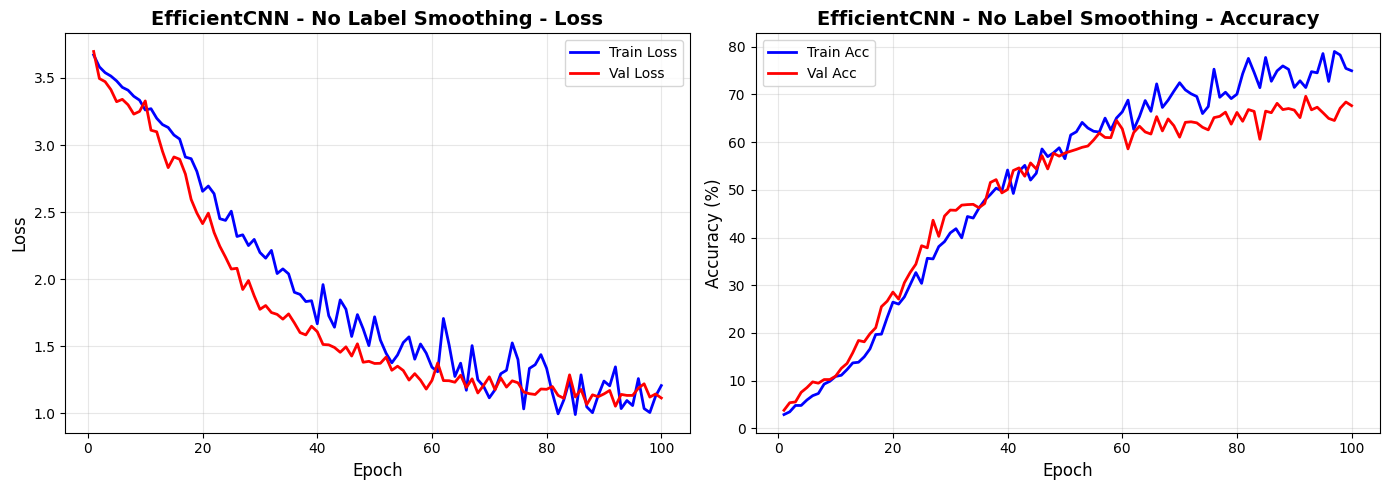

Added: EfficientCNN - No Label Smoothing | Test Acc: 70.04% | Params: 2.0M


In [30]:
# No Label Smoothing Experiment Configuration
config_no_ls = ExperimentConfig(
    width_mult=0.75,
    depth_mult=0.8,
    dropout_rate=0.4,
    drop_path_rate=0.2,
    use_depthwise=True,
    use_residual=True,
    cutmix_prob=0.15,
    mixup_prob=0.15,
    label_smoothing=0.0,  # Disable Label Smoothing
    lr=1e-3,
    weight_decay=2e-4,
    optimizer="AdamW"
)

# Run ablation test
run_experiment(
    config=config_no_ls,
    model_name="EfficientCNN - No Label Smoothing",
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=DEVICE,
    num_classes=NUM_CLASSES,
    tracker=tracker
)

Removing label smoothing yields a markedly lower test loss due to more confident predictions, but only a marginal change in accuracy, indicating that label smoothing primarily improves calibration and regularization rather than maximizing accuracy or minimizing cross-entropy loss.

#### Fifth test: using standard convolution


EXPERIMENT: EfficientCNN - No Depthwise Separable Convolution

Epoch 1/100
------------------------------------------------------------


Train Loss: 3.6637 | Train Acc: 2.75% | Time: 29.37s
Val Loss: 3.6112 | Val Acc: 2.73% | Time: 14.62s

Epoch 2/100
------------------------------------------------------------


Train Loss: 3.6318 | Train Acc: 2.13% | Time: 29.15s
Val Loss: 3.6236 | Val Acc: 2.45% | Time: 14.31s

Epoch 3/100
------------------------------------------------------------


Train Loss: 3.6193 | Train Acc: 2.62% | Time: 28.97s
Val Loss: 3.6104 | Val Acc: 2.73% | Time: 14.39s

Epoch 4/100
------------------------------------------------------------


Train Loss: 3.6159 | Train Acc: 2.89% | Time: 29.30s
Val Loss: 3.6111 | Val Acc: 2.67% | Time: 14.36s

Epoch 5/100
------------------------------------------------------------


Train Loss: 3.6124 | Train Acc: 2.67% | Time: 29.23s
Val Loss: 3.6119 | Val Acc: 2.62% | Time: 14.48s

Epoch 6/100
------------------------------------------------------------


Train Loss: 3.6108 | Train Acc: 2.89% | Time: 28.39s
Val Loss: 3.6071 | Val Acc: 3.22% | Time: 14.31s

Epoch 7/100
------------------------------------------------------------


Train Loss: 3.6099 | Train Acc: 3.98% | Time: 29.02s
Val Loss: 3.6803 | Val Acc: 2.13% | Time: 14.50s

Epoch 8/100
------------------------------------------------------------


Train Loss: 3.6049 | Train Acc: 3.35% | Time: 30.54s
Val Loss: 3.6040 | Val Acc: 3.38% | Time: 14.38s

Epoch 9/100
------------------------------------------------------------


Train Loss: 3.5996 | Train Acc: 3.38% | Time: 32.31s
Val Loss: 3.6285 | Val Acc: 3.33% | Time: 14.45s

Epoch 10/100
------------------------------------------------------------


Train Loss: 3.5927 | Train Acc: 3.90% | Time: 32.79s
Val Loss: 3.6051 | Val Acc: 3.38% | Time: 14.53s

Epoch 11/100
------------------------------------------------------------


Train Loss: 3.5799 | Train Acc: 3.95% | Time: 33.92s
Val Loss: 3.5663 | Val Acc: 3.76% | Time: 14.57s

Epoch 12/100
------------------------------------------------------------


Train Loss: 3.5773 | Train Acc: 4.55% | Time: 35.47s
Val Loss: 3.5562 | Val Acc: 3.93% | Time: 14.67s

Epoch 13/100
------------------------------------------------------------


Train Loss: 3.5788 | Train Acc: 3.87% | Time: 35.71s
Val Loss: 3.5402 | Val Acc: 5.67% | Time: 14.62s

Epoch 14/100
------------------------------------------------------------


Train Loss: 3.5663 | Train Acc: 4.39% | Time: 34.91s
Val Loss: 3.5431 | Val Acc: 6.32% | Time: 14.62s

Epoch 15/100
------------------------------------------------------------


Train Loss: 3.5608 | Train Acc: 4.52% | Time: 33.86s
Val Loss: 3.5308 | Val Acc: 5.40% | Time: 14.55s

Epoch 16/100
------------------------------------------------------------


Train Loss: 3.5475 | Train Acc: 5.21% | Time: 33.98s
Val Loss: 3.5090 | Val Acc: 6.05% | Time: 14.60s

Epoch 17/100
------------------------------------------------------------


Train Loss: 3.5460 | Train Acc: 5.07% | Time: 33.88s
Val Loss: 3.5873 | Val Acc: 4.14% | Time: 14.50s

Epoch 18/100
------------------------------------------------------------


Train Loss: 3.5508 | Train Acc: 5.56% | Time: 33.71s
Val Loss: 3.5649 | Val Acc: 4.69% | Time: 14.56s

Epoch 19/100
------------------------------------------------------------


Train Loss: 3.5341 | Train Acc: 5.91% | Time: 33.83s
Val Loss: 3.5035 | Val Acc: 5.34% | Time: 14.56s

Epoch 20/100
------------------------------------------------------------


Train Loss: 3.5268 | Train Acc: 5.81% | Time: 34.48s
Val Loss: 3.5235 | Val Acc: 6.11% | Time: 14.52s

Epoch 21/100
------------------------------------------------------------


Train Loss: 3.5289 | Train Acc: 6.19% | Time: 34.06s
Val Loss: 3.5370 | Val Acc: 5.45% | Time: 14.77s

Epoch 22/100
------------------------------------------------------------


Train Loss: 3.5198 | Train Acc: 6.84% | Time: 34.04s
Val Loss: 3.4803 | Val Acc: 7.58% | Time: 14.55s

Epoch 23/100
------------------------------------------------------------


Train Loss: 3.5139 | Train Acc: 5.81% | Time: 34.37s
Val Loss: 3.4922 | Val Acc: 6.87% | Time: 14.66s

Epoch 24/100
------------------------------------------------------------


Train Loss: 3.5161 | Train Acc: 6.60% | Time: 33.47s
Val Loss: 3.4822 | Val Acc: 6.98% | Time: 14.57s

Epoch 25/100
------------------------------------------------------------


Train Loss: 3.4953 | Train Acc: 6.98% | Time: 34.49s
Val Loss: 3.4656 | Val Acc: 7.25% | Time: 14.65s

Epoch 26/100
------------------------------------------------------------


Train Loss: 3.5006 | Train Acc: 6.84% | Time: 34.11s
Val Loss: 3.5397 | Val Acc: 6.92% | Time: 14.66s

Epoch 27/100
------------------------------------------------------------


Train Loss: 3.4815 | Train Acc: 7.85% | Time: 33.23s
Val Loss: 3.4153 | Val Acc: 9.00% | Time: 14.62s

Epoch 28/100
------------------------------------------------------------


Train Loss: 3.4702 | Train Acc: 7.50% | Time: 32.57s
Val Loss: 3.4287 | Val Acc: 8.23% | Time: 14.47s

Epoch 29/100
------------------------------------------------------------


Train Loss: 3.4544 | Train Acc: 8.07% | Time: 30.57s
Val Loss: 3.5061 | Val Acc: 8.07% | Time: 14.63s

Epoch 30/100
------------------------------------------------------------


Train Loss: 3.4496 | Train Acc: 8.94% | Time: 29.27s
Val Loss: 3.4054 | Val Acc: 9.00% | Time: 14.37s

Epoch 31/100
------------------------------------------------------------


Train Loss: 3.4232 | Train Acc: 8.83% | Time: 28.85s
Val Loss: 3.4744 | Val Acc: 9.16% | Time: 14.41s

Epoch 32/100
------------------------------------------------------------


Train Loss: 3.4278 | Train Acc: 9.62% | Time: 28.92s
Val Loss: 3.3911 | Val Acc: 9.54% | Time: 14.61s

Epoch 33/100
------------------------------------------------------------


Train Loss: 3.4195 | Train Acc: 9.19% | Time: 28.47s
Val Loss: 3.3692 | Val Acc: 11.34% | Time: 14.40s

Epoch 34/100
------------------------------------------------------------


Train Loss: 3.4357 | Train Acc: 9.54% | Time: 28.50s
Val Loss: 3.3682 | Val Acc: 11.01% | Time: 14.56s

Epoch 35/100
------------------------------------------------------------


Train Loss: 3.4080 | Train Acc: 11.26% | Time: 28.30s
Val Loss: 3.3505 | Val Acc: 11.12% | Time: 14.43s

Epoch 36/100
------------------------------------------------------------


Train Loss: 3.4054 | Train Acc: 9.98% | Time: 28.97s
Val Loss: 3.4096 | Val Acc: 8.40% | Time: 14.40s

Epoch 37/100
------------------------------------------------------------


Train Loss: 3.3814 | Train Acc: 11.26% | Time: 28.59s
Val Loss: 3.3655 | Val Acc: 10.58% | Time: 14.37s

Epoch 38/100
------------------------------------------------------------


Train Loss: 3.4004 | Train Acc: 10.85% | Time: 29.07s
Val Loss: 3.4167 | Val Acc: 10.41% | Time: 14.45s

Epoch 39/100
------------------------------------------------------------


Train Loss: 3.3694 | Train Acc: 11.77% | Time: 28.82s
Val Loss: 3.3704 | Val Acc: 10.25% | Time: 14.53s

Epoch 40/100
------------------------------------------------------------


Train Loss: 3.3397 | Train Acc: 11.34% | Time: 28.91s
Val Loss: 3.2678 | Val Acc: 13.58% | Time: 14.45s

Epoch 41/100
------------------------------------------------------------


Train Loss: 3.3761 | Train Acc: 11.39% | Time: 28.81s
Val Loss: 3.3237 | Val Acc: 11.56% | Time: 14.44s

Epoch 42/100
------------------------------------------------------------


Train Loss: 3.3558 | Train Acc: 12.59% | Time: 29.21s
Val Loss: 3.2781 | Val Acc: 13.36% | Time: 14.44s

Epoch 43/100
------------------------------------------------------------


Train Loss: 3.3614 | Train Acc: 11.75% | Time: 29.30s
Val Loss: 3.2700 | Val Acc: 13.90% | Time: 14.58s

Epoch 44/100
------------------------------------------------------------


Train Loss: 3.3322 | Train Acc: 12.95% | Time: 28.69s
Val Loss: 3.2393 | Val Acc: 14.67% | Time: 14.36s

Epoch 45/100
------------------------------------------------------------


Train Loss: 3.3255 | Train Acc: 13.33% | Time: 28.59s
Val Loss: 3.3035 | Val Acc: 11.89% | Time: 14.42s

Epoch 46/100
------------------------------------------------------------


Train Loss: 3.3297 | Train Acc: 13.06% | Time: 28.84s
Val Loss: 3.2878 | Val Acc: 13.58% | Time: 14.59s

Epoch 47/100
------------------------------------------------------------


Train Loss: 3.3469 | Train Acc: 12.48% | Time: 28.41s
Val Loss: 3.2428 | Val Acc: 16.25% | Time: 14.36s

Epoch 48/100
------------------------------------------------------------


Train Loss: 3.3331 | Train Acc: 13.52% | Time: 28.52s
Val Loss: 3.2561 | Val Acc: 14.72% | Time: 14.40s

Epoch 49/100
------------------------------------------------------------


Train Loss: 3.3006 | Train Acc: 13.95% | Time: 29.58s
Val Loss: 3.2846 | Val Acc: 13.52% | Time: 14.61s

Epoch 50/100
------------------------------------------------------------


Train Loss: 3.2835 | Train Acc: 14.80% | Time: 29.06s
Val Loss: 3.2900 | Val Acc: 14.12% | Time: 14.36s

Epoch 51/100
------------------------------------------------------------


Train Loss: 3.2895 | Train Acc: 13.65% | Time: 28.76s
Val Loss: 3.2731 | Val Acc: 14.56% | Time: 14.41s

Epoch 52/100
------------------------------------------------------------


Train Loss: 3.3050 | Train Acc: 14.61% | Time: 28.91s
Val Loss: 3.1776 | Val Acc: 17.50% | Time: 14.47s

Epoch 53/100
------------------------------------------------------------


Train Loss: 3.2306 | Train Acc: 16.82% | Time: 28.73s
Val Loss: 3.2731 | Val Acc: 14.67% | Time: 14.61s

Epoch 54/100
------------------------------------------------------------


Train Loss: 3.2645 | Train Acc: 15.43% | Time: 28.27s
Val Loss: 3.2456 | Val Acc: 17.88% | Time: 14.39s

Epoch 55/100
------------------------------------------------------------


Train Loss: 3.2761 | Train Acc: 14.94% | Time: 28.97s
Val Loss: 3.1410 | Val Acc: 18.59% | Time: 14.49s

Epoch 56/100
------------------------------------------------------------


Train Loss: 3.2288 | Train Acc: 17.61% | Time: 29.05s
Val Loss: 3.2222 | Val Acc: 15.43% | Time: 14.57s

Epoch 57/100
------------------------------------------------------------


Train Loss: 3.2460 | Train Acc: 17.58% | Time: 31.04s
Val Loss: 3.1818 | Val Acc: 18.16% | Time: 14.54s

Epoch 58/100
------------------------------------------------------------


Train Loss: 3.1919 | Train Acc: 17.99% | Time: 32.85s
Val Loss: 3.2067 | Val Acc: 16.85% | Time: 14.55s

Epoch 59/100
------------------------------------------------------------


Train Loss: 3.2084 | Train Acc: 17.66% | Time: 33.02s
Val Loss: 3.0914 | Val Acc: 20.01% | Time: 14.68s

Epoch 60/100
------------------------------------------------------------


Train Loss: 3.1956 | Train Acc: 18.48% | Time: 35.57s
Val Loss: 3.1354 | Val Acc: 18.05% | Time: 14.67s

Epoch 61/100
------------------------------------------------------------


Train Loss: 3.1838 | Train Acc: 17.53% | Time: 33.60s
Val Loss: 3.3768 | Val Acc: 13.90% | Time: 14.62s

Epoch 62/100
------------------------------------------------------------


Train Loss: 3.1962 | Train Acc: 17.77% | Time: 33.55s
Val Loss: 3.0789 | Val Acc: 20.34% | Time: 14.60s

Epoch 63/100
------------------------------------------------------------


Train Loss: 3.1973 | Train Acc: 18.89% | Time: 32.70s
Val Loss: 3.1114 | Val Acc: 20.07% | Time: 14.54s

Epoch 64/100
------------------------------------------------------------


Train Loss: 3.1489 | Train Acc: 21.50% | Time: 33.10s
Val Loss: 3.0691 | Val Acc: 21.16% | Time: 14.56s

Epoch 65/100
------------------------------------------------------------


Train Loss: 3.1119 | Train Acc: 20.47% | Time: 33.26s
Val Loss: 3.0407 | Val Acc: 21.70% | Time: 14.48s

Epoch 66/100
------------------------------------------------------------


Train Loss: 3.1653 | Train Acc: 20.55% | Time: 32.73s
Val Loss: 3.1095 | Val Acc: 18.48% | Time: 14.77s

Epoch 67/100
------------------------------------------------------------


Train Loss: 3.1558 | Train Acc: 20.99% | Time: 33.41s
Val Loss: 3.0403 | Val Acc: 23.12% | Time: 14.56s

Epoch 68/100
------------------------------------------------------------


Train Loss: 3.0890 | Train Acc: 22.51% | Time: 33.06s
Val Loss: 3.0856 | Val Acc: 21.43% | Time: 14.58s

Epoch 69/100
------------------------------------------------------------


Train Loss: 3.0812 | Train Acc: 22.89% | Time: 32.50s
Val Loss: 2.9801 | Val Acc: 24.48% | Time: 14.61s

Epoch 70/100
------------------------------------------------------------


Train Loss: 3.0737 | Train Acc: 23.39% | Time: 33.17s
Val Loss: 3.0096 | Val Acc: 22.57% | Time: 14.51s

Epoch 71/100
------------------------------------------------------------


Train Loss: 3.0613 | Train Acc: 23.71% | Time: 32.98s
Val Loss: 2.9496 | Val Acc: 26.12% | Time: 14.66s

Epoch 72/100
------------------------------------------------------------


Train Loss: 3.1137 | Train Acc: 21.45% | Time: 32.13s
Val Loss: 2.9850 | Val Acc: 24.15% | Time: 14.45s

Epoch 73/100
------------------------------------------------------------


Train Loss: 3.0864 | Train Acc: 23.33% | Time: 33.33s
Val Loss: 2.9349 | Val Acc: 26.34% | Time: 14.63s

Epoch 74/100
------------------------------------------------------------


Train Loss: 3.0411 | Train Acc: 24.72% | Time: 31.76s
Val Loss: 2.9844 | Val Acc: 26.06% | Time: 14.49s

Epoch 75/100
------------------------------------------------------------


Train Loss: 2.9918 | Train Acc: 26.08% | Time: 32.11s
Val Loss: 3.0810 | Val Acc: 23.34% | Time: 14.62s

Epoch 76/100
------------------------------------------------------------


Train Loss: 2.9444 | Train Acc: 27.61% | Time: 32.58s
Val Loss: 2.8558 | Val Acc: 29.61% | Time: 14.49s

Epoch 77/100
------------------------------------------------------------


Train Loss: 2.9071 | Train Acc: 28.75% | Time: 32.59s
Val Loss: 2.9256 | Val Acc: 27.37% | Time: 14.63s

Epoch 78/100
------------------------------------------------------------


Train Loss: 2.9472 | Train Acc: 28.89% | Time: 31.81s
Val Loss: 3.0378 | Val Acc: 22.74% | Time: 14.54s

Epoch 79/100
------------------------------------------------------------


Train Loss: 2.9702 | Train Acc: 28.32% | Time: 32.49s
Val Loss: 2.8379 | Val Acc: 31.73% | Time: 14.73s

Epoch 80/100
------------------------------------------------------------


Train Loss: 2.8665 | Train Acc: 31.59% | Time: 32.48s
Val Loss: 2.8603 | Val Acc: 30.37% | Time: 14.54s

Epoch 81/100
------------------------------------------------------------


Train Loss: 2.9291 | Train Acc: 30.93% | Time: 32.26s
Val Loss: 2.8970 | Val Acc: 27.92% | Time: 14.59s

Epoch 82/100
------------------------------------------------------------


Train Loss: 2.9287 | Train Acc: 30.74% | Time: 33.16s
Val Loss: 2.7716 | Val Acc: 34.57% | Time: 14.71s

Epoch 83/100
------------------------------------------------------------


Train Loss: 2.8774 | Train Acc: 31.23% | Time: 32.66s
Val Loss: 2.7740 | Val Acc: 33.81% | Time: 14.52s

Epoch 84/100
------------------------------------------------------------


Train Loss: 2.8908 | Train Acc: 32.49% | Time: 32.53s
Val Loss: 2.7874 | Val Acc: 33.53% | Time: 14.78s

Epoch 85/100
------------------------------------------------------------


Train Loss: 2.8452 | Train Acc: 32.82% | Time: 33.30s
Val Loss: 2.7385 | Val Acc: 34.13% | Time: 14.46s

Epoch 86/100
------------------------------------------------------------


Train Loss: 2.8198 | Train Acc: 33.39% | Time: 31.20s
Val Loss: 2.7120 | Val Acc: 36.64% | Time: 14.66s

Epoch 87/100
------------------------------------------------------------


Train Loss: 2.9053 | Train Acc: 32.38% | Time: 32.11s
Val Loss: 2.7223 | Val Acc: 37.24% | Time: 14.65s

Epoch 88/100
------------------------------------------------------------


Train Loss: 2.8563 | Train Acc: 34.70% | Time: 32.51s
Val Loss: 2.6771 | Val Acc: 38.60% | Time: 14.62s

Epoch 89/100
------------------------------------------------------------


Train Loss: 2.8348 | Train Acc: 35.65% | Time: 33.52s
Val Loss: 2.7040 | Val Acc: 38.88% | Time: 14.63s

Epoch 90/100
------------------------------------------------------------


Train Loss: 2.7695 | Train Acc: 36.58% | Time: 32.92s
Val Loss: 2.6607 | Val Acc: 39.09% | Time: 14.41s

Epoch 91/100
------------------------------------------------------------


Train Loss: 2.8012 | Train Acc: 36.55% | Time: 32.94s
Val Loss: 2.6259 | Val Acc: 38.77% | Time: 14.71s

Epoch 92/100
------------------------------------------------------------


Train Loss: 2.7782 | Train Acc: 37.88% | Time: 32.37s
Val Loss: 2.7053 | Val Acc: 37.02% | Time: 14.47s

Epoch 93/100
------------------------------------------------------------


Train Loss: 2.7462 | Train Acc: 37.37% | Time: 32.44s
Val Loss: 2.7984 | Val Acc: 34.62% | Time: 14.50s

Epoch 94/100
------------------------------------------------------------


Train Loss: 2.7208 | Train Acc: 39.19% | Time: 32.55s
Val Loss: 2.6460 | Val Acc: 37.35% | Time: 14.57s

Epoch 95/100
------------------------------------------------------------


Train Loss: 2.7250 | Train Acc: 38.70% | Time: 32.91s
Val Loss: 2.5913 | Val Acc: 41.82% | Time: 14.43s

Epoch 96/100
------------------------------------------------------------


Train Loss: 2.7151 | Train Acc: 38.81% | Time: 32.70s
Val Loss: 2.5652 | Val Acc: 41.66% | Time: 14.69s

Epoch 97/100
------------------------------------------------------------


Train Loss: 2.6775 | Train Acc: 40.61% | Time: 31.00s
Val Loss: 2.5735 | Val Acc: 41.00% | Time: 14.39s

Epoch 98/100
------------------------------------------------------------


Train Loss: 2.7131 | Train Acc: 39.60% | Time: 31.15s
Val Loss: 2.5978 | Val Acc: 41.77% | Time: 14.72s

Epoch 99/100
------------------------------------------------------------


Train Loss: 2.7624 | Train Acc: 39.00% | Time: 32.51s
Val Loss: 2.5684 | Val Acc: 42.69% | Time: 14.56s

Epoch 100/100
------------------------------------------------------------


Train Loss: 2.6767 | Train Acc: 40.88% | Time: 32.27s
Val Loss: 2.7786 | Val Acc: 35.33% | Time: 14.69s


Best Validation Accuracy: 42.69%
Total Training Time: 52.65 minutes
Average Training Time per Epoch: 31.59 seconds



FINAL TEST RESULTS:
  Accuracy: 45.07%
  Loss: 2.4925
  Total Test Time: 14.64s



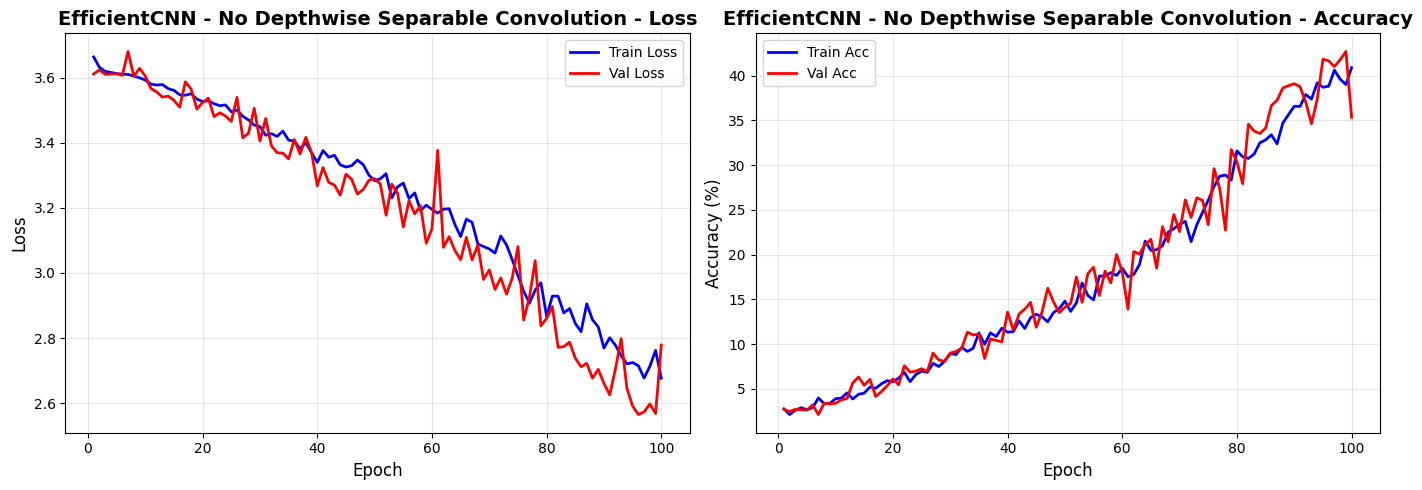

Added: EfficientCNN - No Depthwise Separable Convolution | Test Acc: 45.07% | Params: 94.0M


In [31]:
# No Depthwise Separable Convolution Experiment Configuration
config_no_ds_conv = ExperimentConfig(
    width_mult=0.75,
    depth_mult=0.8,
    dropout_rate=0.4,
    drop_path_rate=0.2,
    use_depthwise=False,  # Use traditional convolution
    use_residual=True,
    cutmix_prob=0.15,
    mixup_prob=0.15,
    label_smoothing=0.2,
    lr=1e-3,
    weight_decay=2e-4,
    optimizer="AdamW"
)

# Run ablation test
run_experiment(
    config=config_no_ds_conv,
    model_name="EfficientCNN - No Depthwise Separable Convolution",
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=DEVICE,
    num_classes=NUM_CLASSES,
    tracker=tracker
)

Replacing depthwise separable convolutions with standard convolutions dramatically increases model size and leads to undertrained behavior with nearly linear performance growth, suggesting that the model requires substantially longer training to exploit its higher capacity, and underscoring the efficiency–performance trade-off of depthwise design.

### Results summary

In [32]:
# Show configurations of ablation tests
tracker.show_config()

Model Name  Width Mul  Depth Mul  \
0                          EfficientCNN - Main Model       0.75        0.8   
1             EfficientCNN - No Residual Connections       0.75        0.8   
2                 EfficientCNN - No Stochastic Depth       0.75        0.8   
3              EfficientCNN - Weak Data Augmentation       0.75        0.8   
4                  EfficientCNN - No Label Smoothing       0.75        0.8   
5  EfficientCNN - No Depthwise Separable Convolution       0.75        0.8   

   Dropout Rate  Drop Path Rate  Depthwise Convolution  Residual Connections  \
0           0.4             0.2                   True                  True   
1           0.4             0.2                   True                 False   
2           0.4             0.0                   True                  True   
3           0.4             0.2                   True                  True   
4           0.4             0.2                   True                  True   
5           0.4             0.2                  False                  True   

   CutMix Prob  MixUp Prob  Label Smoothing  Learning Rate  Weight Decay  \
0         0.15        0.15              0.2          0.001        0.0002   
1         0.15        0.15              0.2          0.001        0.0002   
2         0.15        0.15              0.2          0.001        0.0002   
3         0.00        0.00              0.2          0.001        0.0002   
4         0.15        0.15              0.0          0.001        0.0002   
5         0.15        0.15              0.2          0.001        0.0002   

  Optimizer  
0     AdamW  
1     AdamW  
2     AdamW  
3     AdamW  
4     AdamW  
5     AdamW

In [33]:
# Comprehensive view of the results
tracker.get_dataframe()

Model Name  Parameters (M)  \
0                          EfficientCNN - Main Model            2.04   
4                  EfficientCNN - No Label Smoothing            2.04   
2                 EfficientCNN - No Stochastic Depth            2.04   
3              EfficientCNN - Weak Data Augmentation            2.04   
1             EfficientCNN - No Residual Connections            2.04   
5  EfficientCNN - No Depthwise Separable Convolution           94.00   

   Model Size (MB)  FLOPs (G)  Test Acc (%)  Test Loss  Best Val Acc (%)  \
0             7.77       0.30         71.56     1.8955             70.23   
4             7.77       0.30         70.04     0.9879             69.57   
2             7.77       0.30         67.33     1.9898             67.07   
3             7.77       0.30         66.74     2.0492             62.49   
1             7.77       0.30         61.54     2.1072             58.56   
5           358.59      10.09         45.07     2.4925             42.69   

   Generalization Gap (%)  Total Training Time (min)  \
0                   13.36                       43.3   
4                    7.31                       43.1   
2                   15.16                       43.1   
3                   38.11                       24.0   
1                    9.42                       42.9   
5                    5.55                       52.6   

   Avg Training Epoch Time (s)  ...  Dropout Rate  Drop Path Rate  \
0                         26.0  ...           0.4             0.2   
4                         25.9  ...           0.4             0.2   
2                         25.8  ...           0.4             0.0   
3                         14.4  ...           0.4             0.2   
1                         25.8  ...           0.4             0.2   
5                         31.6  ...           0.4             0.2   

   Depthwise Convolution  Residual Connections  CutMix Prob  MixUp Prob  \
0                   True                  True         0.15        0.15   
4                   True                  True         0.15        0.15   
2                   True                  True         0.15        0.15   
3                   True                  True         0.00        0.00   
1                   True                 False         0.15        0.15   
5                  False                  True         0.15        0.15   

   Label Smoothing  Learning Rate  Weight Decay  Optimizer  
0              0.2          0.001        0.0002      AdamW  
4              0.0          0.001        0.0002      AdamW  
2              0.2          0.001        0.0002      AdamW  
3              0.2          0.001        0.0002      AdamW  
1              0.2          0.001        0.0002      AdamW  
5              0.2          0.001        0.0002      AdamW  

[6 rows x 22 columns]

In [35]:
# Print summary
tracker.summary()


ABLATION STUDY SUMMARY

Best Model: EfficientCNN - Main Model
   Test Acc: 71.56%
   Test Loss: 1.8955
   Generalization Gap: 13.36%
   Parameters: 2.04 M
   Training Time: 43.3 min

Fastest: EfficientCNN - Weak Data Augmentation
   Training Time: 24.0 min
   Avg Training Epoch Time: 14.4 s
   Giga FLOPs Operations: 0.3

Biggest: EfficientCNN - No Depthwise Separable Convolution
   Size: 358.59 MB
   Parameters: 94.0 M



## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained ResNet-18 model on `OxfordPetDataset`. Use the implementation provided by PyTorch, i.e. the opposite of part 1. Specifically, use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

2A. First, fine-tune the ResNet-18 with the same training hyperparameters you used for your best model in part 1.

2B. Then, tweak the training hyperparameters in order to increase the accuracy on the test split. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions — papers, blog posts, YouTube videos, or whatever else you may find useful. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~90%.

### Part 2A: Fine-tuning with Part 1 Hyperparameters

In this phase, we initialized a ResNet-18 architecture pretrained on ImageNet-1K (V1 weights) provided by PyTorch. The final fully connected layer was modified to accommodate the 37 classes present in the Oxford-IIIT Pet Dataset, while all other layers retained their pretrained weights.

We applied the same training recipe established in Part 1, which included AdamW optimization with a learning rate of $1e^{-3}$ and weight decay of $2e^{-4}$. The loss function employed cross-entropy with label smoothing ($\alpha = 0.2$). Data augmentation strategies included CutMix and MixUp, each applied with 15% probability during training.

All layers of the network were trainable from the start, allowing the pretrained ImageNet features to adapt to the pet classification task. The model was trained on $100$ epochs. 

The model was evaluated on the held-out test set, establishing a baseline performance that serves as the reference point for assessing the impact of the refined training strategies and hyperparameter optimizations implemented in Part 2B.



Epoch 1/100
------------------------------------------------------------


Train Loss: 2.6863 | Train Acc: 42.52% | Time: 26.01s
Val Loss: 2.6891 | Val Acc: 41.49% | Time: 5.44s

Epoch 2/100
------------------------------------------------------------


Train Loss: 2.4259 | Train Acc: 55.19% | Time: 26.22s
Val Loss: 2.1860 | Val Acc: 60.03% | Time: 5.66s

Epoch 3/100
------------------------------------------------------------


Train Loss: 2.2822 | Train Acc: 61.60% | Time: 25.72s
Val Loss: 2.2527 | Val Acc: 57.85% | Time: 5.43s

Epoch 4/100
------------------------------------------------------------


Train Loss: 2.3099 | Train Acc: 60.75% | Time: 26.02s
Val Loss: 2.2131 | Val Acc: 59.76% | Time: 5.43s

Epoch 5/100
------------------------------------------------------------


Train Loss: 2.1284 | Train Acc: 69.20% | Time: 25.88s
Val Loss: 2.0866 | Val Acc: 63.47% | Time: 5.46s

Epoch 6/100
------------------------------------------------------------


Train Loss: 2.2404 | Train Acc: 65.99% | Time: 26.15s
Val Loss: 2.2315 | Val Acc: 58.45% | Time: 5.38s

Epoch 7/100
------------------------------------------------------------


Train Loss: 2.0097 | Train Acc: 74.27% | Time: 25.77s
Val Loss: 1.9520 | Val Acc: 70.61% | Time: 5.37s

Epoch 8/100
------------------------------------------------------------


Train Loss: 2.1223 | Train Acc: 69.77% | Time: 25.57s
Val Loss: 2.0904 | Val Acc: 64.56% | Time: 5.41s

Epoch 9/100
------------------------------------------------------------


Train Loss: 1.9284 | Train Acc: 77.16% | Time: 25.82s
Val Loss: 1.9266 | Val Acc: 71.97% | Time: 5.51s

Epoch 10/100
------------------------------------------------------------


Train Loss: 1.9933 | Train Acc: 76.75% | Time: 26.02s
Val Loss: 1.9349 | Val Acc: 70.12% | Time: 5.39s

Epoch 11/100
------------------------------------------------------------


Train Loss: 1.8915 | Train Acc: 79.20% | Time: 25.67s
Val Loss: 1.9628 | Val Acc: 69.63% | Time: 5.45s

Epoch 12/100
------------------------------------------------------------


Train Loss: 1.8414 | Train Acc: 80.87% | Time: 25.94s
Val Loss: 1.9899 | Val Acc: 71.26% | Time: 5.64s

Epoch 13/100
------------------------------------------------------------


Train Loss: 1.9376 | Train Acc: 78.06% | Time: 25.82s
Val Loss: 1.8963 | Val Acc: 73.17% | Time: 5.37s

Epoch 14/100
------------------------------------------------------------


Train Loss: 1.8295 | Train Acc: 81.88% | Time: 25.87s
Val Loss: 1.8772 | Val Acc: 73.45% | Time: 5.34s

Epoch 15/100
------------------------------------------------------------


Train Loss: 1.9101 | Train Acc: 80.40% | Time: 25.71s
Val Loss: 1.8822 | Val Acc: 73.88% | Time: 5.53s

Epoch 16/100
------------------------------------------------------------


Train Loss: 1.9017 | Train Acc: 80.73% | Time: 26.08s
Val Loss: 1.9678 | Val Acc: 69.41% | Time: 5.38s

Epoch 17/100
------------------------------------------------------------


Train Loss: 1.8611 | Train Acc: 81.14% | Time: 25.81s
Val Loss: 2.0070 | Val Acc: 67.34% | Time: 5.44s

Epoch 18/100
------------------------------------------------------------


Train Loss: 1.9075 | Train Acc: 78.96% | Time: 25.95s
Val Loss: 1.8633 | Val Acc: 74.37% | Time: 5.41s

Epoch 19/100
------------------------------------------------------------


Train Loss: 1.9322 | Train Acc: 78.39% | Time: 25.73s
Val Loss: 1.8811 | Val Acc: 74.92% | Time: 5.37s

Epoch 20/100
------------------------------------------------------------


Train Loss: 1.6331 | Train Acc: 88.09% | Time: 25.82s
Val Loss: 1.9398 | Val Acc: 71.32% | Time: 5.34s

Epoch 21/100
------------------------------------------------------------


Train Loss: 1.6675 | Train Acc: 88.36% | Time: 25.62s
Val Loss: 1.8223 | Val Acc: 75.90% | Time: 5.49s

Epoch 22/100
------------------------------------------------------------


Train Loss: 1.7634 | Train Acc: 86.15% | Time: 25.63s
Val Loss: 1.9333 | Val Acc: 70.94% | Time: 5.49s

Epoch 23/100
------------------------------------------------------------


Train Loss: 1.9041 | Train Acc: 80.43% | Time: 25.69s
Val Loss: 1.9067 | Val Acc: 74.10% | Time: 5.49s

Epoch 24/100
------------------------------------------------------------


Train Loss: 1.6480 | Train Acc: 87.52% | Time: 25.51s
Val Loss: 1.9495 | Val Acc: 71.54% | Time: 5.39s

Epoch 25/100
------------------------------------------------------------


Train Loss: 1.6555 | Train Acc: 87.27% | Time: 25.80s
Val Loss: 1.8826 | Val Acc: 75.30% | Time: 5.47s

Epoch 26/100
------------------------------------------------------------


Train Loss: 1.5742 | Train Acc: 89.72% | Time: 25.48s
Val Loss: 1.8852 | Val Acc: 73.72% | Time: 5.39s

Epoch 27/100
------------------------------------------------------------


Train Loss: 1.7077 | Train Acc: 85.45% | Time: 25.79s
Val Loss: 1.8853 | Val Acc: 72.79% | Time: 5.46s

Epoch 28/100
------------------------------------------------------------


Train Loss: 1.7633 | Train Acc: 87.35% | Time: 25.51s
Val Loss: 1.8485 | Val Acc: 73.66% | Time: 5.35s

Epoch 29/100
------------------------------------------------------------


Train Loss: 1.7913 | Train Acc: 85.15% | Time: 25.83s
Val Loss: 1.8570 | Val Acc: 76.23% | Time: 5.48s

Epoch 30/100
------------------------------------------------------------


Train Loss: 1.8028 | Train Acc: 81.90% | Time: 25.90s
Val Loss: 1.8560 | Val Acc: 75.74% | Time: 5.48s

Epoch 31/100
------------------------------------------------------------


Train Loss: 1.6501 | Train Acc: 90.57% | Time: 25.90s
Val Loss: 1.8112 | Val Acc: 77.10% | Time: 5.43s

Epoch 32/100
------------------------------------------------------------


Train Loss: 1.6015 | Train Acc: 91.31% | Time: 26.05s
Val Loss: 1.8545 | Val Acc: 75.14% | Time: 5.51s

Epoch 33/100
------------------------------------------------------------


Train Loss: 1.6802 | Train Acc: 87.82% | Time: 26.02s
Val Loss: 1.8242 | Val Acc: 76.01% | Time: 5.49s

Epoch 34/100
------------------------------------------------------------


Train Loss: 1.5856 | Train Acc: 91.82% | Time: 26.30s
Val Loss: 1.8323 | Val Acc: 75.95% | Time: 5.44s

Epoch 35/100
------------------------------------------------------------


Train Loss: 1.6194 | Train Acc: 91.11% | Time: 26.03s
Val Loss: 1.8534 | Val Acc: 75.35% | Time: 5.47s

Epoch 36/100
------------------------------------------------------------


Train Loss: 1.6123 | Train Acc: 89.72% | Time: 26.33s
Val Loss: 1.9516 | Val Acc: 70.83% | Time: 5.52s

Epoch 37/100
------------------------------------------------------------


Train Loss: 1.8066 | Train Acc: 85.17% | Time: 25.54s
Val Loss: 1.8435 | Val Acc: 76.17% | Time: 5.42s

Epoch 38/100
------------------------------------------------------------


Train Loss: 1.7665 | Train Acc: 87.87% | Time: 25.68s
Val Loss: 1.8493 | Val Acc: 75.57% | Time: 5.41s

Epoch 39/100
------------------------------------------------------------


Train Loss: 1.6339 | Train Acc: 90.62% | Time: 25.61s
Val Loss: 1.8232 | Val Acc: 76.50% | Time: 5.31s

Epoch 40/100
------------------------------------------------------------


Train Loss: 1.6056 | Train Acc: 89.45% | Time: 25.26s
Val Loss: 1.8546 | Val Acc: 74.54% | Time: 5.43s

Epoch 41/100
------------------------------------------------------------


Train Loss: 1.7207 | Train Acc: 86.26% | Time: 25.68s
Val Loss: 1.7852 | Val Acc: 78.19% | Time: 5.37s

Epoch 42/100
------------------------------------------------------------


Train Loss: 1.6335 | Train Acc: 89.45% | Time: 25.46s
Val Loss: 1.8972 | Val Acc: 74.59% | Time: 5.39s

Epoch 43/100
------------------------------------------------------------


Train Loss: 1.5771 | Train Acc: 91.41% | Time: 25.57s
Val Loss: 1.8074 | Val Acc: 77.04% | Time: 5.44s

Epoch 44/100
------------------------------------------------------------


Train Loss: 1.7212 | Train Acc: 87.03% | Time: 25.56s
Val Loss: 1.8130 | Val Acc: 76.17% | Time: 5.40s

Epoch 45/100
------------------------------------------------------------


Train Loss: 1.6628 | Train Acc: 89.64% | Time: 25.63s
Val Loss: 1.8152 | Val Acc: 76.77% | Time: 5.49s

Epoch 46/100
------------------------------------------------------------


Train Loss: 1.6607 | Train Acc: 88.39% | Time: 25.62s
Val Loss: 1.8706 | Val Acc: 74.37% | Time: 5.38s

Epoch 47/100
------------------------------------------------------------


Train Loss: 1.6881 | Train Acc: 88.83% | Time: 25.75s
Val Loss: 1.8775 | Val Acc: 75.25% | Time: 5.33s

Epoch 48/100
------------------------------------------------------------


Train Loss: 1.6604 | Train Acc: 87.16% | Time: 25.46s
Val Loss: 1.7556 | Val Acc: 78.68% | Time: 5.37s

Epoch 49/100
------------------------------------------------------------


Train Loss: 1.4994 | Train Acc: 93.98% | Time: 25.54s
Val Loss: 1.7847 | Val Acc: 76.39% | Time: 5.34s

Epoch 50/100
------------------------------------------------------------


Train Loss: 1.5819 | Train Acc: 92.18% | Time: 25.66s
Val Loss: 1.8324 | Val Acc: 76.12% | Time: 5.32s

Epoch 51/100
------------------------------------------------------------


Train Loss: 1.6861 | Train Acc: 88.72% | Time: 25.72s
Val Loss: 1.7948 | Val Acc: 77.21% | Time: 5.33s

Epoch 52/100
------------------------------------------------------------


Train Loss: 1.7014 | Train Acc: 86.35% | Time: 25.55s
Val Loss: 1.8444 | Val Acc: 76.23% | Time: 5.42s

Epoch 53/100
------------------------------------------------------------


Train Loss: 1.6990 | Train Acc: 88.36% | Time: 25.57s
Val Loss: 1.8759 | Val Acc: 75.68% | Time: 5.44s

Epoch 54/100
------------------------------------------------------------


Train Loss: 1.5487 | Train Acc: 92.45% | Time: 25.44s
Val Loss: 1.8086 | Val Acc: 77.26% | Time: 5.35s

Epoch 55/100
------------------------------------------------------------


Train Loss: 1.5690 | Train Acc: 90.90% | Time: 25.79s
Val Loss: 1.7486 | Val Acc: 79.17% | Time: 5.37s

Epoch 56/100
------------------------------------------------------------


Train Loss: 1.4592 | Train Acc: 93.59% | Time: 25.84s
Val Loss: 1.8503 | Val Acc: 75.68% | Time: 5.38s

Epoch 57/100
------------------------------------------------------------


Train Loss: 1.5962 | Train Acc: 91.55% | Time: 25.89s
Val Loss: 1.8993 | Val Acc: 73.50% | Time: 5.43s

Epoch 58/100
------------------------------------------------------------


Train Loss: 1.6141 | Train Acc: 90.90% | Time: 25.34s
Val Loss: 1.7961 | Val Acc: 76.61% | Time: 5.43s

Epoch 59/100
------------------------------------------------------------


Train Loss: 1.5289 | Train Acc: 92.56% | Time: 26.01s
Val Loss: 1.7554 | Val Acc: 78.74% | Time: 5.49s

Epoch 60/100
------------------------------------------------------------


Train Loss: 1.7561 | Train Acc: 86.15% | Time: 25.38s
Val Loss: 1.8794 | Val Acc: 74.81% | Time: 5.36s

Epoch 61/100
------------------------------------------------------------


Train Loss: 1.6474 | Train Acc: 89.92% | Time: 25.26s
Val Loss: 1.7714 | Val Acc: 77.92% | Time: 5.31s

Epoch 62/100
------------------------------------------------------------


Train Loss: 1.6590 | Train Acc: 90.92% | Time: 25.91s
Val Loss: 1.8039 | Val Acc: 76.83% | Time: 5.42s

Epoch 63/100
------------------------------------------------------------


Train Loss: 1.8767 | Train Acc: 82.20% | Time: 25.36s
Val Loss: 1.7991 | Val Acc: 78.14% | Time: 5.31s

Epoch 64/100
------------------------------------------------------------


Train Loss: 1.5660 | Train Acc: 93.05% | Time: 25.21s
Val Loss: 1.8294 | Val Acc: 76.28% | Time: 5.35s

Epoch 65/100
------------------------------------------------------------


Train Loss: 1.6002 | Train Acc: 91.09% | Time: 25.41s
Val Loss: 1.8356 | Val Acc: 75.35% | Time: 5.34s

Epoch 66/100
------------------------------------------------------------


Train Loss: 1.6395 | Train Acc: 91.22% | Time: 25.38s
Val Loss: 1.7939 | Val Acc: 77.43% | Time: 5.33s

Epoch 67/100
------------------------------------------------------------


Train Loss: 1.5953 | Train Acc: 91.82% | Time: 25.88s
Val Loss: 1.8038 | Val Acc: 77.43% | Time: 5.37s

Epoch 68/100
------------------------------------------------------------


Train Loss: 1.6316 | Train Acc: 88.96% | Time: 25.39s
Val Loss: 1.7172 | Val Acc: 80.53% | Time: 5.32s

Epoch 69/100
------------------------------------------------------------


Train Loss: 1.6306 | Train Acc: 89.45% | Time: 25.31s
Val Loss: 1.8398 | Val Acc: 76.06% | Time: 5.42s

Epoch 70/100
------------------------------------------------------------


Train Loss: 1.5681 | Train Acc: 91.71% | Time: 25.40s
Val Loss: 1.7735 | Val Acc: 77.70% | Time: 5.32s

Epoch 71/100
------------------------------------------------------------


Train Loss: 1.7453 | Train Acc: 86.54% | Time: 24.97s
Val Loss: 1.8503 | Val Acc: 76.12% | Time: 5.36s

Epoch 72/100
------------------------------------------------------------


Train Loss: 1.7815 | Train Acc: 83.81% | Time: 24.99s
Val Loss: 1.7938 | Val Acc: 77.21% | Time: 5.36s

Epoch 73/100
------------------------------------------------------------


Train Loss: 1.4900 | Train Acc: 93.59% | Time: 25.28s
Val Loss: 1.7890 | Val Acc: 78.14% | Time: 5.39s

Epoch 74/100
------------------------------------------------------------


Train Loss: 1.4920 | Train Acc: 94.39% | Time: 25.08s
Val Loss: 1.7384 | Val Acc: 79.01% | Time: 5.27s

Epoch 75/100
------------------------------------------------------------


Train Loss: 1.6468 | Train Acc: 88.88% | Time: 25.51s
Val Loss: 1.8074 | Val Acc: 76.83% | Time: 5.38s

Epoch 76/100
------------------------------------------------------------


Train Loss: 1.5892 | Train Acc: 92.37% | Time: 25.22s
Val Loss: 1.8650 | Val Acc: 74.15% | Time: 5.24s

Epoch 77/100
------------------------------------------------------------


Train Loss: 1.5327 | Train Acc: 91.69% | Time: 25.16s
Val Loss: 1.8187 | Val Acc: 76.61% | Time: 5.32s

Epoch 78/100
------------------------------------------------------------


Train Loss: 1.5353 | Train Acc: 91.63% | Time: 25.41s
Val Loss: 1.7977 | Val Acc: 76.01% | Time: 5.32s

Epoch 79/100
------------------------------------------------------------


Train Loss: 1.6339 | Train Acc: 92.10% | Time: 25.11s
Val Loss: 1.8190 | Val Acc: 75.52% | Time: 5.22s

Epoch 80/100
------------------------------------------------------------


Train Loss: 1.5427 | Train Acc: 92.86% | Time: 25.11s
Val Loss: 1.8094 | Val Acc: 76.55% | Time: 5.34s

Epoch 81/100
------------------------------------------------------------


Train Loss: 1.5635 | Train Acc: 91.77% | Time: 25.11s
Val Loss: 1.7941 | Val Acc: 77.97% | Time: 5.33s

Epoch 82/100
------------------------------------------------------------


Train Loss: 1.6138 | Train Acc: 89.59% | Time: 25.46s
Val Loss: 1.8601 | Val Acc: 75.52% | Time: 5.31s

Epoch 83/100
------------------------------------------------------------


Train Loss: 1.5614 | Train Acc: 92.80% | Time: 25.05s
Val Loss: 1.7565 | Val Acc: 77.97% | Time: 5.34s

Epoch 84/100
------------------------------------------------------------


Train Loss: 1.5816 | Train Acc: 91.66% | Time: 24.80s
Val Loss: 1.8683 | Val Acc: 75.79% | Time: 5.25s

Epoch 85/100
------------------------------------------------------------


Train Loss: 1.4934 | Train Acc: 92.78% | Time: 25.00s
Val Loss: 1.7742 | Val Acc: 77.81% | Time: 5.27s

Epoch 86/100
------------------------------------------------------------


Train Loss: 1.5938 | Train Acc: 92.34% | Time: 25.30s
Val Loss: 1.8118 | Val Acc: 76.77% | Time: 5.28s

Epoch 87/100
------------------------------------------------------------


Train Loss: 1.5234 | Train Acc: 92.23% | Time: 25.05s
Val Loss: 1.7809 | Val Acc: 77.92% | Time: 5.32s

Epoch 88/100
------------------------------------------------------------


Train Loss: 1.6099 | Train Acc: 90.49% | Time: 25.43s
Val Loss: 1.7965 | Val Acc: 77.26% | Time: 5.32s

Epoch 89/100
------------------------------------------------------------


Train Loss: 1.6625 | Train Acc: 88.20% | Time: 25.22s
Val Loss: 1.8242 | Val Acc: 76.66% | Time: 5.33s

Epoch 90/100
------------------------------------------------------------


Train Loss: 1.5356 | Train Acc: 93.76% | Time: 25.26s
Val Loss: 1.7448 | Val Acc: 79.77% | Time: 5.35s

Epoch 91/100
------------------------------------------------------------


Train Loss: 1.4983 | Train Acc: 94.49% | Time: 25.08s
Val Loss: 1.8102 | Val Acc: 76.34% | Time: 5.29s

Epoch 92/100
------------------------------------------------------------


Train Loss: 1.5729 | Train Acc: 90.57% | Time: 25.00s
Val Loss: 1.8792 | Val Acc: 73.66% | Time: 5.30s

Epoch 93/100
------------------------------------------------------------


Train Loss: 1.5524 | Train Acc: 92.26% | Time: 25.00s
Val Loss: 1.7873 | Val Acc: 76.72% | Time: 5.52s

Epoch 94/100
------------------------------------------------------------


Train Loss: 1.5043 | Train Acc: 93.49% | Time: 24.94s
Val Loss: 1.7532 | Val Acc: 79.17% | Time: 5.32s

Epoch 95/100
------------------------------------------------------------


Train Loss: 1.5624 | Train Acc: 92.26% | Time: 25.17s
Val Loss: 1.8251 | Val Acc: 75.52% | Time: 5.26s

Epoch 96/100
------------------------------------------------------------


Train Loss: 1.5703 | Train Acc: 91.06% | Time: 25.59s
Val Loss: 1.8613 | Val Acc: 75.90% | Time: 5.38s

Epoch 97/100
------------------------------------------------------------


Train Loss: 1.6523 | Train Acc: 89.78% | Time: 25.16s
Val Loss: 1.7773 | Val Acc: 77.92% | Time: 5.31s

Epoch 98/100
------------------------------------------------------------


Train Loss: 1.5809 | Train Acc: 93.10% | Time: 24.90s
Val Loss: 1.8089 | Val Acc: 75.95% | Time: 5.31s

Epoch 99/100
------------------------------------------------------------


Train Loss: 1.5724 | Train Acc: 92.75% | Time: 25.47s
Val Loss: 1.8170 | Val Acc: 76.34% | Time: 5.36s

Epoch 100/100
------------------------------------------------------------


Train Loss: 1.6731 | Train Acc: 88.93% | Time: 24.93s
Val Loss: 1.8007 | Val Acc: 76.61% | Time: 5.27s


Best Validation Accuracy: 80.53%
Total Training Time: 42.58 minutes
Average Training Time per Epoch: 25.55 seconds


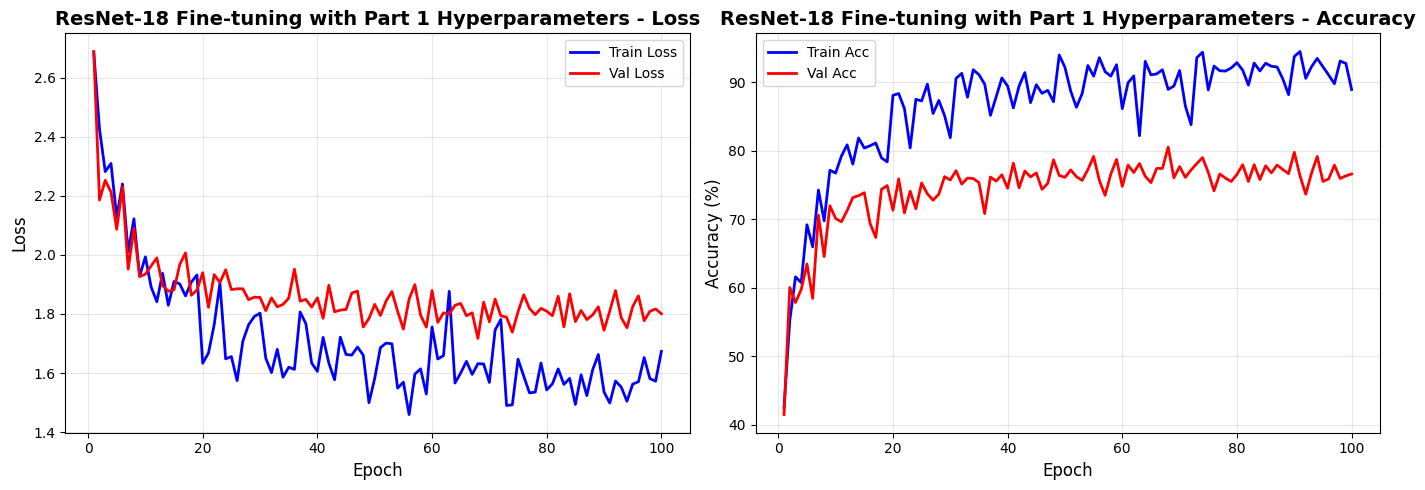


FINAL TEST RESULTS:
  Accuracy: 83.64%
  Loss: 1.6575
  Total Test Time: 5.37s



In [ ]:
# Load pretrained ResNet-18
model_resnet_2a = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_features = model_resnet_2a.fc.in_features
model_resnet_2a.fc = nn.Linear(num_features, NUM_CLASSES)
model_resnet_2a = model_resnet_2a.to(DEVICE)

# Create criterion with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)

# Create AdamW optimizer
optimizer = optim.AdamW(
    model_resnet_2a.parameters(),
    lr=1e-3,
    weight_decay=2e-4,
    betas=(0.9, 0.999)
)

# Train ResNet-18 model
model_resnet_2a, history_2a = train_model(
    model=model_resnet_2a,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=EPOCHS,
    device=DEVICE,
    use_amp=USE_AMP,
    num_classes=NUM_CLASSES,
    cutmix_prob=0.15,
    mixup_prob=0.15
)


# Plot results
plot_training_history(history_2a, "ResNet-18 Fine-tuning with Part 1 Hyperparameters")


# Test evaluation
test_loss_2a, test_acc_2a, test_time_2a = validate(model_resnet_2a, test_loader, criterion, DEVICE)

print(f'\n{"="*80}')
print(f'FINAL TEST RESULTS:')
print(f'  Accuracy: {test_acc_2a:.2f}%')
print(f'  Loss: {test_loss_2a:.4f}')
print(f'  Total Test Time: {test_time_2a:.2f}s')
print(f'{"="*80}\n')

### Part 2B: Optimized Fine-tuning Strategy

Analysis of the Part 2A results revealed critical limitations in the initial training approach. The model achieved a test accuracy of 83.64%, demonstrating reasonable performance on the pet classification task, yet the training dynamics indicated substantial room for improvement. The training curves exposed clear overfitting patterns, with training accuracy reaching 88.93% while validation accuracy plateaued at 76.61% (best: 80.53%), creating a generalization gap of approximately 8-12%. The divergence between training and validation loss after epoch 20, coupled with high-frequency oscillations in validation accuracy, signaled insufficient regularization during training.

Furthermore, by training all layers from initialization with uniform learning rates, we risked catastrophic forgetting of the valuable ImageNet features already encoded in the pretrained ResNet-18 backbone, essentially undermining the fundamental advantage of transfer learning. The pretrained weights, which capture robust low-level and mid-level visual features from ImageNet's diverse dataset, were being aggressively updated rather than thoughtfully adapted to the pet classification domain.

These observations motivated a revised training strategy centered on gradual unfreezing and differentiated hyperparameters across stages. This technique is commonly used in both CV and NLP tasks, originally introduced by [4].

In Stage 1, only the final classifier is trained while the backbone remains frozen, allowing the model to learn task-specific decision boundaries on top of stable, pretrained representations. In Stage 2, we unfreeze the last residual block (`layer4`), which encodes high-level semantic features, and fine-tune it with a reduced learning rate to specialise these representations for the target classes. Finally, in Stage 3, both `layer3` and `layer4` are jointly fine-tuned using an even lower learning rate to further refine the model's performance on our task while preserving previously learned structure.

Across all stages, the classifier is kept trainable to continuously adapt to evolving feature representations.

Each training stage is the result of iterative empirical experimentation. Consequently, learning rates, regularisation strength, and optimisation settings are manually tuned at each stage, together with a task-specific data augmentation pipeline described below.

#### New data augmentation strategy
The original data augmentation pipeline was designed to train a custom CNN from scratch, and therefore applied strong transformations to aggressively regularise the model and reduce overfitting. This choice was justified by the limited size of our dataset.

For fine-tuning a pretrained ResNet-18, however, such heavy augmentations are no longer necessary and can even be damaging, as they may distort features that are already well aligned with ImageNet statistics. In this setting, the objective is not to relearn low-level visual features, but rather to adapt high-level representations to the new classes.

We therefore adopt a softer augmentation strategy, retaining only transformations such as random cropping, horizontal flipping, mild colour jittering. This results in a better trade-off between regularisation and feature preservation, leading to more stable fine-tuning and improved convergence.

In [ ]:
# Tuned transformation of the training set for
# fine-tuning the ResNet-18 model
ft_train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    RandAugment(num_ops=2, magnitude=6),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    transforms.RandomErasing(p=0.15, scale=(0.02, 0.2))
])


# Create the new Data Loader
ft_train_dataset = OxfordPetDataset("train", transform=ft_train_transform)
ft_train_loader = DataLoader(
    ft_train_dataset, 
    batch_size, 
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=dl_generator,
    pin_memory=True
)

#### Stage 1: training only the classifier

In this stage, we train only the classification head (`model_resnet_2b.fc`) while keeping the entire ResNet-18 backbone frozen.

We regularise the classifier using dropout (`0.4`), label smoothing (`0.1`), and Mixup (`0.2`) to reduce overfitting and encourage smoother decision boundaries during early training.

The classifier is optimised with `AdamW` as in Part 1 of this project.

A `CosineAnnealingLR` scheduler is explicitly inserted into the training loop because empirical observations showed improved training stability and smoother learning curves compared to a fixed learning rate. The scheduler parameters are manually tuned: setting `T_max` significantly larger than the number of training epochs slows down the decay process, preventing premature convergence, while a small `eta_min` enforces a gentle refinement of the classifier weights toward the end of training.

In [ ]:
print("\nStage 1: Training classifier only (backbone frozen)")
print("-" * 60)

# Load ResNet-18 model pretrained on ImageNet-1K (V1)
model_resnet_2b = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Update classification head
num_features = model_resnet_2b.fc.in_features
model_resnet_2b.fc = nn.Sequential(
    nn.Dropout(0.4), # Add Dropout to the classification layer
    nn.Linear(model_resnet_2b.fc.in_features, NUM_CLASSES)
)

model_resnet_2b = model_resnet_2b.to(DEVICE)

# Freeze all layers except final classifier
for param in model_resnet_2b.parameters():
    param.requires_grad = False
for param in model_resnet_2b.fc.parameters():
    param.requires_grad = True

# Train classifier
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model_resnet_2b.fc.parameters(), lr=1e-3, weight_decay=2e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150, eta_min=1e-5)

model_resnet_2b, history_stage1 = train_model(
    model_resnet_2b, ft_train_loader, val_loader, criterion, optimizer,
    num_epochs=20, device=DEVICE, use_amp=USE_AMP, cutmix_prob=0.0,
    mixup_prob=0.2, scheduler=scheduler
)


Stage 1: Training classifier only (backbone frozen)
------------------------------------------------------------

Epoch 1/20
------------------------------------------------------------


Train Loss: 3.1562 | Train Acc: 22.59% | Time: 18.11s
Val Loss: 2.0132 | Val Acc: 65.98% | Time: 5.38s

Epoch 2/20
------------------------------------------------------------


Train Loss: 2.1969 | Train Acc: 55.68% | Time: 18.11s
Val Loss: 1.6162 | Val Acc: 79.33% | Time: 5.36s

Epoch 3/20
------------------------------------------------------------


Train Loss: 2.0114 | Train Acc: 62.55% | Time: 18.31s
Val Loss: 1.4699 | Val Acc: 81.57% | Time: 5.45s

Epoch 4/20
------------------------------------------------------------


Train Loss: 1.9875 | Train Acc: 65.74% | Time: 18.23s
Val Loss: 1.3954 | Val Acc: 82.88% | Time: 5.45s

Epoch 5/20
------------------------------------------------------------


Train Loss: 1.8633 | Train Acc: 67.35% | Time: 18.06s
Val Loss: 1.3486 | Val Acc: 82.77% | Time: 5.44s

Epoch 6/20
------------------------------------------------------------


Train Loss: 1.7136 | Train Acc: 70.84% | Time: 17.95s
Val Loss: 1.3034 | Val Acc: 84.08% | Time: 5.40s

Epoch 7/20
------------------------------------------------------------


Train Loss: 1.7391 | Train Acc: 70.81% | Time: 18.15s
Val Loss: 1.2794 | Val Acc: 85.17% | Time: 5.41s

Epoch 8/20
------------------------------------------------------------


Train Loss: 1.6230 | Train Acc: 73.37% | Time: 18.45s
Val Loss: 1.2580 | Val Acc: 85.77% | Time: 5.41s

Epoch 9/20
------------------------------------------------------------


Train Loss: 1.7468 | Train Acc: 70.16% | Time: 18.09s
Val Loss: 1.2507 | Val Acc: 86.21% | Time: 5.48s

Epoch 10/20
------------------------------------------------------------


Train Loss: 1.7255 | Train Acc: 72.42% | Time: 18.10s
Val Loss: 1.2380 | Val Acc: 85.77% | Time: 5.39s

Epoch 11/20
------------------------------------------------------------


Train Loss: 1.7297 | Train Acc: 72.53% | Time: 18.22s
Val Loss: 1.2235 | Val Acc: 85.55% | Time: 5.45s

Epoch 12/20
------------------------------------------------------------


Train Loss: 1.5711 | Train Acc: 75.09% | Time: 18.35s
Val Loss: 1.2144 | Val Acc: 86.04% | Time: 5.42s

Epoch 13/20
------------------------------------------------------------


Train Loss: 1.7098 | Train Acc: 73.34% | Time: 18.05s
Val Loss: 1.2111 | Val Acc: 86.75% | Time: 5.28s

Epoch 14/20
------------------------------------------------------------


Train Loss: 1.7347 | Train Acc: 72.17% | Time: 18.25s
Val Loss: 1.2111 | Val Acc: 86.48% | Time: 5.49s

Epoch 15/20
------------------------------------------------------------


Train Loss: 1.5679 | Train Acc: 75.88% | Time: 18.36s
Val Loss: 1.2079 | Val Acc: 85.71% | Time: 5.42s

Epoch 16/20
------------------------------------------------------------


Train Loss: 1.7218 | Train Acc: 74.30% | Time: 18.28s
Val Loss: 1.2031 | Val Acc: 86.37% | Time: 5.35s

Epoch 17/20
------------------------------------------------------------


Train Loss: 1.5086 | Train Acc: 77.24% | Time: 18.10s
Val Loss: 1.2008 | Val Acc: 86.15% | Time: 5.44s

Epoch 18/20
------------------------------------------------------------


Train Loss: 1.6028 | Train Acc: 75.42% | Time: 17.93s
Val Loss: 1.1970 | Val Acc: 85.55% | Time: 5.54s

Epoch 19/20
------------------------------------------------------------


Train Loss: 1.6176 | Train Acc: 75.20% | Time: 18.08s
Val Loss: 1.1954 | Val Acc: 86.21% | Time: 5.49s

Epoch 20/20
------------------------------------------------------------


Train Loss: 1.6284 | Train Acc: 75.80% | Time: 18.38s
Val Loss: 1.1893 | Val Acc: 86.31% | Time: 5.41s


Best Validation Accuracy: 86.75%
Total Training Time: 6.06 minutes
Average Training Time per Epoch: 18.18 seconds


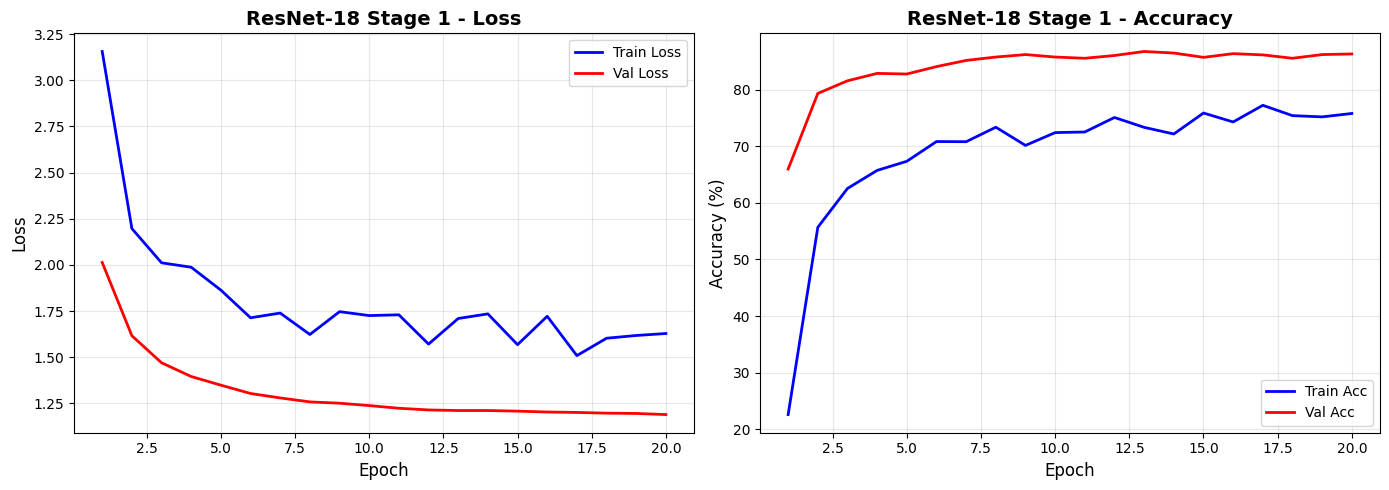


Test Accuracy Stage 1 ResNet-18: 86.62%


In [ ]:
# Plot training result
plot_training_history(history_stage1, "ResNet-18 Stage 1")

# Test evaluation
test_loss_2b, test_acc_2b, _ = validate(model_resnet_2b, test_loader, criterion, DEVICE)
print(f'\n{"="*60}')
print(f'Test Accuracy Stage 1 ResNet-18: {test_acc_2b:.2f}%')
print(f'{"="*60}')

#### Stage 2: unfreezing layer 4

The strong results obtained in Stage 1 indicate that the pretrained ResNet-18 backbone already provides highly discriminative features and that most of the model capacity is sufficient for the task, with the main limitation being the adaptability of higher-level representations. Consequently, in Stage 2 we selectively unfreeze only `layer4`, which encodes the most abstract and semantically rich features, while keeping earlier layers frozen to preserve low and mid-level representations learned from ImageNet. Both `layer4` and the classifier are optimized jointly using `AdamW` with a reduced learning rate ($1e^{-4}$) and smaller weight decay regularization ($5e^{-6}$). Additionally, `MixUp` augmentation is disabled to avoid over-regularization, impeading the model to achieve higher scores. 

As in Stage 1, a `CosineAnnealingLR` scheduler is used for improved training stability, with a long `T_max` and lower `eta_min` ($1e^{-6}$) to ensure slow, smooth convergence.

In [ ]:
print("\nStage 2: Training classifier and layer 4")
print("-" * 60)

# Unfreeze classifier and layer 4
for param in model_resnet_2b.parameters():
    param.requires_grad = False
for param in model_resnet_2b.layer4.parameters():
    param.requires_grad = True
for param in model_resnet_2b.fc.parameters():
    param.requires_grad = True

# AdamW with lower learning rate and weight decay regularization
optimizer = optim.AdamW([
    {'params': model_resnet_2b.layer4.parameters(), 'lr': 1e-4},
    {'params': model_resnet_2b.fc.parameters(), 'lr': 1e-4}
], weight_decay=5e-6)

# CosineAnnealingLR scheduler with lower minimum learning rate
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150, eta_min=1e-6)

# Train classifier and layer 4
model_resnet_2b, history_stage2 = train_model(
    model_resnet_2b, ft_train_loader, val_loader, criterion, optimizer,
    num_epochs=30, device=DEVICE, use_amp=USE_AMP, cutmix_prob=0.0, 
    mixup_prob=0.0, scheduler=scheduler
)


Stage 2: Training classifier and layer 4
------------------------------------------------------------

Epoch 1/30
------------------------------------------------------------


Train Loss: 1.3695 | Train Acc: 79.45% | Time: 18.19s
Val Loss: 1.1628 | Val Acc: 86.64% | Time: 5.48s

Epoch 2/30
------------------------------------------------------------


Train Loss: 1.2335 | Train Acc: 85.12% | Time: 18.11s
Val Loss: 1.1387 | Val Acc: 87.19% | Time: 5.37s

Epoch 3/30
------------------------------------------------------------


Train Loss: 1.2025 | Train Acc: 86.13% | Time: 18.21s
Val Loss: 1.1283 | Val Acc: 87.46% | Time: 5.38s

Epoch 4/30
------------------------------------------------------------


Train Loss: 1.1585 | Train Acc: 88.14% | Time: 18.27s
Val Loss: 1.1308 | Val Acc: 87.51% | Time: 5.49s

Epoch 5/30
------------------------------------------------------------


Train Loss: 1.1322 | Train Acc: 88.77% | Time: 18.26s
Val Loss: 1.1211 | Val Acc: 87.73% | Time: 5.36s

Epoch 6/30
------------------------------------------------------------


Train Loss: 1.1188 | Train Acc: 89.32% | Time: 18.13s
Val Loss: 1.1095 | Val Acc: 88.06% | Time: 5.50s

Epoch 7/30
------------------------------------------------------------


Train Loss: 1.1016 | Train Acc: 89.89% | Time: 18.48s
Val Loss: 1.1081 | Val Acc: 88.00% | Time: 5.39s

Epoch 8/30
------------------------------------------------------------


Train Loss: 1.0947 | Train Acc: 90.38% | Time: 18.28s
Val Loss: 1.1013 | Val Acc: 88.28% | Time: 5.38s

Epoch 9/30
------------------------------------------------------------


Train Loss: 1.0707 | Train Acc: 91.77% | Time: 18.15s
Val Loss: 1.0996 | Val Acc: 88.28% | Time: 5.40s

Epoch 10/30
------------------------------------------------------------


Train Loss: 1.0600 | Train Acc: 91.17% | Time: 18.37s
Val Loss: 1.0937 | Val Acc: 88.33% | Time: 5.52s

Epoch 11/30
------------------------------------------------------------


Train Loss: 1.0545 | Train Acc: 91.61% | Time: 18.37s
Val Loss: 1.0921 | Val Acc: 88.28% | Time: 5.43s

Epoch 12/30
------------------------------------------------------------


Train Loss: 1.0366 | Train Acc: 92.40% | Time: 18.43s
Val Loss: 1.0969 | Val Acc: 87.95% | Time: 5.48s

Epoch 13/30
------------------------------------------------------------


Train Loss: 1.0248 | Train Acc: 93.19% | Time: 18.36s
Val Loss: 1.0951 | Val Acc: 87.95% | Time: 5.49s

Epoch 14/30
------------------------------------------------------------


Train Loss: 1.0060 | Train Acc: 93.57% | Time: 18.36s
Val Loss: 1.0965 | Val Acc: 87.95% | Time: 5.53s

Epoch 15/30
------------------------------------------------------------


Train Loss: 1.0000 | Train Acc: 93.54% | Time: 18.31s
Val Loss: 1.0895 | Val Acc: 88.44% | Time: 5.40s

Epoch 16/30
------------------------------------------------------------


Train Loss: 0.9881 | Train Acc: 94.60% | Time: 18.23s
Val Loss: 1.0867 | Val Acc: 88.17% | Time: 5.50s

Epoch 17/30
------------------------------------------------------------


Train Loss: 0.9960 | Train Acc: 93.92% | Time: 18.16s
Val Loss: 1.0836 | Val Acc: 88.60% | Time: 5.43s

Epoch 18/30
------------------------------------------------------------


Train Loss: 0.9856 | Train Acc: 93.98% | Time: 18.22s
Val Loss: 1.0841 | Val Acc: 88.44% | Time: 5.33s

Epoch 19/30
------------------------------------------------------------


Train Loss: 0.9754 | Train Acc: 94.55% | Time: 18.24s
Val Loss: 1.0832 | Val Acc: 88.44% | Time: 5.45s

Epoch 20/30
------------------------------------------------------------


Train Loss: 0.9687 | Train Acc: 94.49% | Time: 18.17s
Val Loss: 1.0810 | Val Acc: 88.50% | Time: 5.40s

Epoch 21/30
------------------------------------------------------------


Train Loss: 0.9551 | Train Acc: 95.69% | Time: 18.40s
Val Loss: 1.0909 | Val Acc: 88.11% | Time: 5.34s

Epoch 22/30
------------------------------------------------------------


Train Loss: 0.9630 | Train Acc: 94.79% | Time: 18.24s
Val Loss: 1.0822 | Val Acc: 88.44% | Time: 5.39s

Epoch 23/30
------------------------------------------------------------


Train Loss: 0.9534 | Train Acc: 95.07% | Time: 18.28s
Val Loss: 1.0850 | Val Acc: 88.55% | Time: 5.40s

Epoch 24/30
------------------------------------------------------------


Train Loss: 0.9472 | Train Acc: 95.86% | Time: 18.22s
Val Loss: 1.0854 | Val Acc: 88.44% | Time: 5.46s

Epoch 25/30
------------------------------------------------------------


Train Loss: 0.9337 | Train Acc: 95.94% | Time: 18.24s
Val Loss: 1.0863 | Val Acc: 88.44% | Time: 5.51s

Epoch 26/30
------------------------------------------------------------


Train Loss: 0.9398 | Train Acc: 95.75% | Time: 18.27s
Val Loss: 1.0772 | Val Acc: 88.39% | Time: 5.45s

Epoch 27/30
------------------------------------------------------------


Train Loss: 0.9345 | Train Acc: 95.75% | Time: 18.56s
Val Loss: 1.0729 | Val Acc: 88.44% | Time: 5.46s

Epoch 28/30
------------------------------------------------------------


Train Loss: 0.9168 | Train Acc: 96.08% | Time: 18.34s
Val Loss: 1.0814 | Val Acc: 88.33% | Time: 5.57s

Epoch 29/30
------------------------------------------------------------


Train Loss: 0.9094 | Train Acc: 96.51% | Time: 18.39s
Val Loss: 1.0784 | Val Acc: 88.55% | Time: 5.44s

Epoch 30/30
------------------------------------------------------------


Train Loss: 0.9028 | Train Acc: 97.00% | Time: 18.37s
Val Loss: 1.0827 | Val Acc: 88.00% | Time: 5.37s


Best Validation Accuracy: 88.60%
Total Training Time: 9.14 minutes
Average Training Time per Epoch: 18.29 seconds


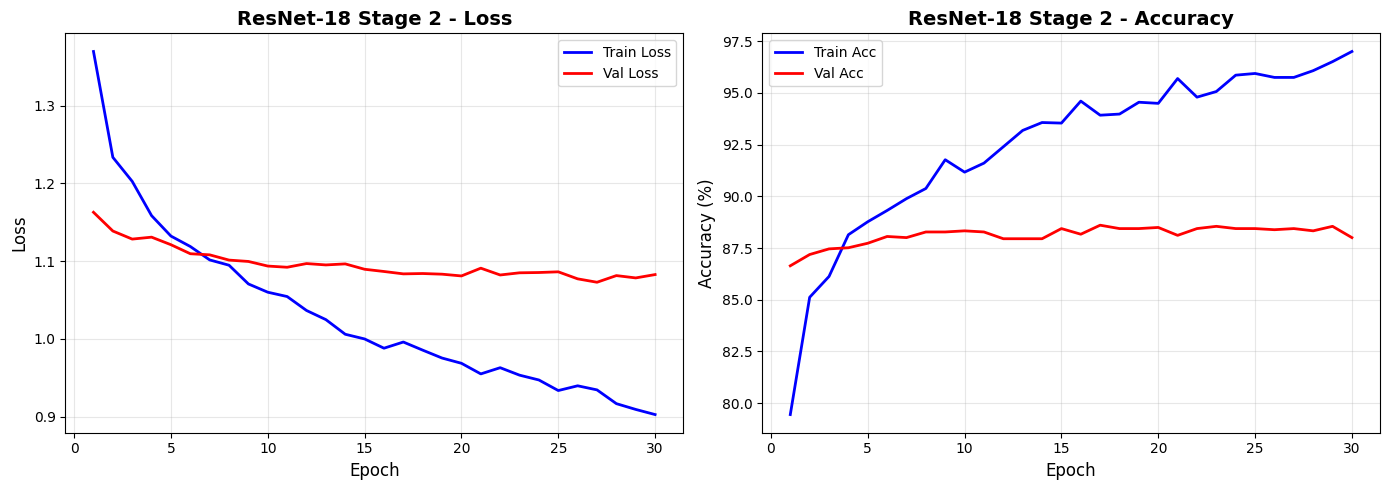


Test Accuracy Stage 2 ResNet-18: 89.49%


In [ ]:
# Plot training result
plot_training_history(history_stage2, "ResNet-18 Stage 2")

# Test evaluation
test_loss_2b, test_acc_2b, _ = validate(model_resnet_2b, test_loader, criterion, DEVICE)
print(f'\n{"="*60}')
print(f'Test Accuracy Stage 2 ResNet-18: {test_acc_2b:.2f}%')
print(f'{"="*60}')

#### Stage 3: Unfreezing layer 3

The stable convergence observed in Stage 2, with validation accuracy reaching 88.60% (test: 89.49%) and minimal oscillations in the validation curve, indicated that the model successfully adapted `layer4` without destabilizing training dynamics. To achieve the target ~90% test accuracy while preserving the learned representations, in this final stage we unfroze `layer3` alongside `layer4` and the `fc`.

All trainable components (`layer3`, `layer4`, and `fc`) are optimized jointly using `AdamW` with a further reduced learning rate ($1e^{-5}$) and minimal weight decay ($1e^{-6}$). The `CosineAnnealingLR` scheduler is maintained with an reduced `T_max` (`50`) and a lower `eta_min` ($1e^{-8}$) to ensure a faster decrease of the learning rate, and enable fine-grained optimization in later epochs.

In [ ]:
print("\nStage 3: Final Fine-tuning (classifier + layer 4 + layer 3)")
print("-" * 60)

# # Unfreeze all layers
for param in model_resnet_2b.parameters():
    param.requires_grad = False
for param in model_resnet_2b.layer3.parameters():
    param.requires_grad = True
for param in model_resnet_2b.layer4.parameters():
    param.requires_grad = True
for param in model_resnet_2b.fc.parameters():
    param.requires_grad = True

# AdamW optimizer with lower learning rate and lower weight decay
optimizer = optim.AdamW([
    {'params': model_resnet_2b.layer3.parameters(), 'lr': 1e-5},
    {'params': model_resnet_2b.layer4.parameters(), 'lr': 1e-5},
    {'params': model_resnet_2b.fc.parameters(), 'lr': 1e-5}
], weight_decay=1e-6)

# CosineAnnealingLR scheduler with lower minimum learning rate
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-8)

# Training classifier, layer 4 and layer 3
model_resnet_2b, history_stage3 = train_model(
    model_resnet_2b, ft_train_loader, val_loader, criterion, optimizer,
    num_epochs=30, device=DEVICE, use_amp=USE_AMP, cutmix_prob=0.0, 
    mixup_prob=0.0, scheduler=scheduler
)


Stage 3: Final Fine-tuning (classifier + layer 4 + layer 3)
------------------------------------------------------------

Epoch 1/30
------------------------------------------------------------


Train Loss: 0.9767 | Train Acc: 94.52% | Time: 18.51s
Val Loss: 1.0822 | Val Acc: 88.44% | Time: 5.47s

Epoch 2/30
------------------------------------------------------------


Train Loss: 0.9703 | Train Acc: 94.88% | Time: 18.30s
Val Loss: 1.0779 | Val Acc: 88.60% | Time: 5.45s

Epoch 3/30
------------------------------------------------------------


Train Loss: 0.9672 | Train Acc: 94.85% | Time: 18.19s
Val Loss: 1.0825 | Val Acc: 88.71% | Time: 5.54s

Epoch 4/30
------------------------------------------------------------


Train Loss: 0.9641 | Train Acc: 95.04% | Time: 18.57s
Val Loss: 1.0778 | Val Acc: 88.55% | Time: 5.45s

Epoch 5/30
------------------------------------------------------------


Train Loss: 0.9591 | Train Acc: 95.42% | Time: 18.52s
Val Loss: 1.0786 | Val Acc: 88.66% | Time: 5.58s

Epoch 6/30
------------------------------------------------------------


Train Loss: 0.9655 | Train Acc: 95.04% | Time: 18.40s
Val Loss: 1.0827 | Val Acc: 88.11% | Time: 5.40s

Epoch 7/30
------------------------------------------------------------


Train Loss: 0.9544 | Train Acc: 95.50% | Time: 18.61s
Val Loss: 1.0787 | Val Acc: 88.60% | Time: 5.46s

Epoch 8/30
------------------------------------------------------------


Train Loss: 0.9607 | Train Acc: 94.82% | Time: 18.35s
Val Loss: 1.0775 | Val Acc: 88.44% | Time: 5.43s

Epoch 9/30
------------------------------------------------------------


Train Loss: 0.9420 | Train Acc: 95.58% | Time: 18.14s
Val Loss: 1.0808 | Val Acc: 88.39% | Time: 5.47s

Epoch 10/30
------------------------------------------------------------


Train Loss: 0.9503 | Train Acc: 95.31% | Time: 18.40s
Val Loss: 1.0787 | Val Acc: 88.77% | Time: 5.38s

Epoch 11/30
------------------------------------------------------------


Train Loss: 0.9392 | Train Acc: 96.05% | Time: 18.38s
Val Loss: 1.0792 | Val Acc: 88.39% | Time: 5.56s

Epoch 12/30
------------------------------------------------------------


Train Loss: 0.9426 | Train Acc: 95.91% | Time: 18.54s
Val Loss: 1.0831 | Val Acc: 88.11% | Time: 5.50s

Epoch 13/30
------------------------------------------------------------


Train Loss: 0.9409 | Train Acc: 95.83% | Time: 18.42s
Val Loss: 1.0785 | Val Acc: 88.50% | Time: 5.35s

Epoch 14/30
------------------------------------------------------------


Train Loss: 0.9332 | Train Acc: 96.02% | Time: 18.36s
Val Loss: 1.0777 | Val Acc: 88.11% | Time: 5.48s

Epoch 15/30
------------------------------------------------------------


Train Loss: 0.9373 | Train Acc: 95.86% | Time: 18.47s
Val Loss: 1.0719 | Val Acc: 88.77% | Time: 5.39s

Epoch 16/30
------------------------------------------------------------


Train Loss: 0.9258 | Train Acc: 96.13% | Time: 18.45s
Val Loss: 1.0738 | Val Acc: 88.33% | Time: 5.43s

Epoch 17/30
------------------------------------------------------------


Train Loss: 0.9297 | Train Acc: 96.18% | Time: 18.21s
Val Loss: 1.0766 | Val Acc: 88.33% | Time: 5.58s

Epoch 18/30
------------------------------------------------------------


Train Loss: 0.9387 | Train Acc: 95.42% | Time: 18.16s
Val Loss: 1.0771 | Val Acc: 88.66% | Time: 5.36s

Epoch 19/30
------------------------------------------------------------


Train Loss: 0.9286 | Train Acc: 95.78% | Time: 18.26s
Val Loss: 1.0745 | Val Acc: 88.39% | Time: 5.51s

Epoch 20/30
------------------------------------------------------------


Train Loss: 0.9216 | Train Acc: 96.43% | Time: 18.37s
Val Loss: 1.0746 | Val Acc: 88.00% | Time: 5.36s

Epoch 21/30
------------------------------------------------------------


Train Loss: 0.9160 | Train Acc: 96.62% | Time: 18.37s
Val Loss: 1.0755 | Val Acc: 88.50% | Time: 5.40s

Epoch 22/30
------------------------------------------------------------


Train Loss: 0.9209 | Train Acc: 96.21% | Time: 18.57s
Val Loss: 1.0715 | Val Acc: 88.60% | Time: 5.68s

Epoch 23/30
------------------------------------------------------------


Train Loss: 0.9212 | Train Acc: 96.21% | Time: 18.35s
Val Loss: 1.0741 | Val Acc: 88.71% | Time: 5.29s

Epoch 24/30
------------------------------------------------------------


Train Loss: 0.9108 | Train Acc: 96.84% | Time: 18.17s
Val Loss: 1.0675 | Val Acc: 88.93% | Time: 5.50s

Epoch 25/30
------------------------------------------------------------


Train Loss: 0.9132 | Train Acc: 96.89% | Time: 18.35s
Val Loss: 1.0729 | Val Acc: 88.77% | Time: 5.44s

Epoch 26/30
------------------------------------------------------------


Train Loss: 0.9031 | Train Acc: 96.81% | Time: 18.32s
Val Loss: 1.0684 | Val Acc: 88.77% | Time: 5.39s

Epoch 27/30
------------------------------------------------------------


Train Loss: 0.9088 | Train Acc: 96.73% | Time: 18.41s
Val Loss: 1.0694 | Val Acc: 88.66% | Time: 5.45s

Epoch 28/30
------------------------------------------------------------


Train Loss: 0.9087 | Train Acc: 97.11% | Time: 18.48s
Val Loss: 1.0753 | Val Acc: 88.60% | Time: 5.47s

Epoch 29/30
------------------------------------------------------------


Train Loss: 0.9040 | Train Acc: 96.76% | Time: 18.12s
Val Loss: 1.0692 | Val Acc: 88.60% | Time: 5.40s

Epoch 30/30
------------------------------------------------------------


Train Loss: 0.9081 | Train Acc: 96.67% | Time: 18.34s
Val Loss: 1.0719 | Val Acc: 88.66% | Time: 5.39s


Best Validation Accuracy: 88.93%
Total Training Time: 9.18 minutes
Average Training Time per Epoch: 18.37 seconds


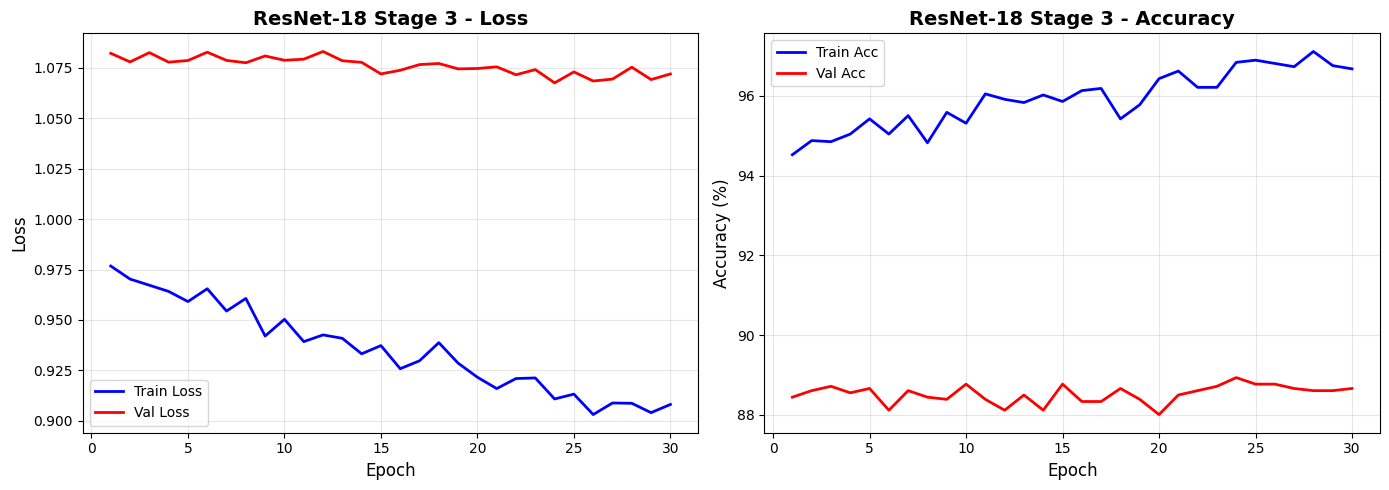


Test Accuracy Stage 3 ResNet-18: 90.30%


In [ ]:
# Plot training result
plot_training_history(history_stage3, "ResNet-18 Stage 3")

# Test evaluation
test_loss_2b, test_acc_2b, _ = validate(model_resnet_2b, test_loader, criterion, DEVICE)
print(f'\n{"="*60}')
print(f'Test Accuracy Stage 3 ResNet-18: {test_acc_2b:.2f}%')
print(f'{"="*60}')

#### Final result

The results confirm that the pretrained ResNet-18 already offers strong low and mid-level features, so lightly adapting the top blocks (layer4, then layer3) with conservative learning rates is sufficient for the Oxford-IIIT Pet task, reaching 90.30% accuracy on the test set. 

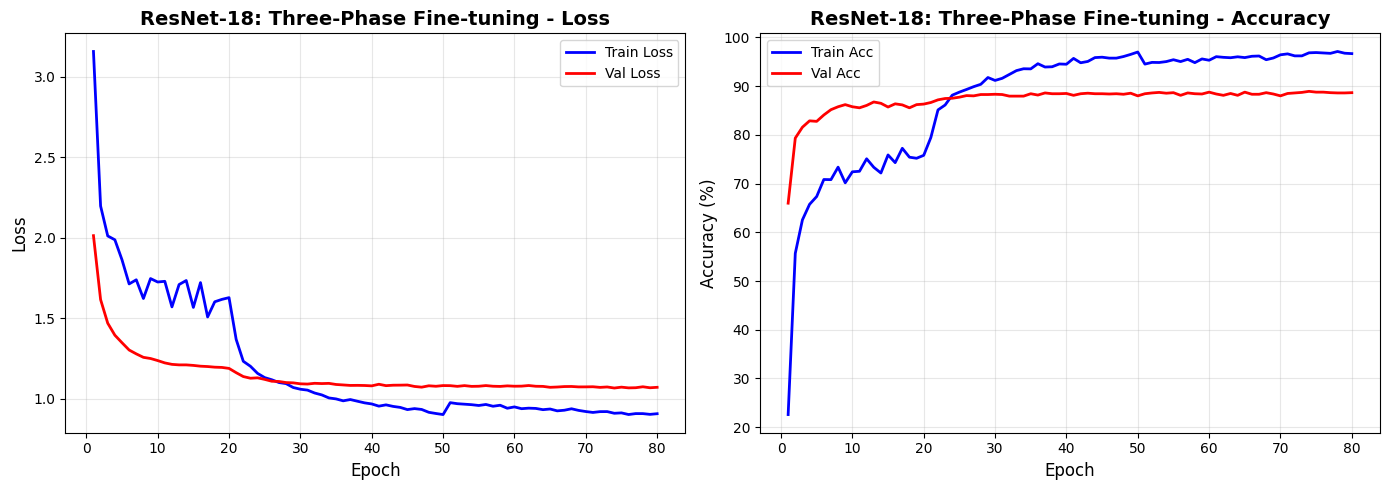

In [ ]:
# Plot full training history
combined_history = {
    'train_loss': history_stage1['train_loss'] + history_stage2['train_loss'] + history_stage3['train_loss'],
    'train_acc': history_stage1['train_acc'] + history_stage2['train_acc'] + history_stage3['train_acc'],
    'val_loss': history_stage1['val_loss'] + history_stage2['val_loss'] + history_stage3['val_loss'],
    'val_acc': history_stage1['val_acc'] + history_stage2['val_acc'] + history_stage3['val_acc'],
    'train_time': history_stage1['train_time'] + history_stage2['train_time'] + history_stage3['train_time'],
}

plot_training_history(combined_history, "ResNet-18: Three-Phase Fine-tuning")

## References


[1] M. Tan and Q. V. Le, _"EfficientNet: Rethinking model scaling for convolutional neural networks,"_ Proceedings of the 36th International Conference on Machine Learning (ICML), 2019. doi: 10.48550/arXiv.1905.11946.

[2] M. Sandler, A. Howard, M. Zhu, A. Zhmoginov, and L. C. Chen, _"MobileNetV2: Inverted residuals and linear bottlenecks,"_ Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Salt Lake City, UT, USA, 2018, pp. 4510–4520.

[3] G. Huang, Y. Sun, Z. Liu, D. Sedra, and K. Q. Weinberger, _"Deep networks with stochastic depth,"_ Proceedings of the European Conference on Computer Vision (ECCV), 2016, pp. 646–661.

[4] J. Howard and S. Ruder, _"Universal Language Model Fine-tuning for Text Classification,"_ Proceedings of the 56th Annual Meeting of the Association for Computational Linguistics (ACL), 2018. doi: 10.48550/arXiv.1801.06146.
